<a href="https://colab.research.google.com/github/CristylePGarrard/ElectionTime/blob/main/legislative_branch_kpi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# I want to create a kpi dashboard for candidates that are running again for the same office

# ####### Install necessary libraries ####### #
!pip install gspread gspread-dataframe pandas openpyxl

# ####### Import libraries ####### #
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from googleapiclient.discovery import build

# ################################################### #
# ####### pull in the data for the candidates ####### #
# ################################################### #

# ####### Mount Google Drive to Colab ####### #
from google.colab import drive
drive.mount('/content/drive')

# ####### Set the file path to uploaded Excel file ####### #
# Update the path with the actual location of file in Google Drive
file_path = '/content/drive/My Drive/ut_pol/'
filename = 'cleaned_candidates_data.csv'

# ####### Read the Excel file into a DataFrame ####### #
print("Reading Excel file...")

# There's a weird warning about the format and openpyxl but we don't gotta worry about that so ignore it
import warnings
warnings.simplefilter("ignore")

# Read the Excel file
candidates = pd.read_csv(file_path+filename)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading Excel file...


# Pull Data

In [2]:
# There are 2 types of candidates running for office in the legislative branch
# Those that have been in office and are running again (incumbent)
# And those who are running to be in office the first time.
# Let's just look at the incumbents and see what legislation they've sponsored and whether it's passed or not passed

# don't need all the info right now
include_columns = ['Name on Ballot', 'First Name', 'Middle Name',
                   'Last Name', 'Office', 'District', 'Party',
                   'Status','Display District', 'record_id', 'Incumbent']
candidates = candidates[include_columns].copy()

# only need candidates that are running again
include_status = ['Election Candidate', 'Write-In']
candidates = candidates.loc[candidates['Status'].isin(include_status)].copy().reset_index(drop=True)

# only look at incumbent candidates
candidates = candidates.loc[candidates['Incumbent'] == True].copy().reset_index(drop=True)
# only look at State House & State Senate
candidates = candidates.loc[candidates['Office'].isin(['State House', 'State Senate'])].copy().reset_index(drop=True)


In [3]:


# #################################################################### #
# ####### pull in the data for the bills that have been passed ####### #
# #################################################################### #

import os

bills_file_path = '/content/drive/My Drive/ut_pol/passedBills/'

list_of_bills = os.listdir(bills_file_path)
# print(list_of_bills)

all_data = []

for f in list_of_bills:
  if f.endswith('.csv'):
    temp = pd.read_csv(bills_file_path + f)
    temp['sheet_name'] = f
    all_data.append(temp)

bills = pd.concat(all_data, axis=0, ignore_index=True)

# print(bills.head())

# we only need data for 2021 - 2024
bills['Year'] = bills['sheet_name'].str.extract(r'(\d{4})')
bills = bills.loc[bills['Year'].isin(['2021', '2022', '2023', '2024'])].copy().reset_index(drop=True)

# make sure dtypes are correct
bills['Date Passed'] = pd.to_datetime(bills['Date Passed'], errors='coerce')
bills['Effective Date'] = pd.to_datetime(bills['Effective Date'], errors='coerce')
bills['Gov\'s Action Date'] = pd.to_datetime(bills['Gov\'s Action Date'], errors='coerce')
bills['Year'] = bills['Year'].astype(int)

# What to do when the gov's action is empty

bills['Governor\'s Action'].unique()

bills.loc[bills['Governor\'s Action'].isnull()]

# Replace null values in the 'Governor's Action' column with 'no value'
bills['Governor\'s Action'] = bills['Governor\'s Action'].fillna('NO VALUE').copy().reset_index(drop=True)

# Merge Data

In [4]:
# 1st merge the two dataframes together
# Extracting last name and first initial from Bill Sponsor in the bills dataframe
bills['Last Name'] = bills['Bill Sponsor'].apply(lambda x: x.split(', ')[0])
bills['First Initial'] = bills['Bill Sponsor'].apply(lambda x: x.split(', ')[1][0] if len(x.split(', ')) > 1 else '')

# Create a column to match with candidates by concatenating Last Name and First Initial
bills['Sponsor Key'] = bills['Last Name'] + ' ' + bills['First Initial']

# In the candidates dataframe, create a key column to match with bills
candidates['First Initial'] = candidates['First Name'].str[0]  # Get the first initial
candidates['Candidate Key'] = candidates['Last Name'] + ' ' + candidates['First Initial']

merged_df = pd.merge(candidates, bills, left_on='Candidate Key', right_on='Sponsor Key', how='left')


In [5]:
# Which candidates sponsored no bills?

print(merged_df.loc[merged_df['Bill Number'].isna()]['Name on Ballot'].unique())

['MATT MACPHERSON']


# Bar chart of counts of bill results for each candidate

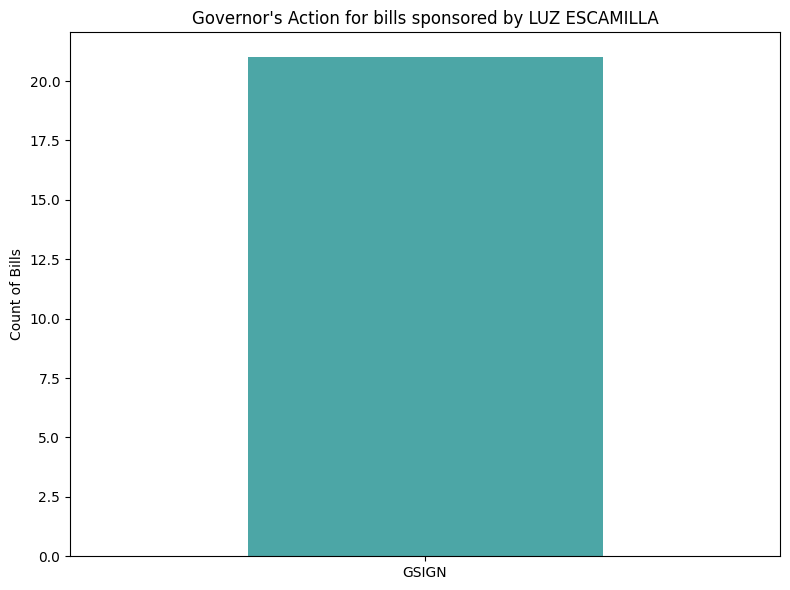

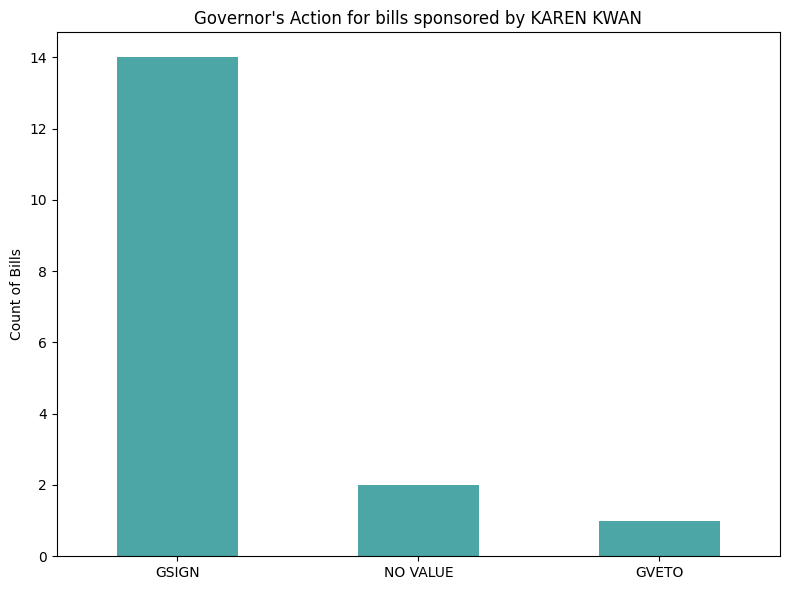

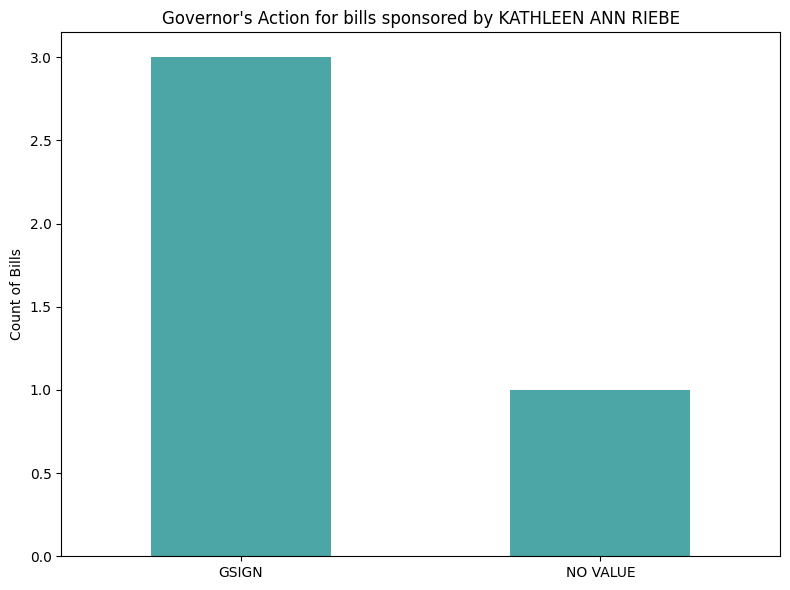

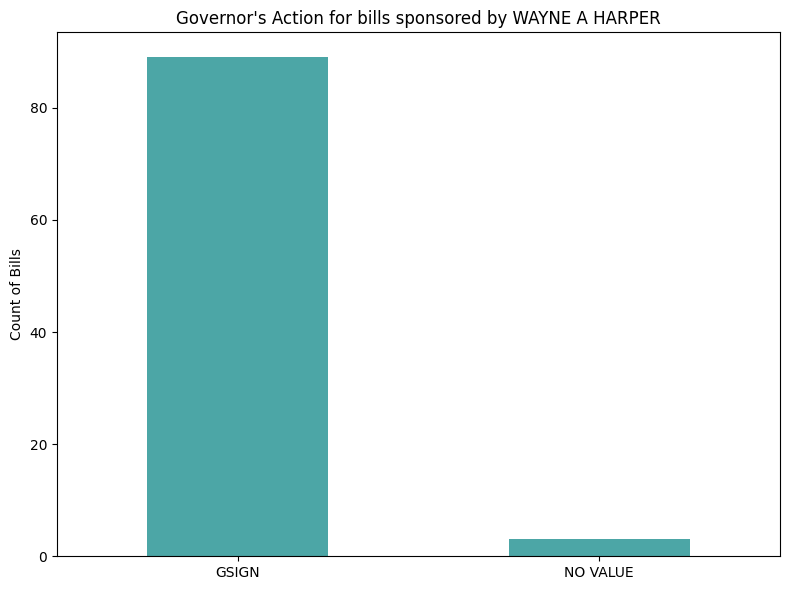

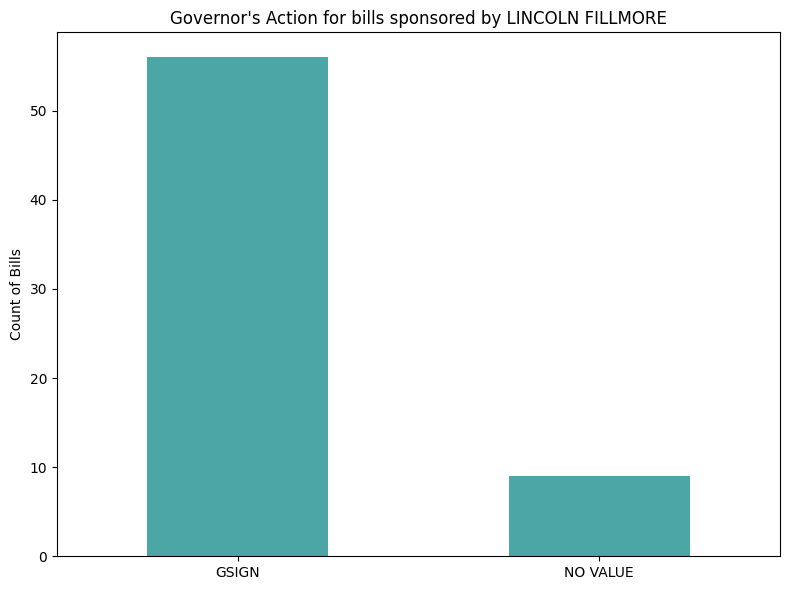

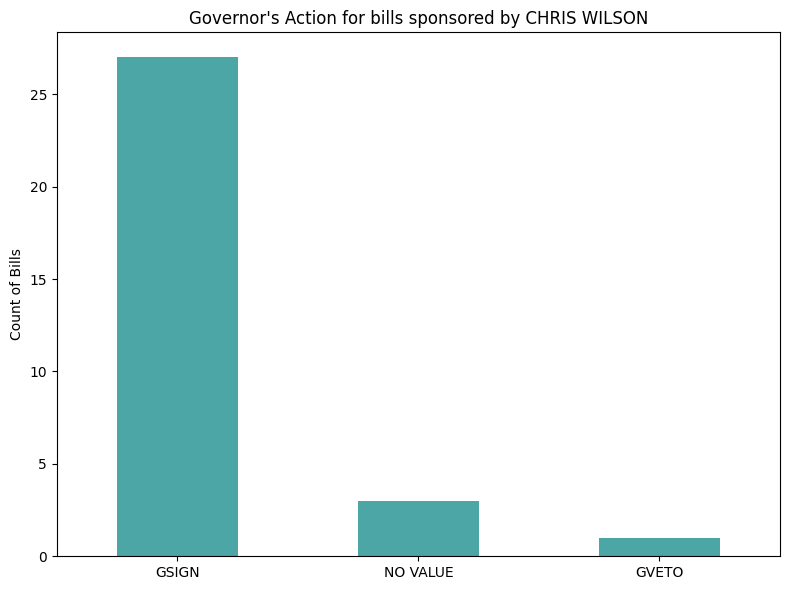

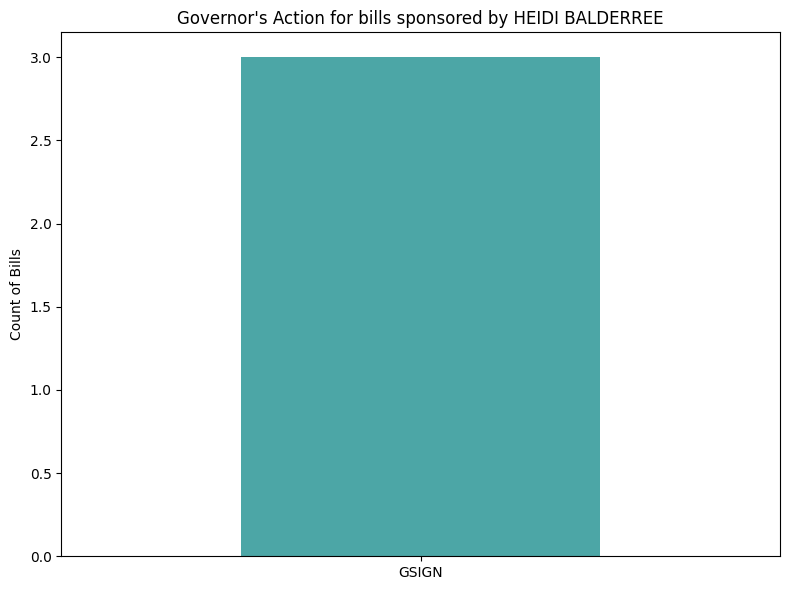

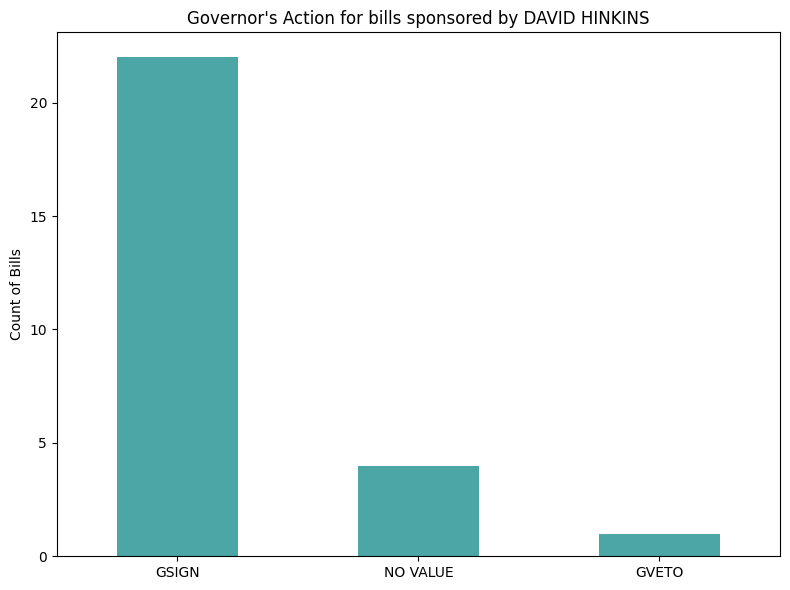

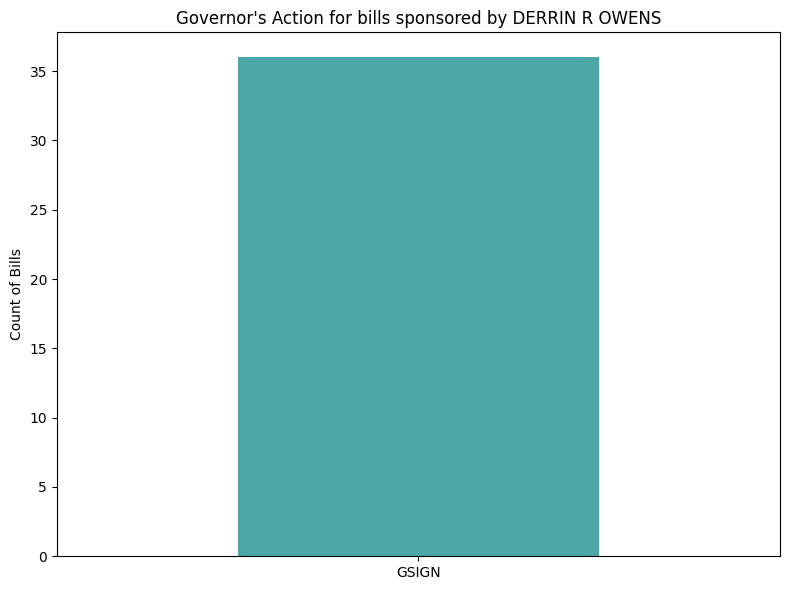

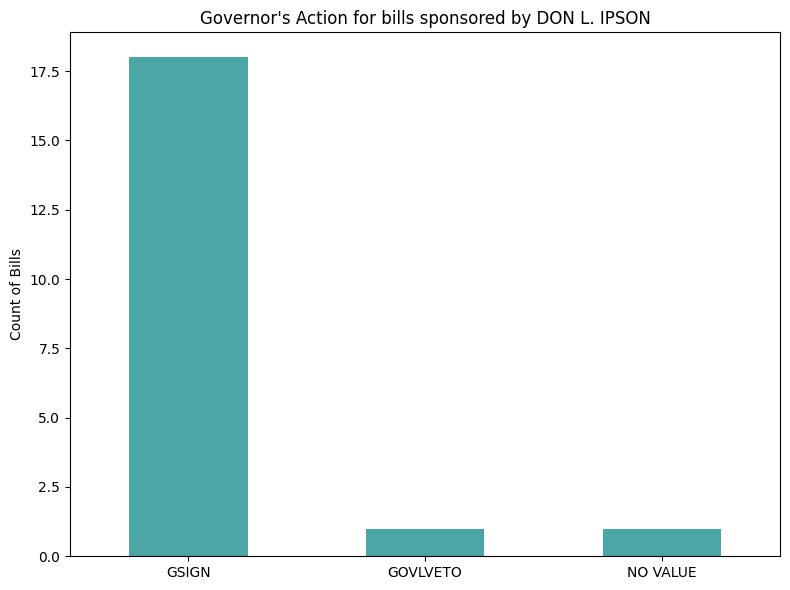

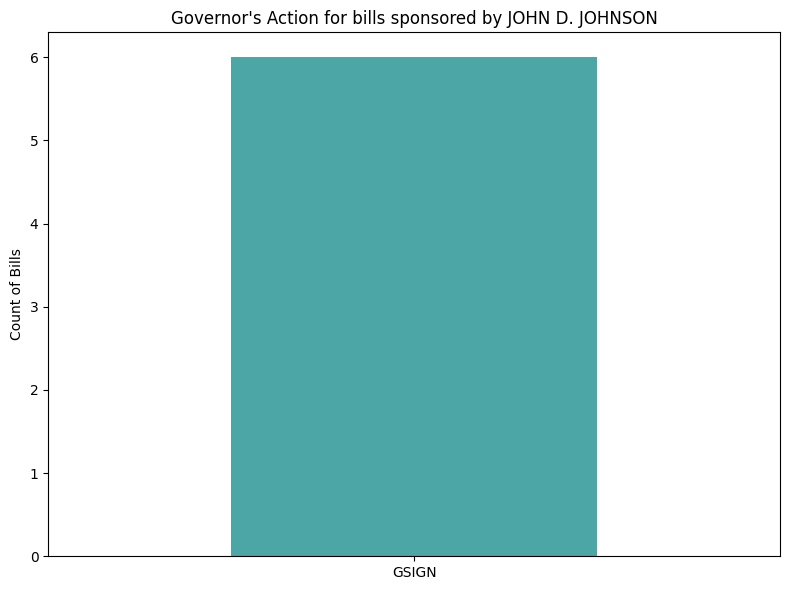

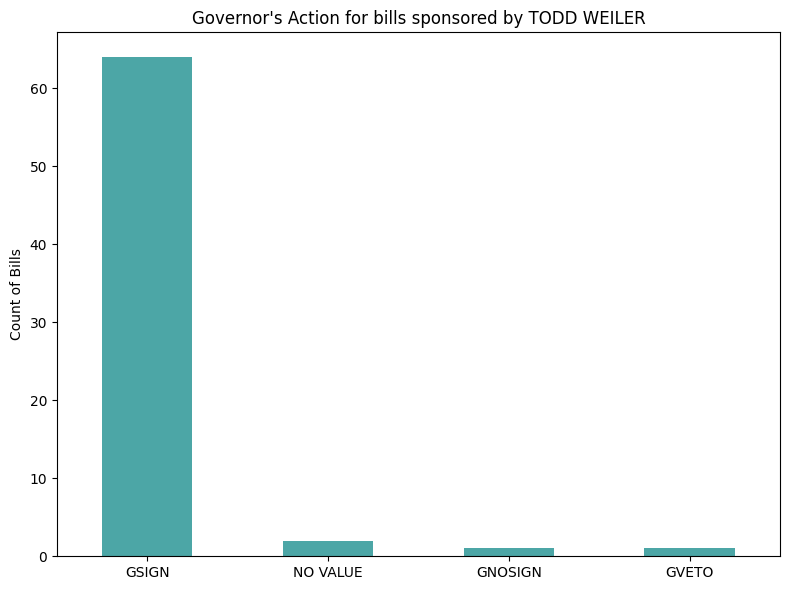

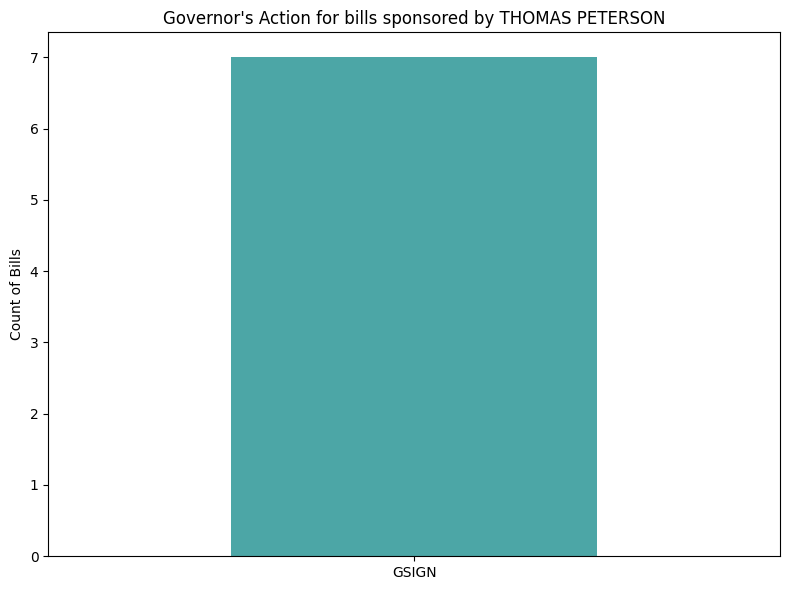

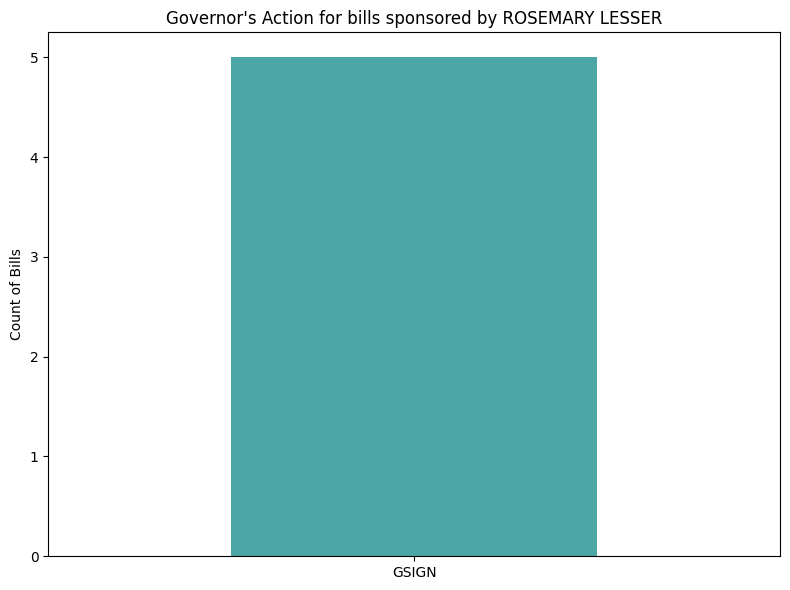

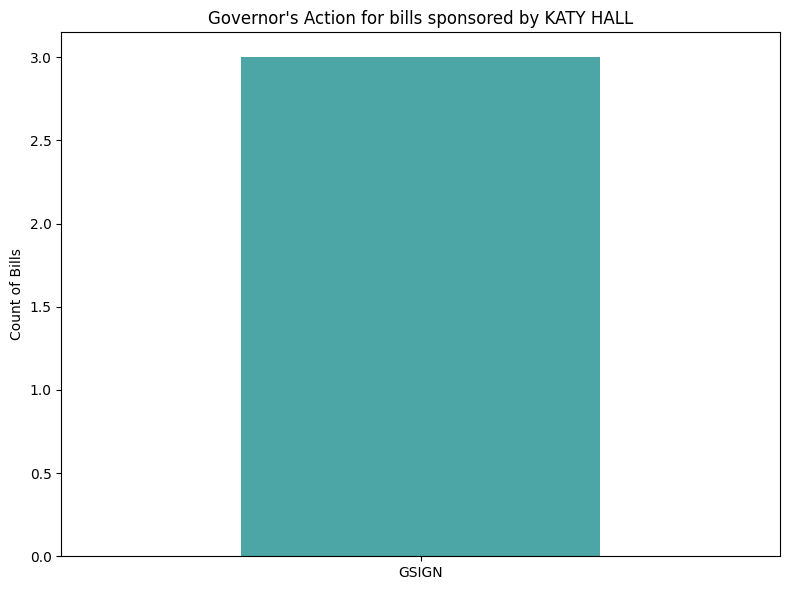

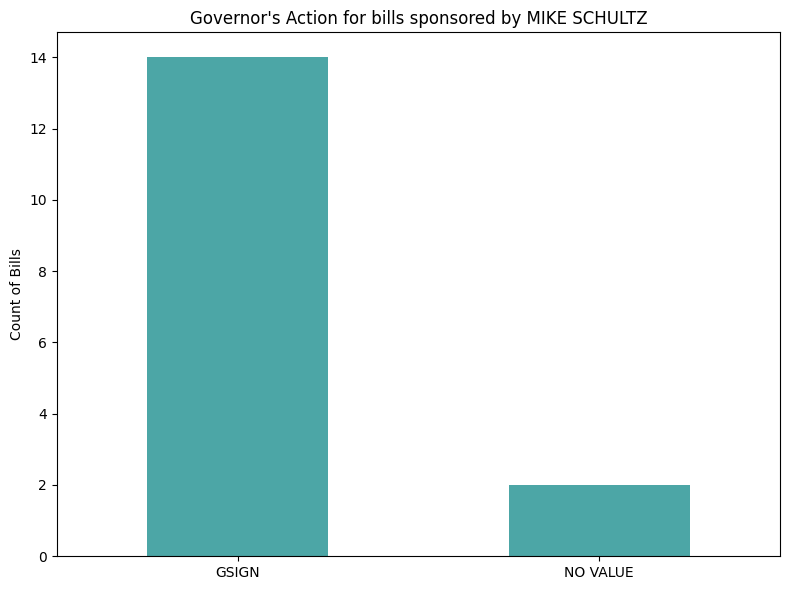

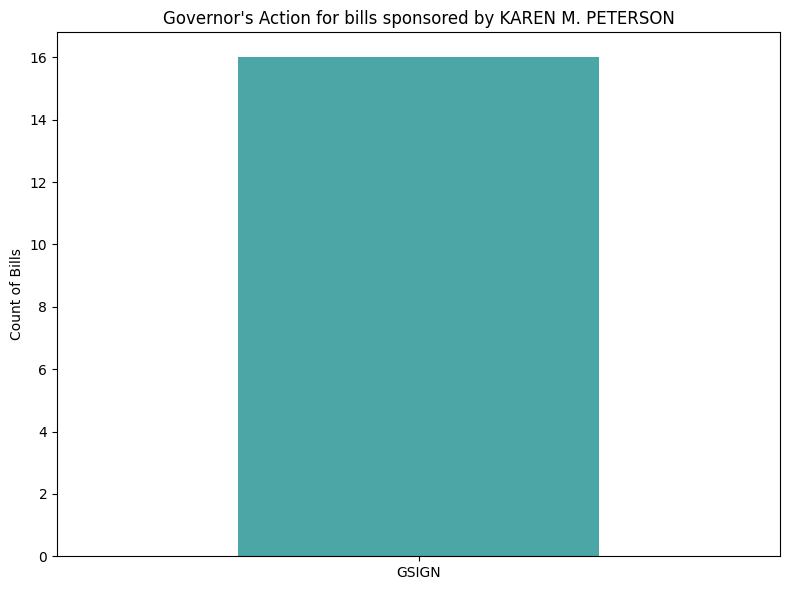

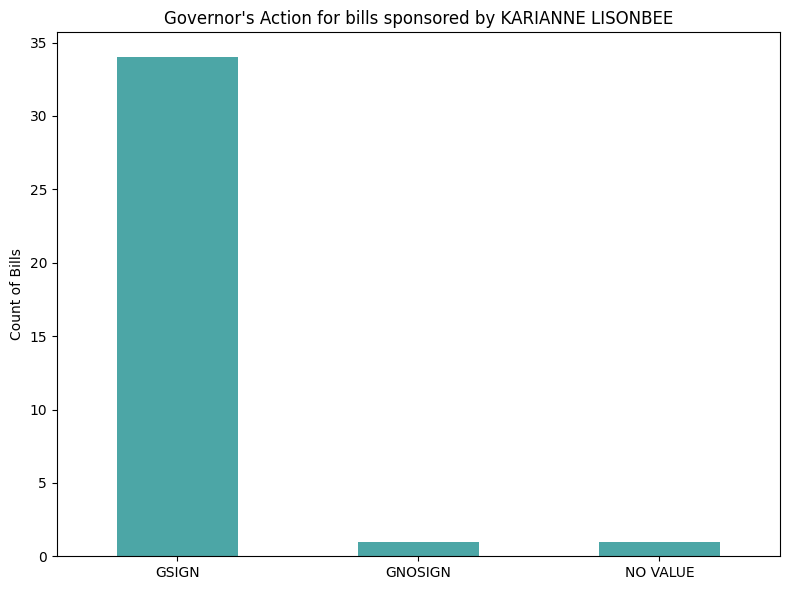

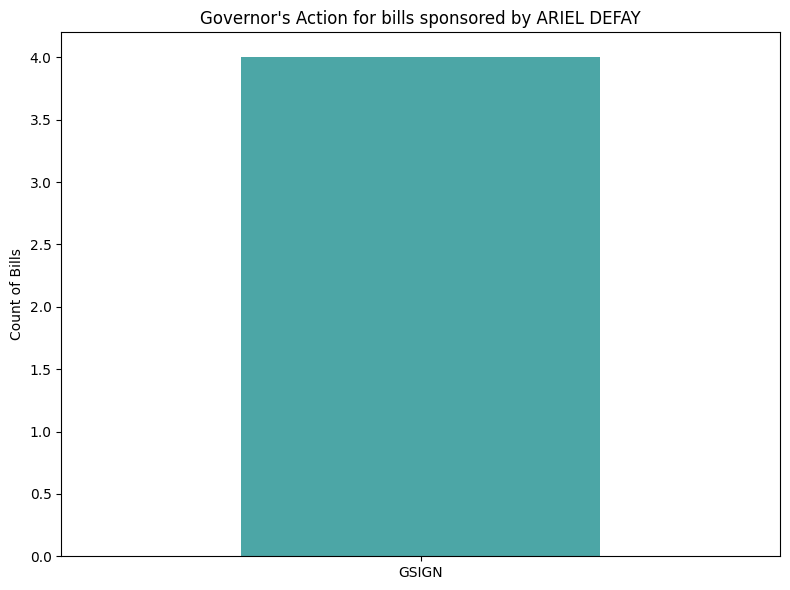

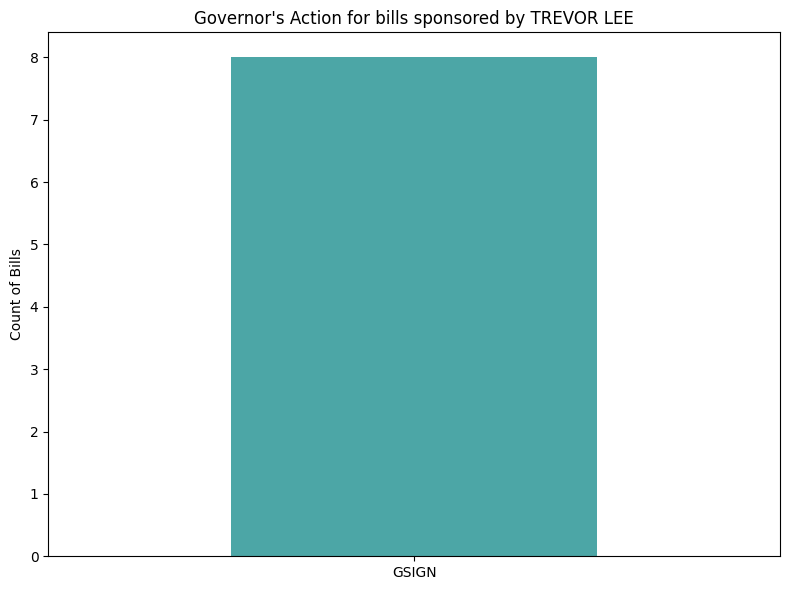

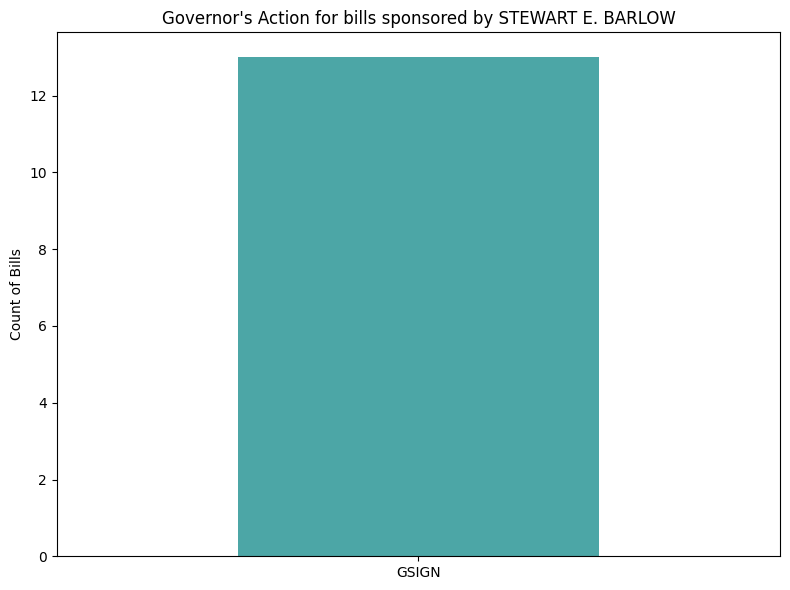

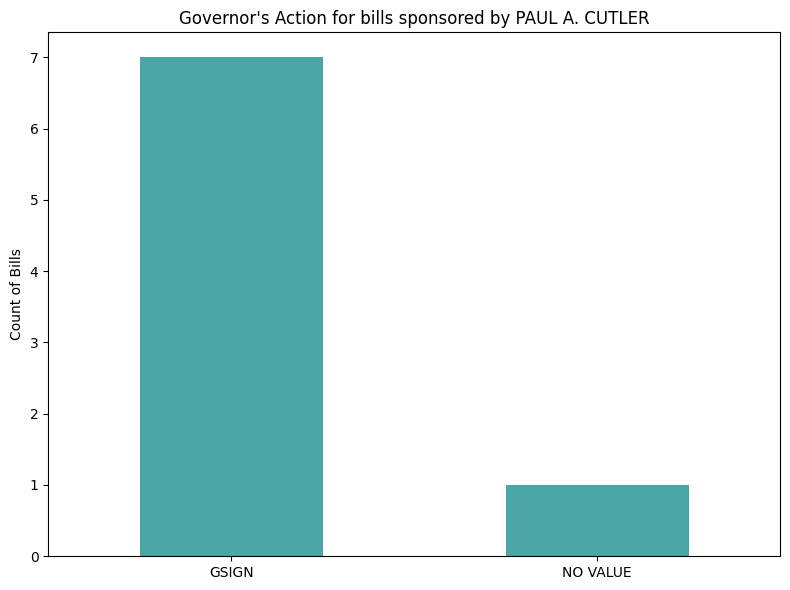

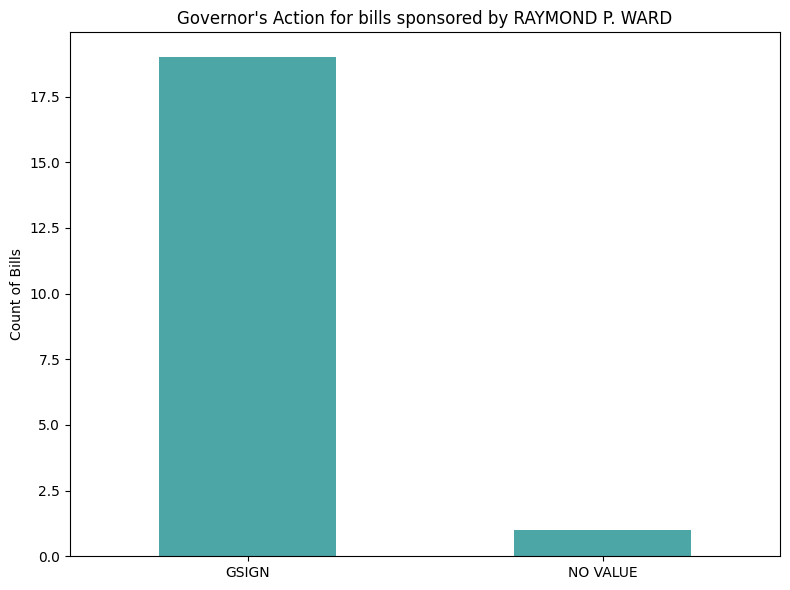

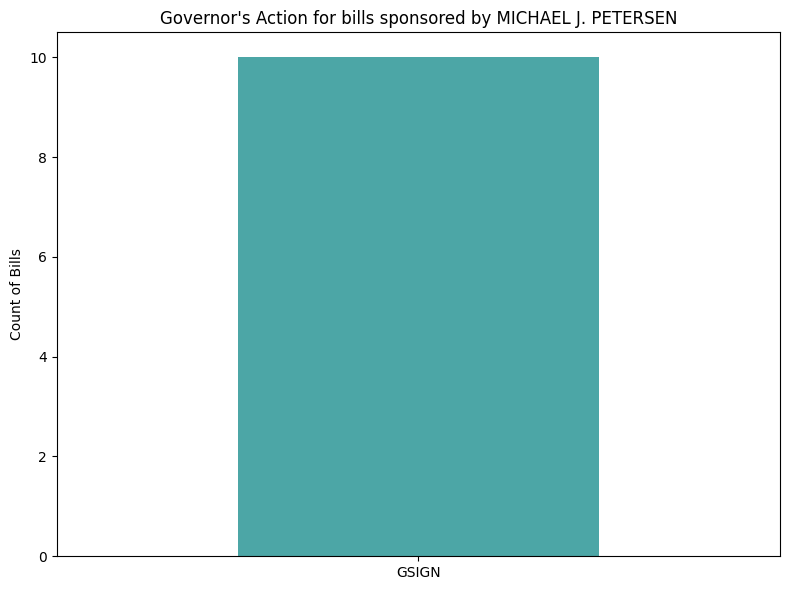

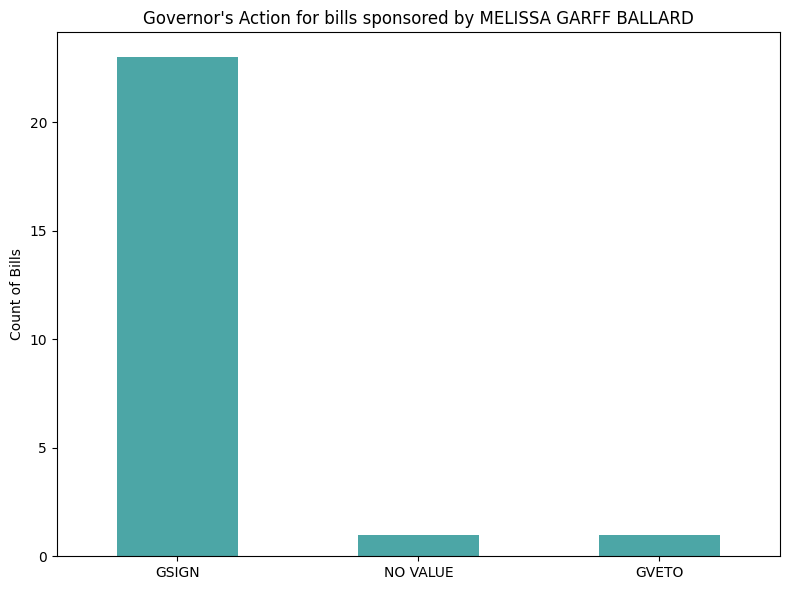

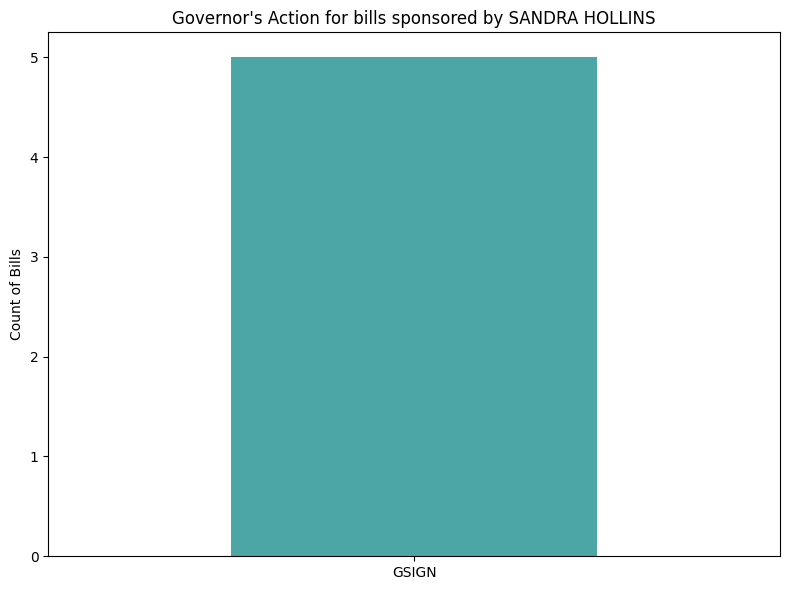

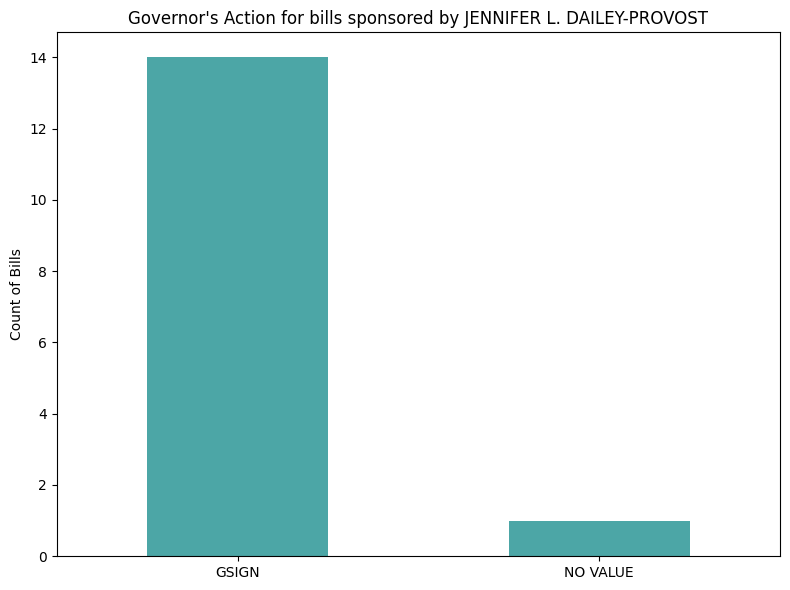

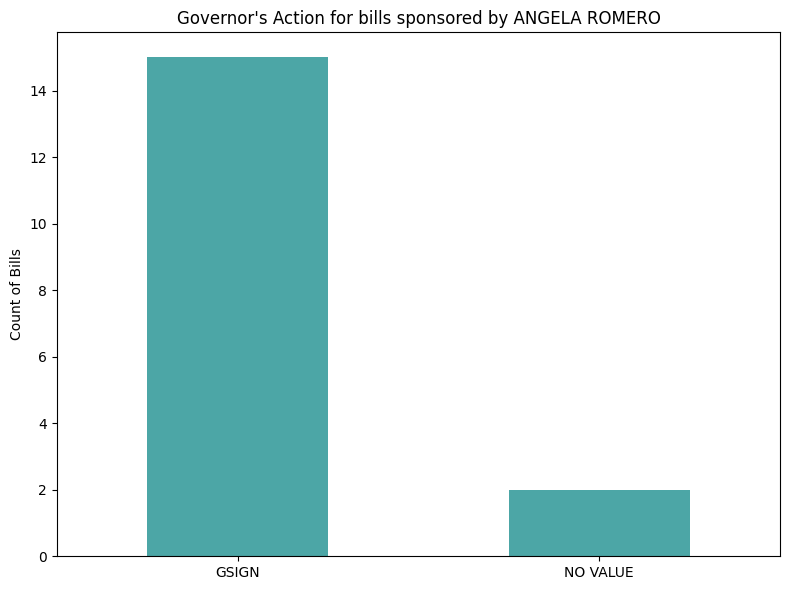

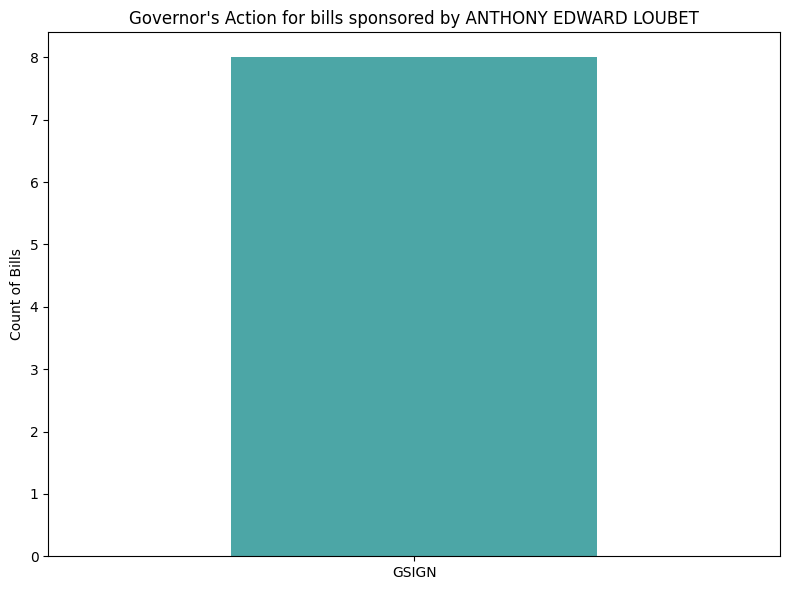

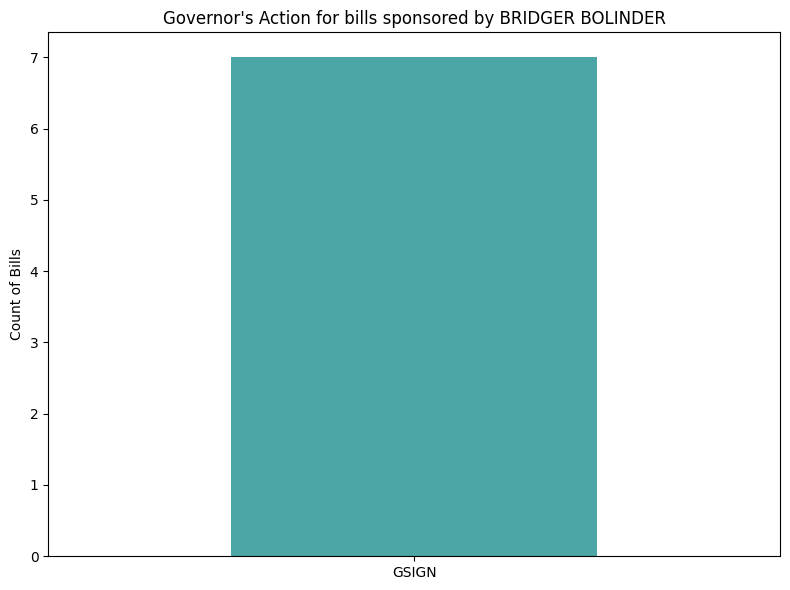

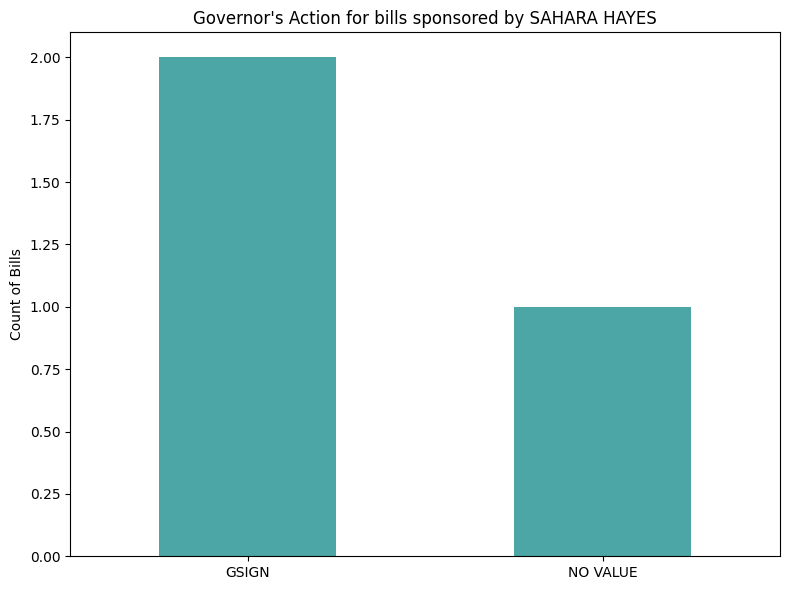

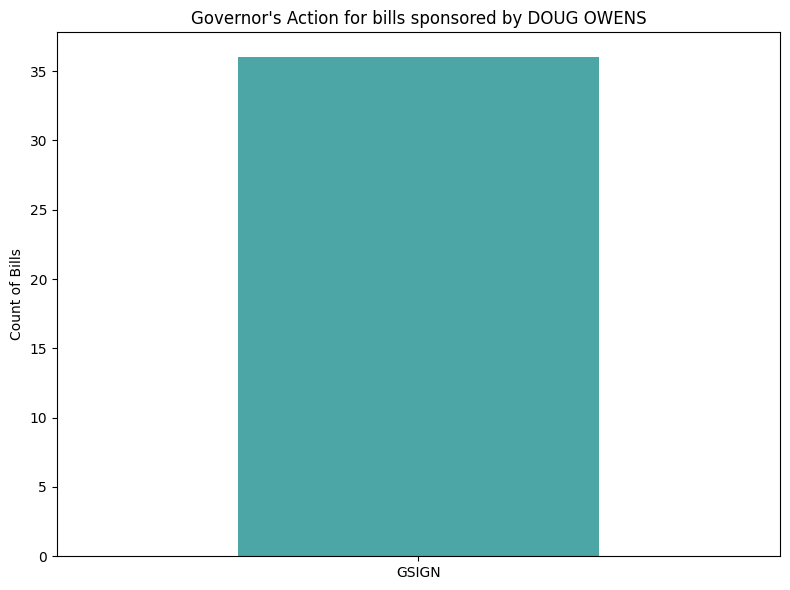

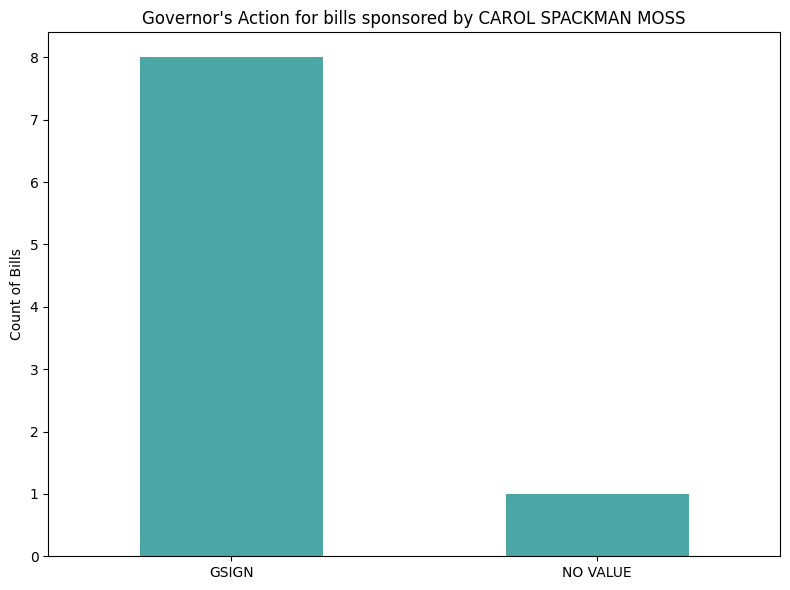

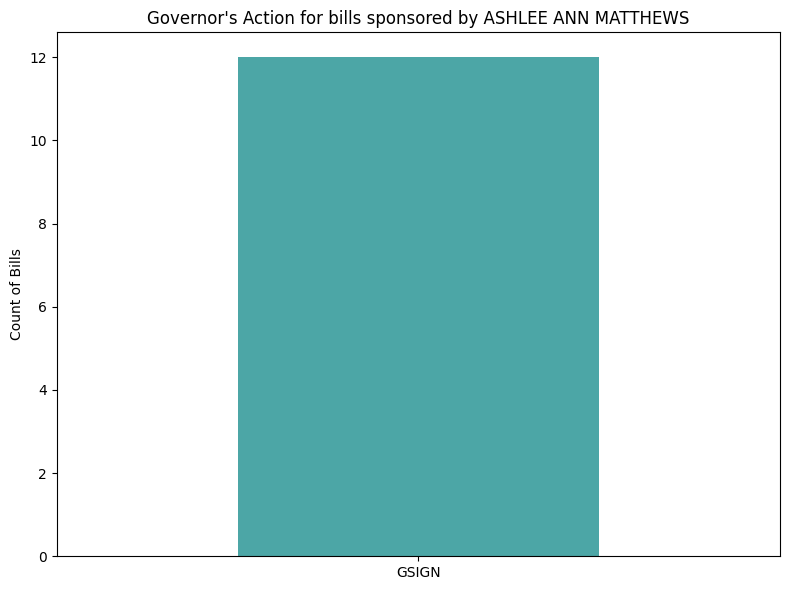

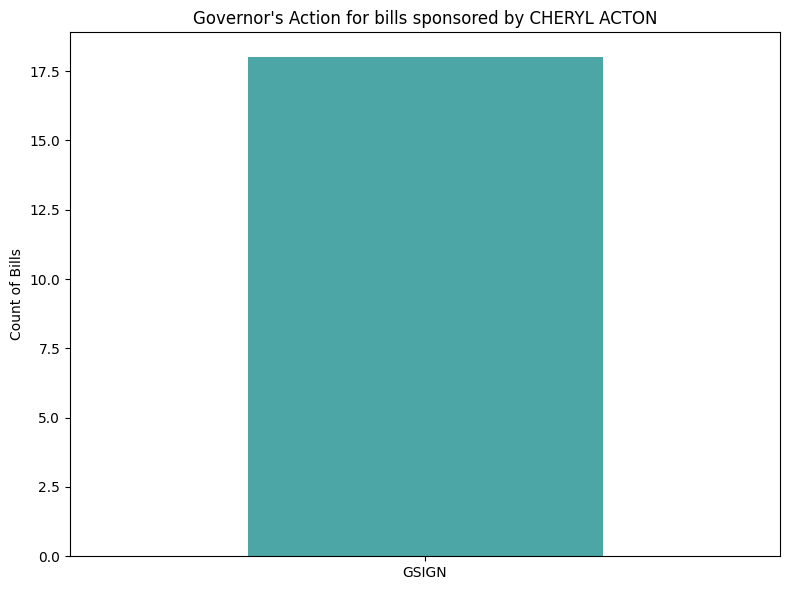

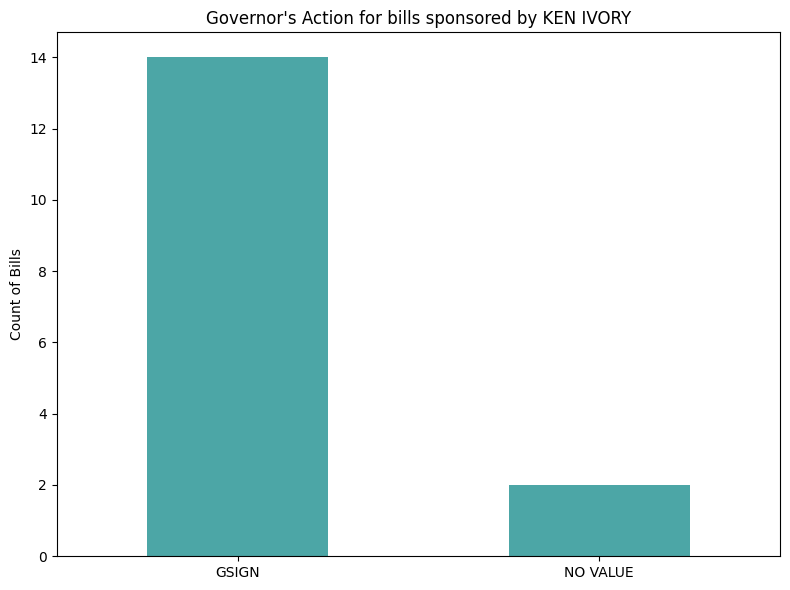

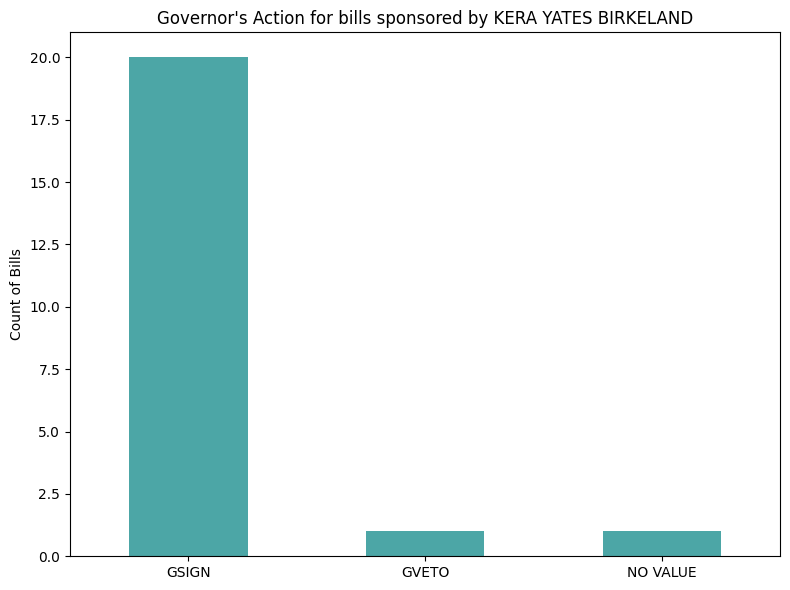

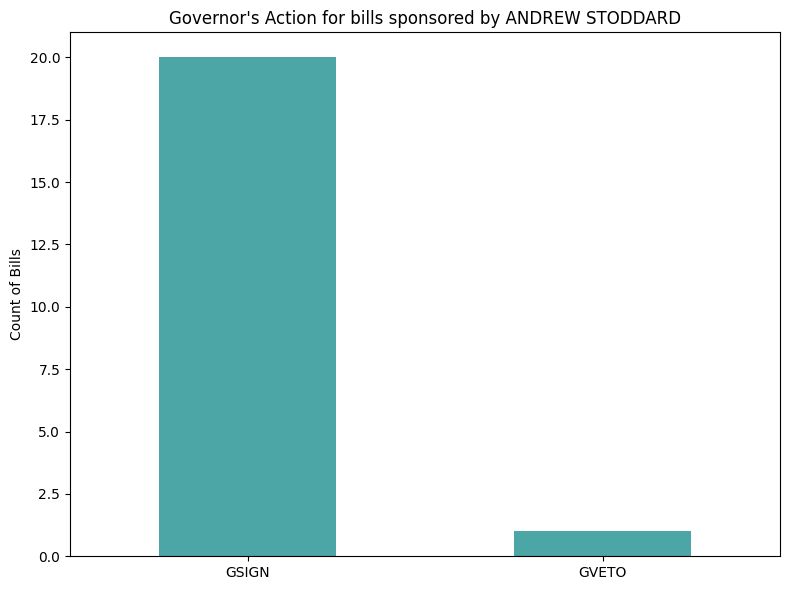

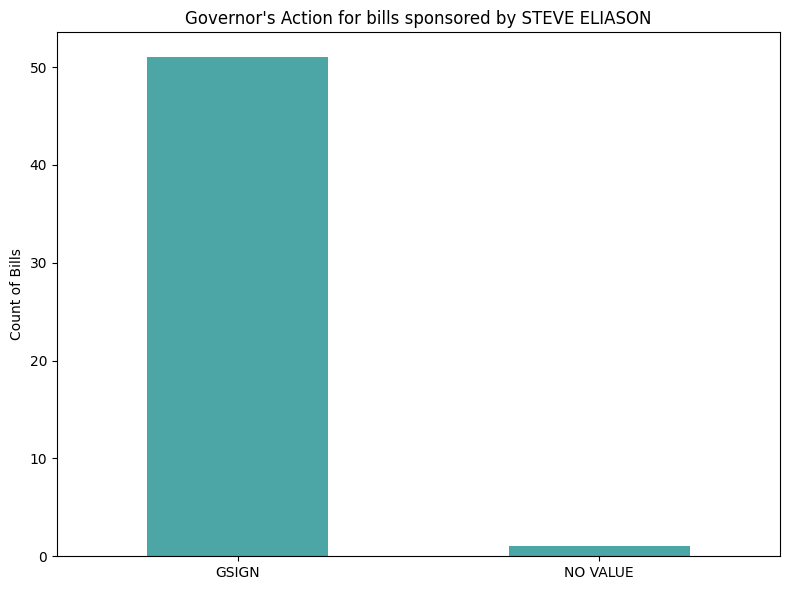

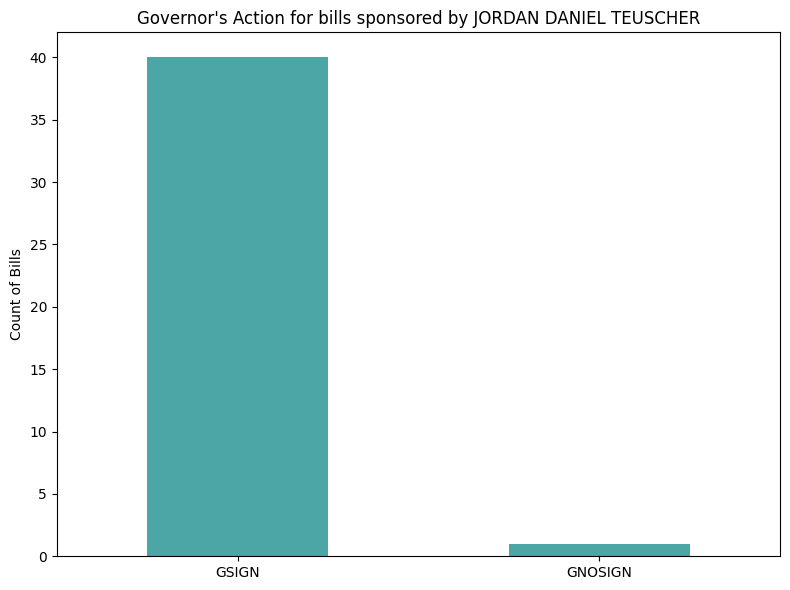

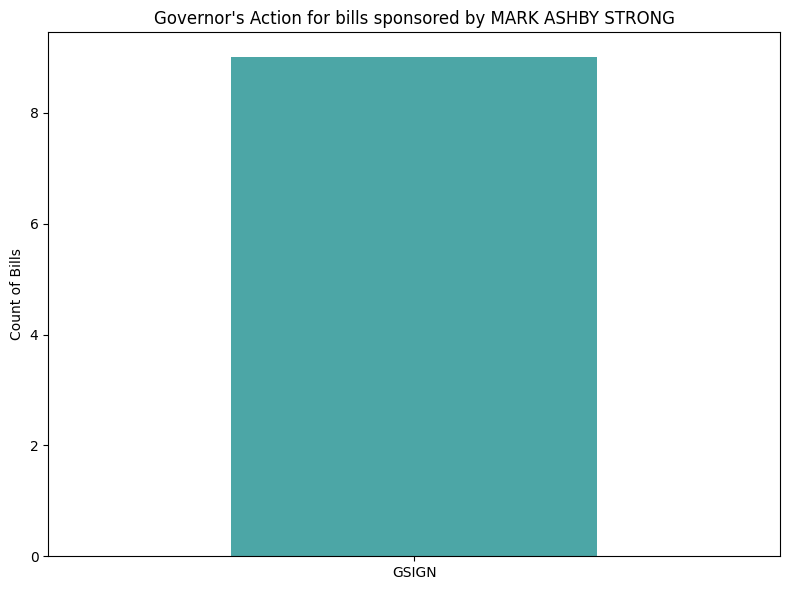

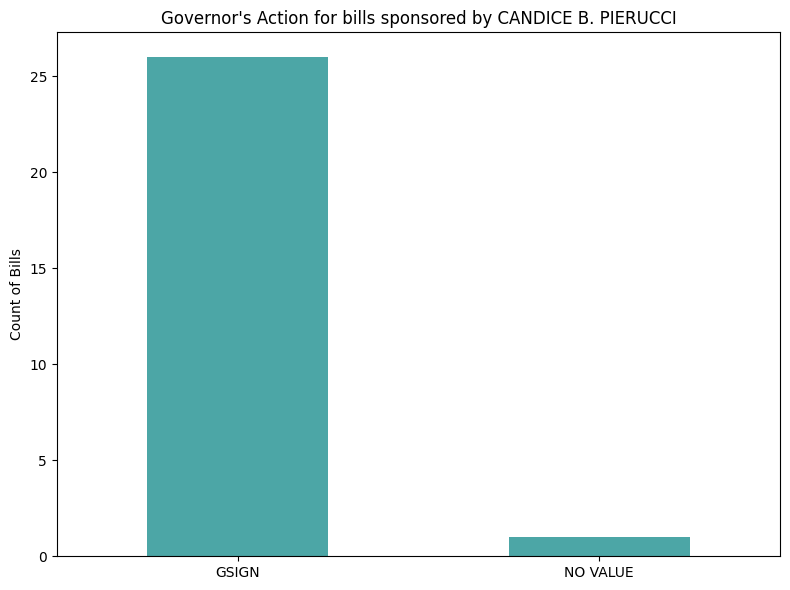

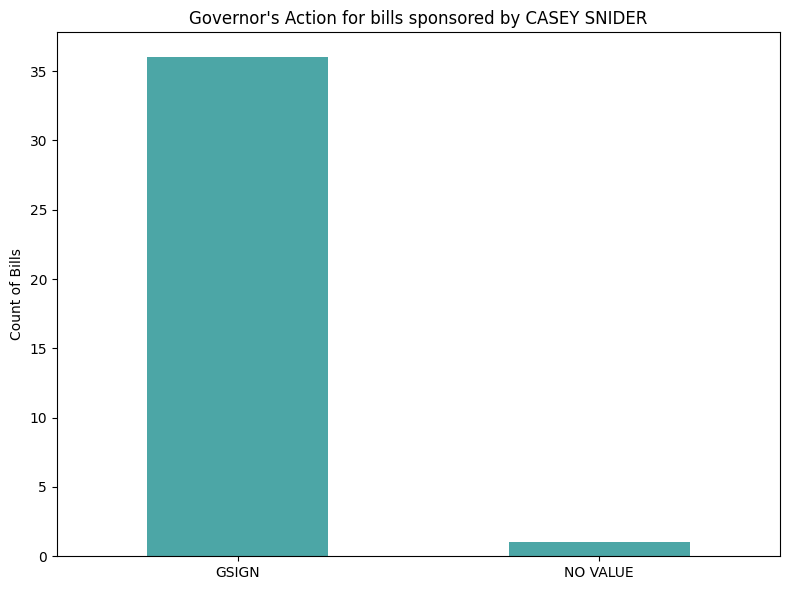

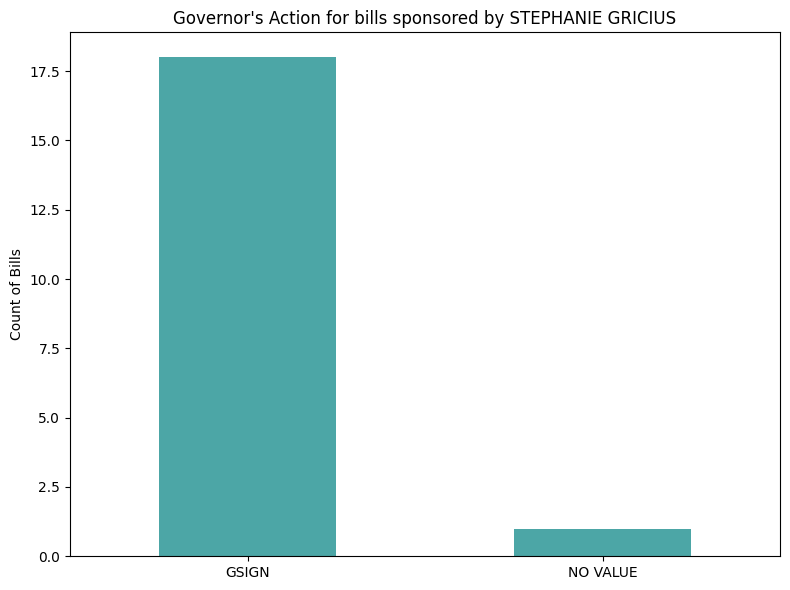

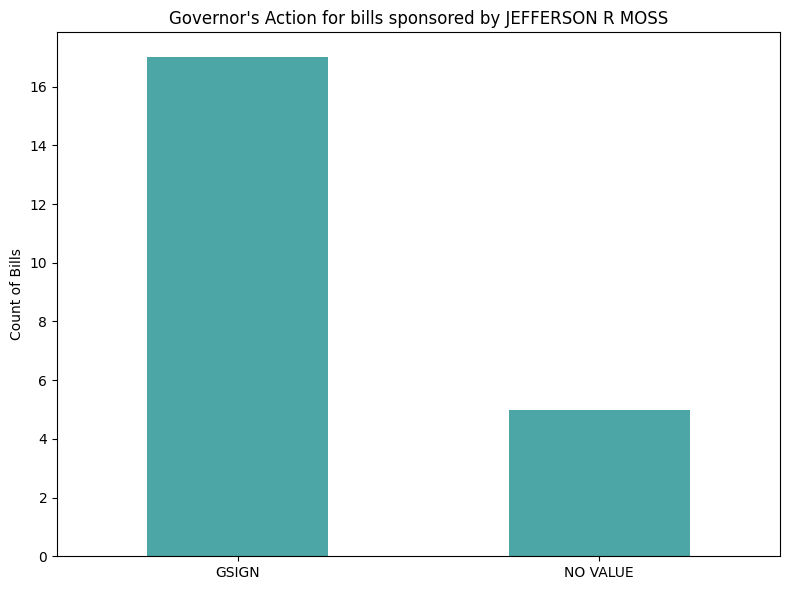

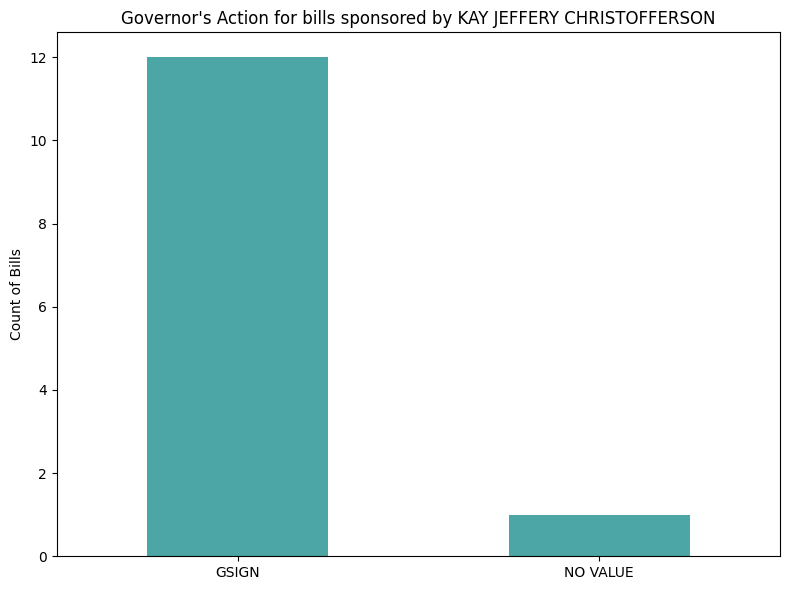

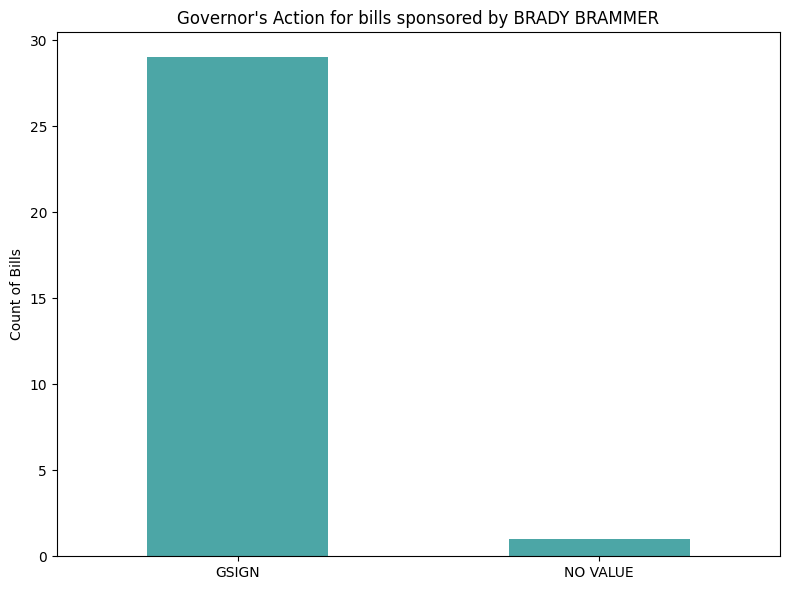

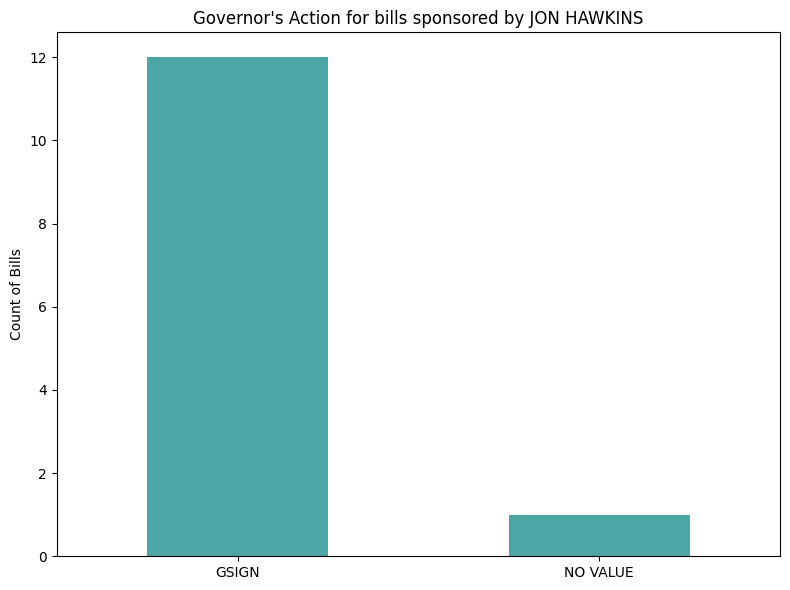

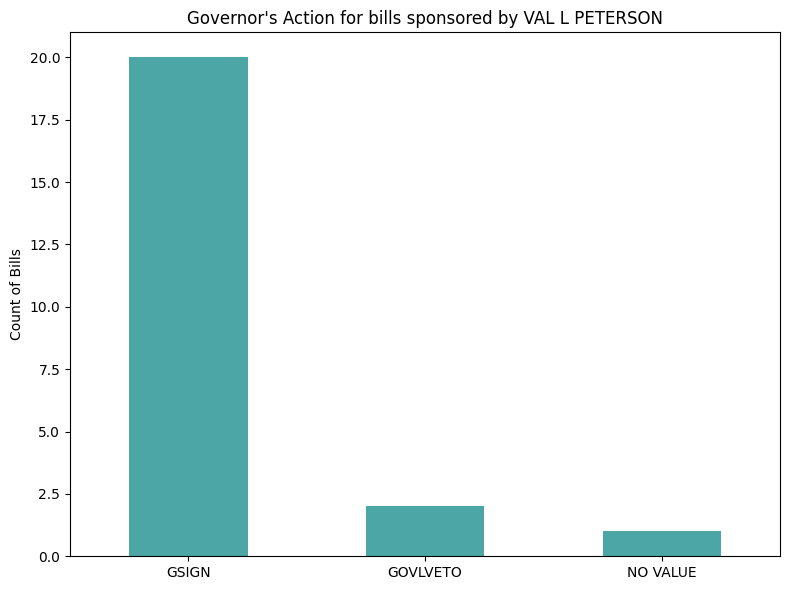

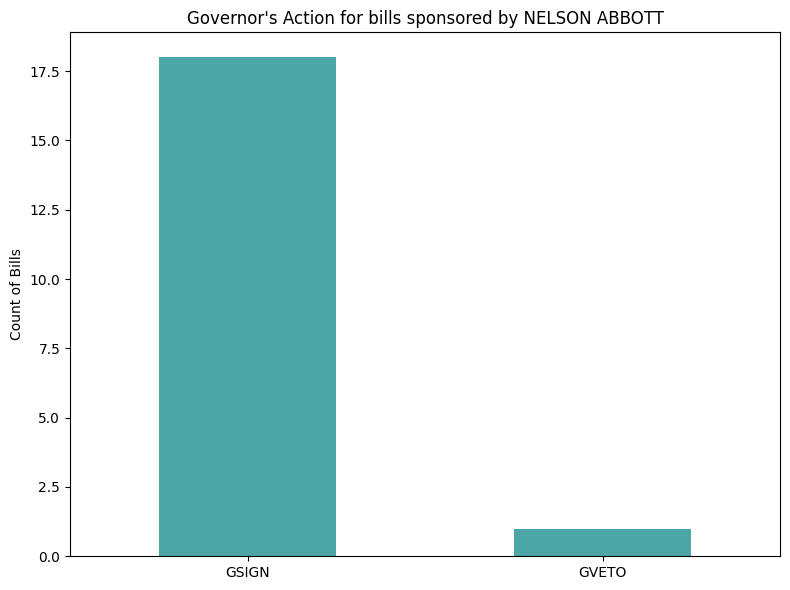

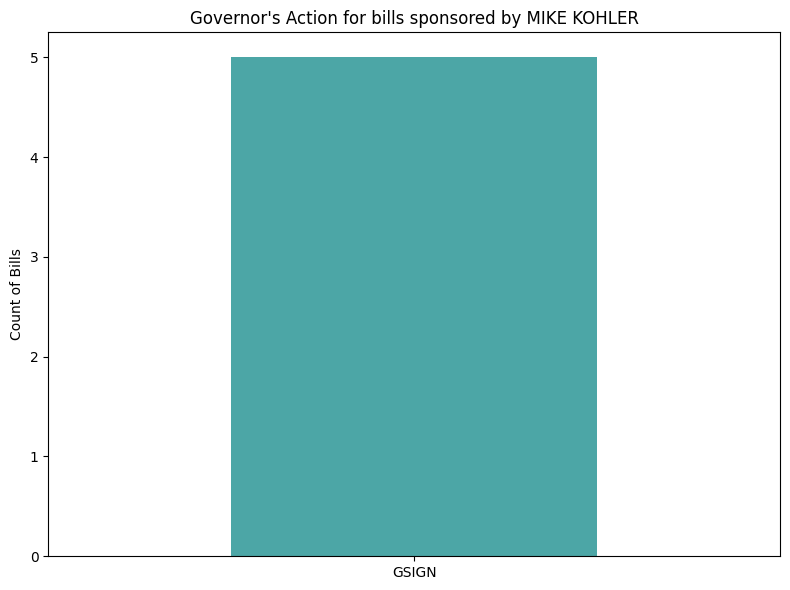

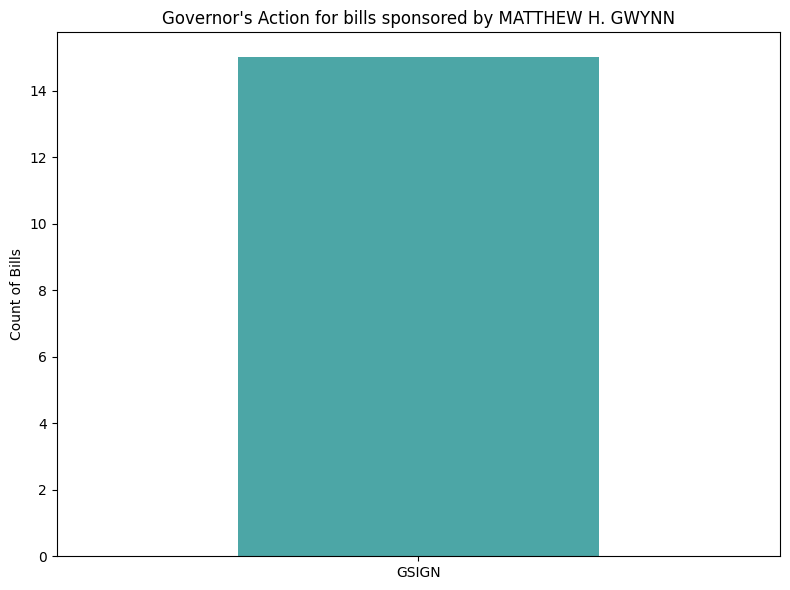

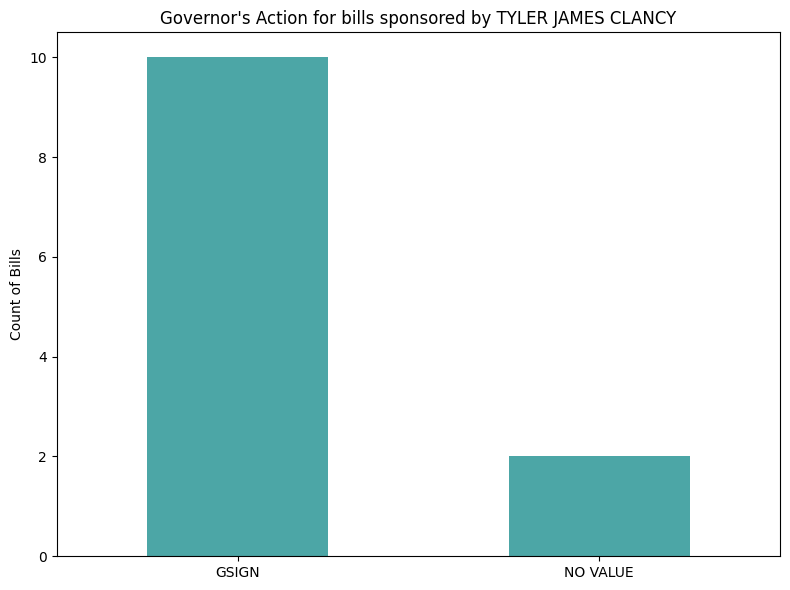

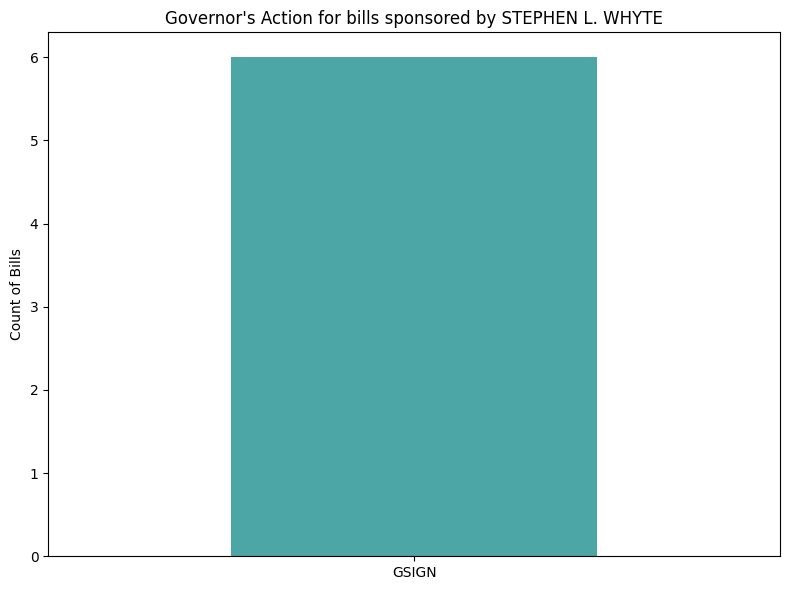

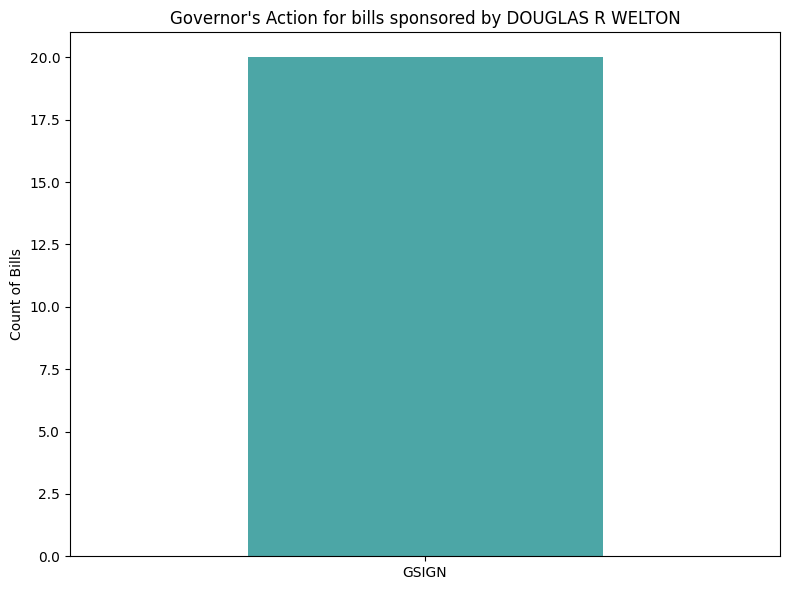

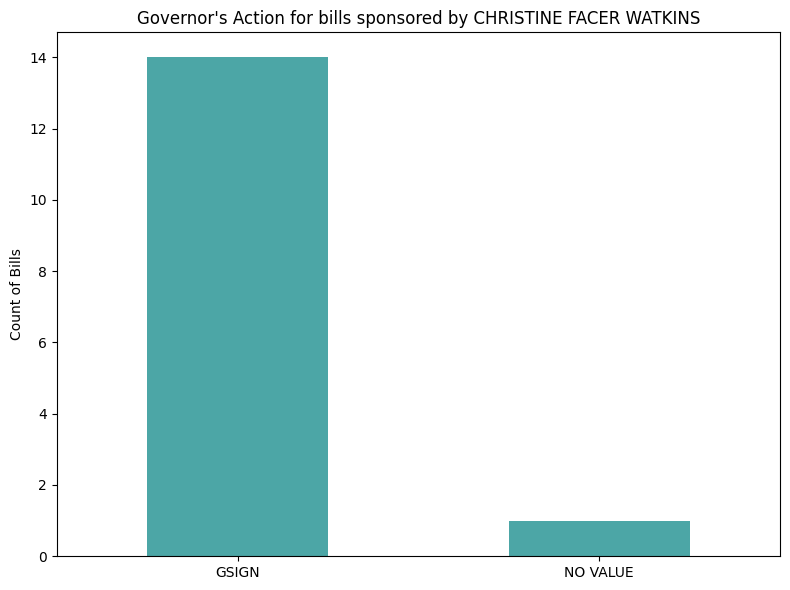

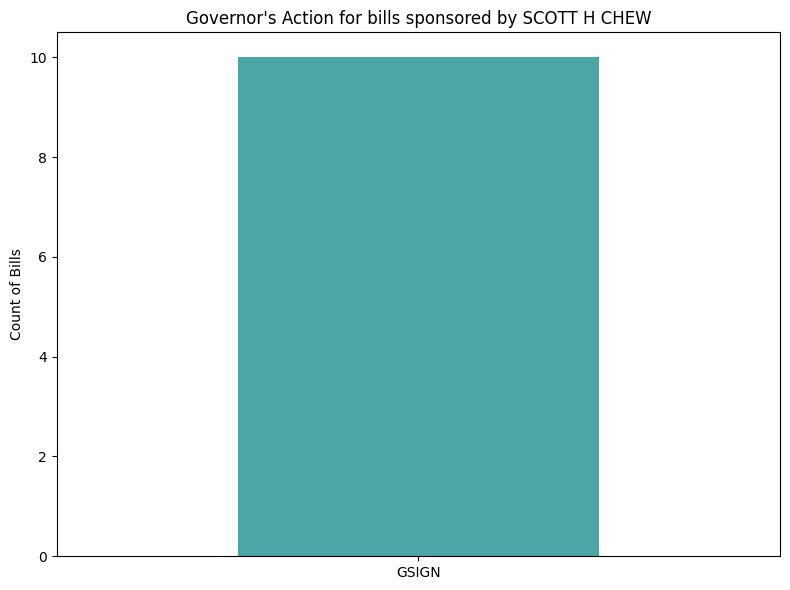

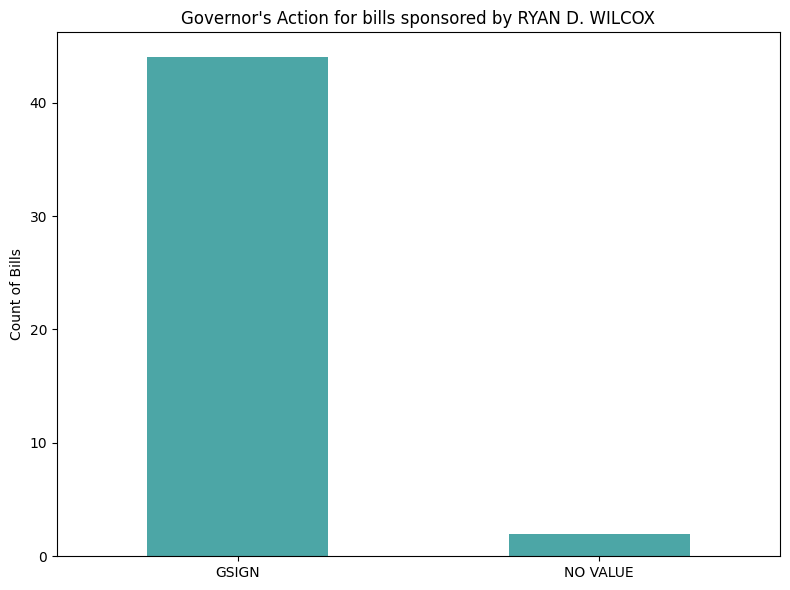

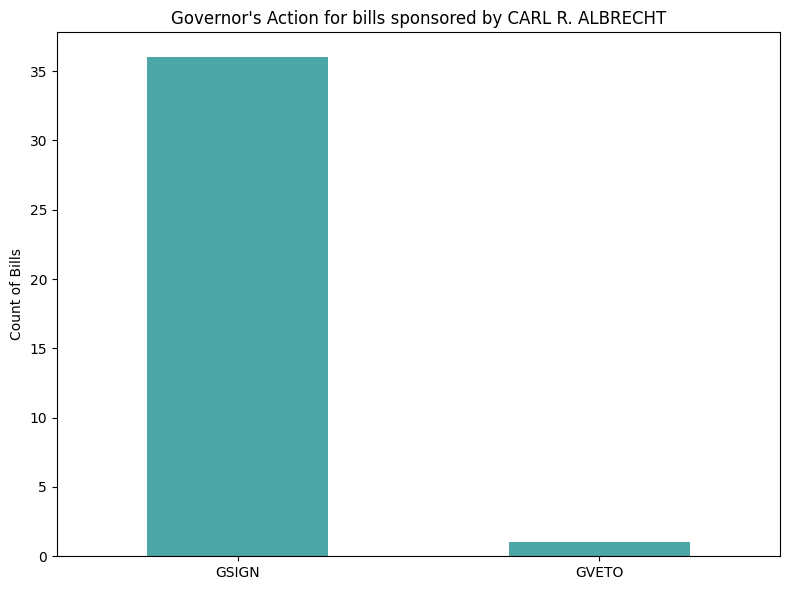

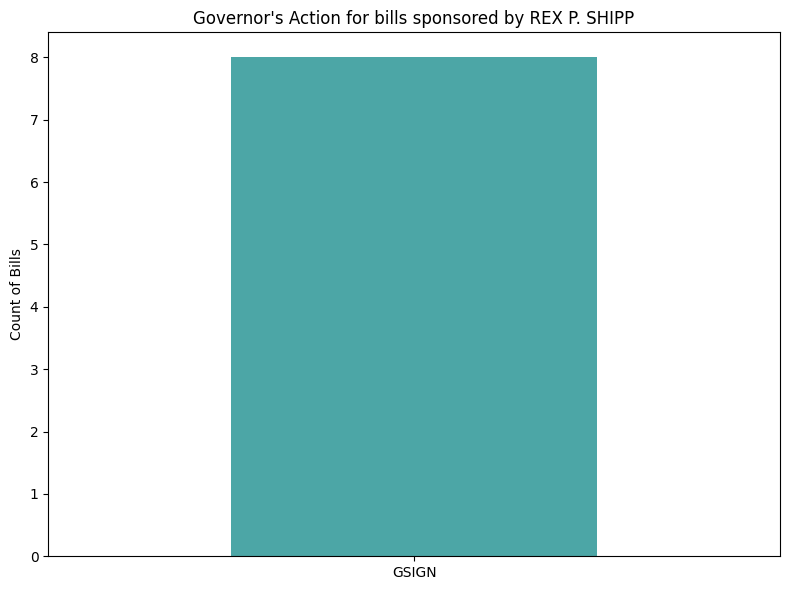

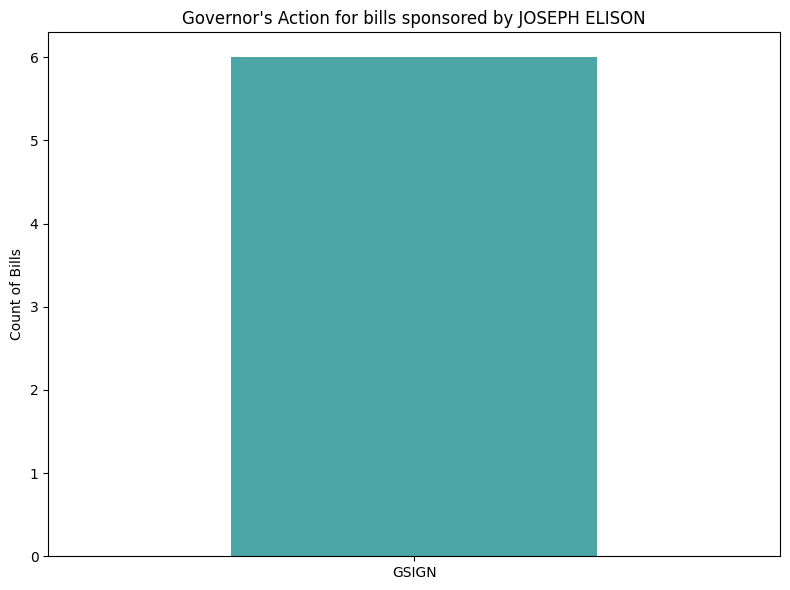

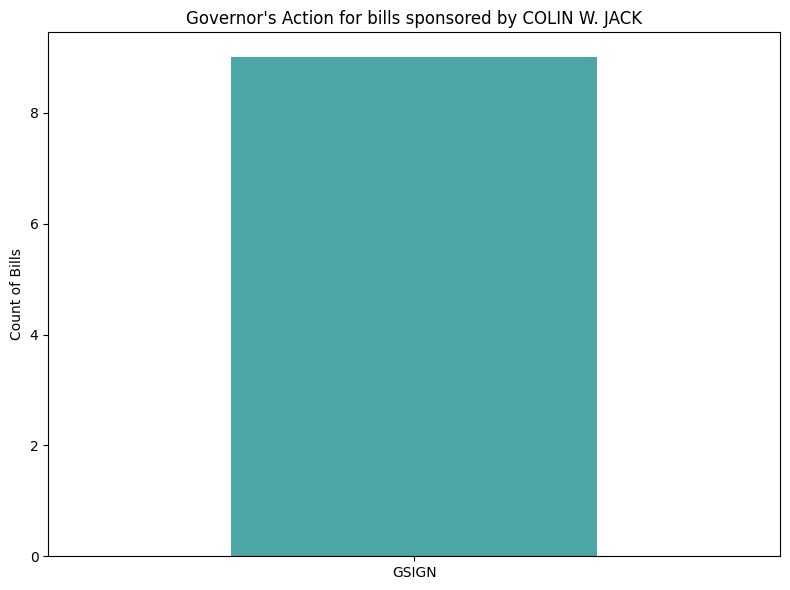

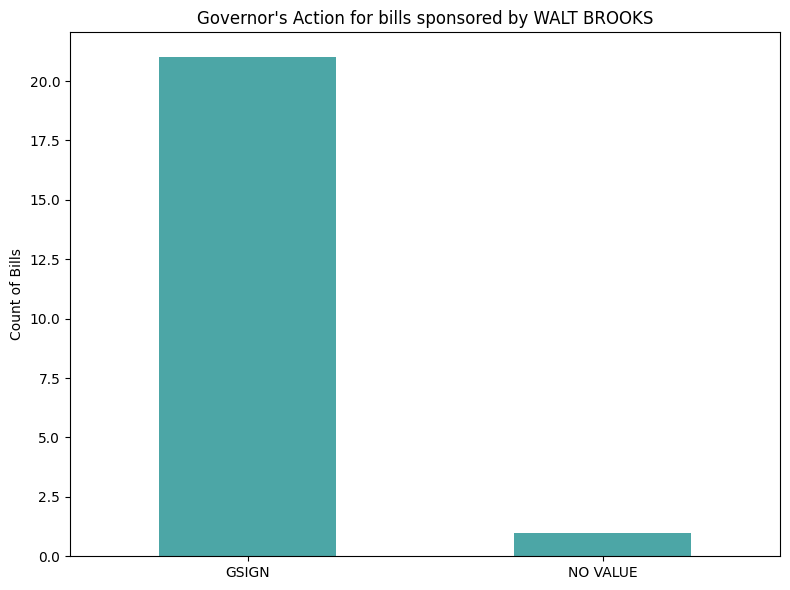

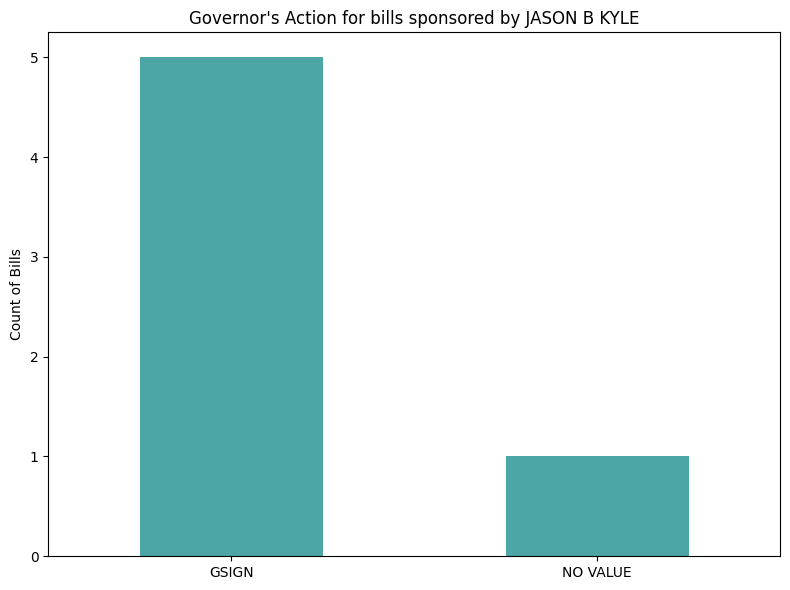

In [6]:
# lets look at the goverenor's actions for each candidate

import matplotlib.pyplot as plt


candidates_with_bills = merged_df.loc[~merged_df['Bill Number'].isna()]
for candidate in candidates_with_bills['Name on Ballot'].unique():

  candidate_bills = candidates_with_bills[candidates_with_bills['Name on Ballot'] == candidate]
  action_counts = candidate_bills['Governor\'s Action'].value_counts()

  fig, ax = plt.subplots(figsize=(8, 6))
  action_counts.plot(kind='bar', ax=ax, color='teal', alpha=0.7)
  ax.set_xlabel('')
  ax.set_ylabel('Count of Bills')
  ax.set_title(f'Governor\'s Action for bills sponsored by {candidate}')
  ax.set_xticklabels(action_counts.index, rotation=0, ha='center')

  plt.tight_layout()
  plt.show()

In [7]:
merged_df.loc[merged_df['Name on Ballot'] == 'JASON B KYLE'][['Date Passed', 'Governor\'s Action']]

Date Passed Governor's Action
1267  2023-11-15          NO VALUE
1268  2023-02-10             GSIGN
1269  2023-02-21             GSIGN
1270  2024-02-28             GSIGN
1271  2024-03-01             GSIGN
1272  2024-03-01             GSIGN

# Timeline of bills for each candidate

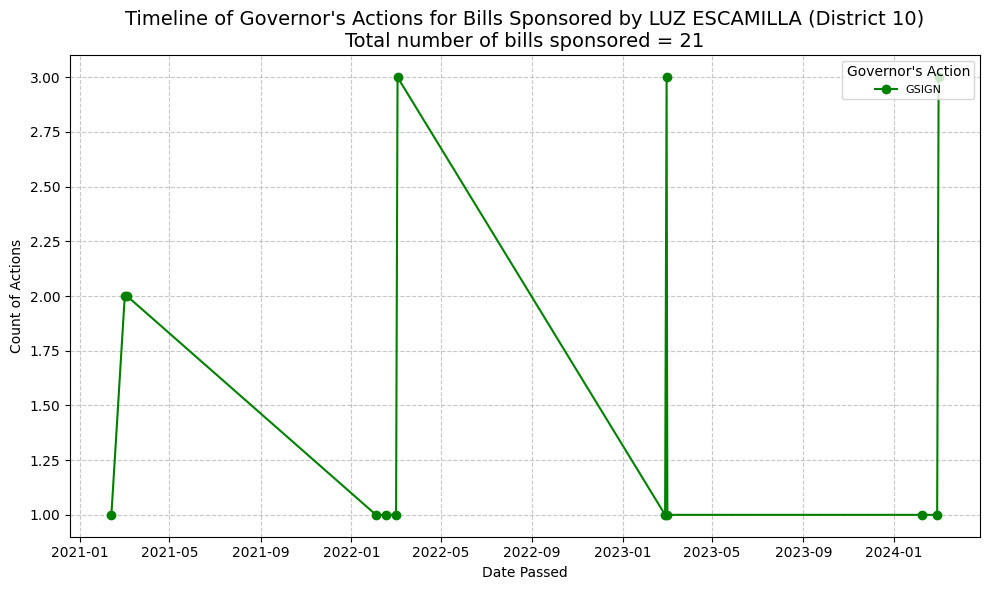

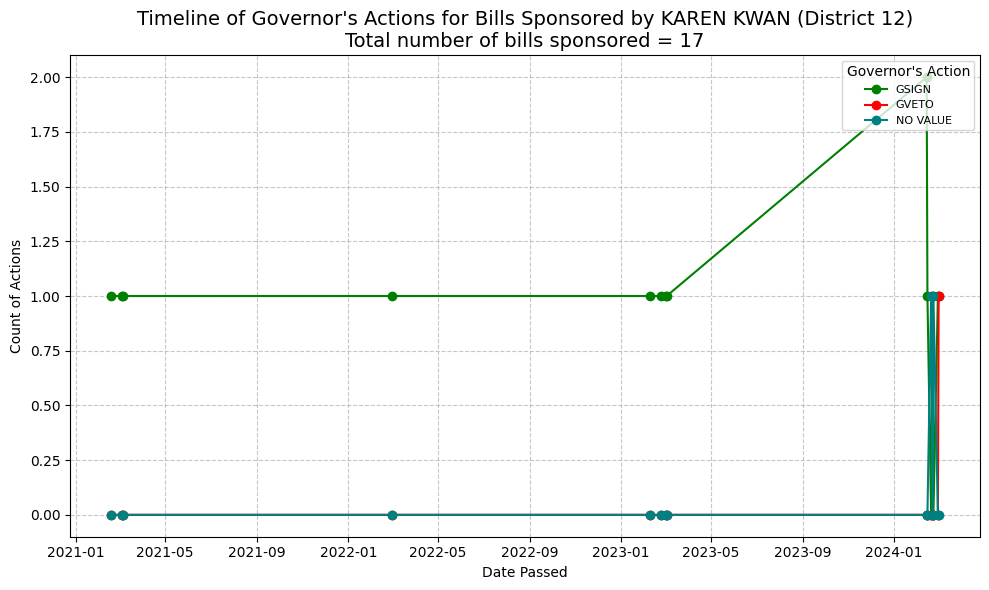

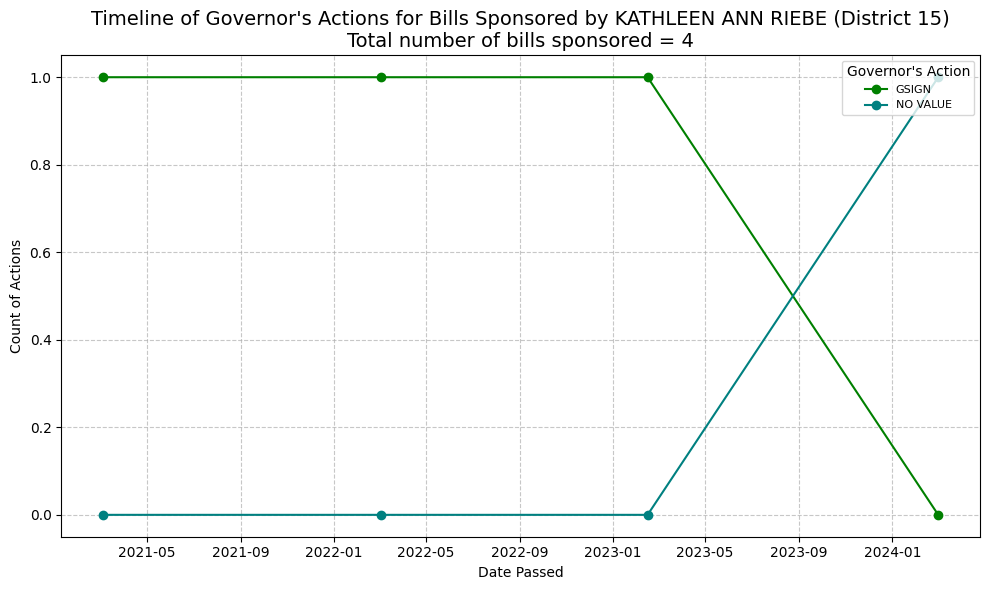

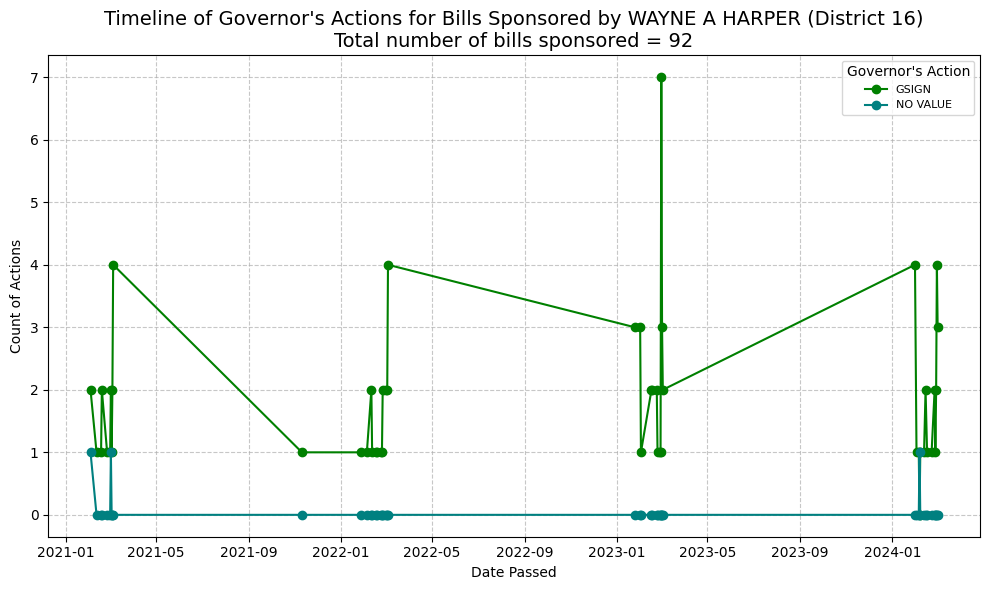

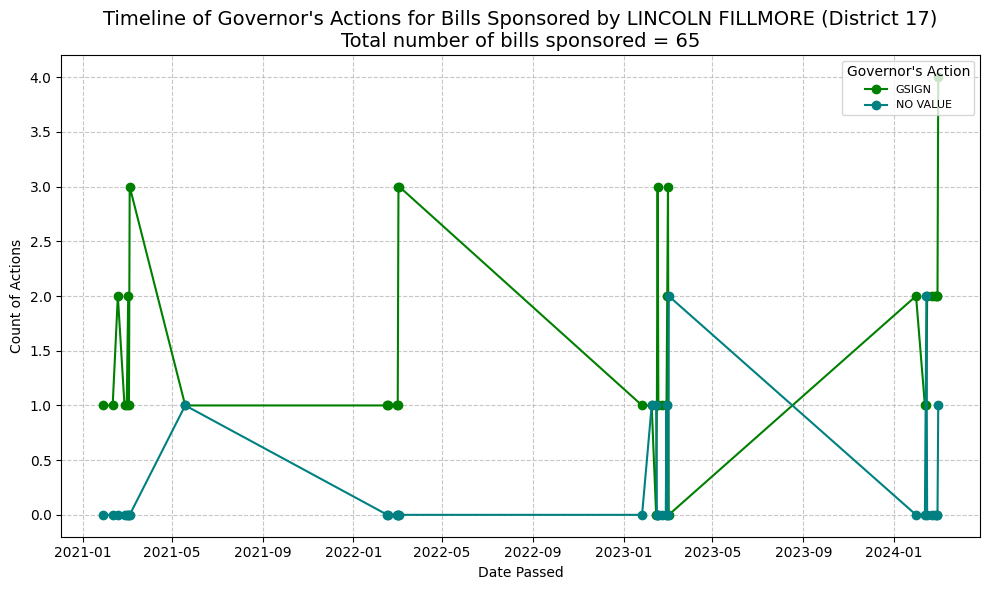

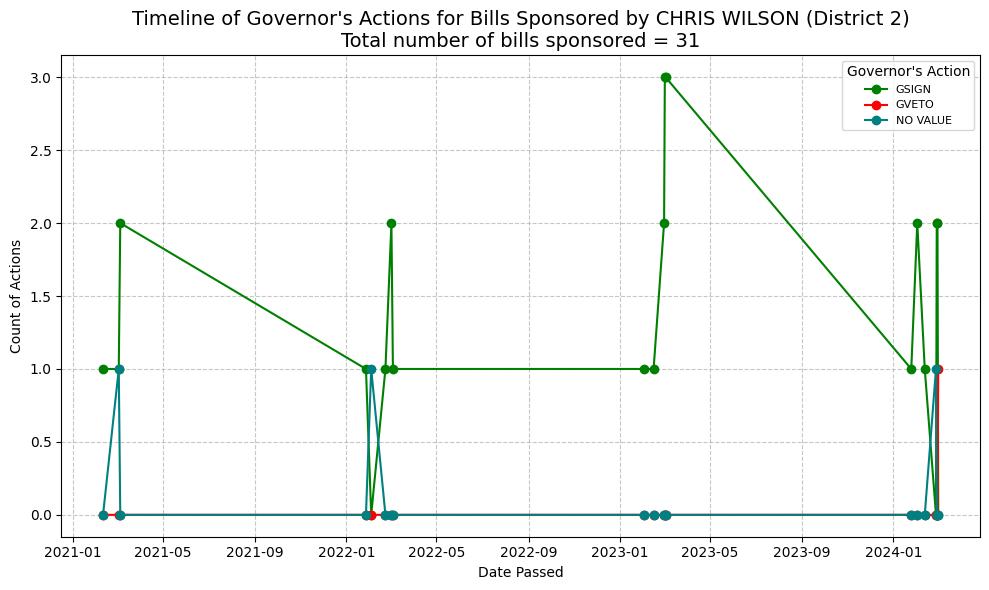

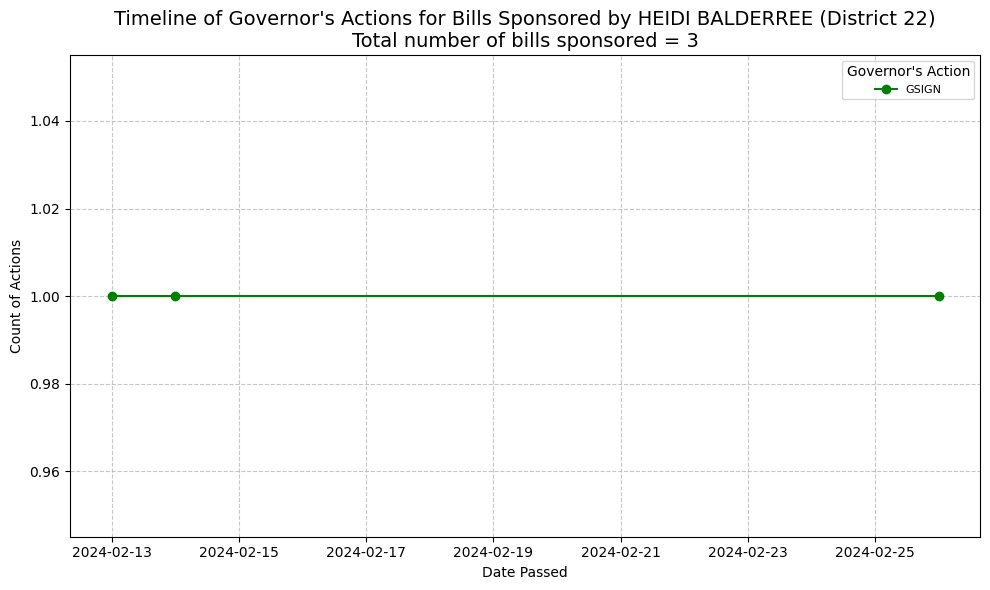

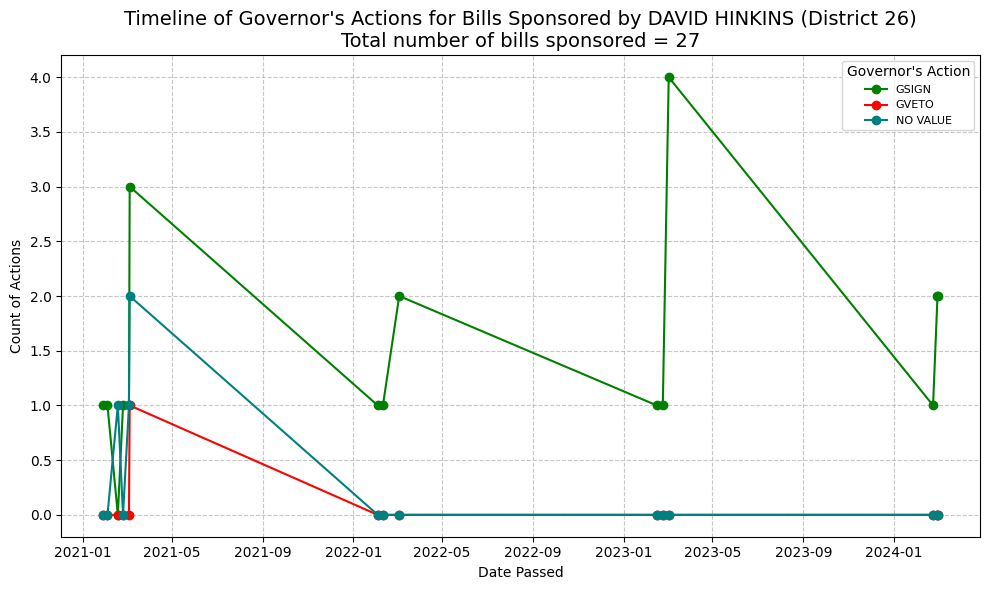

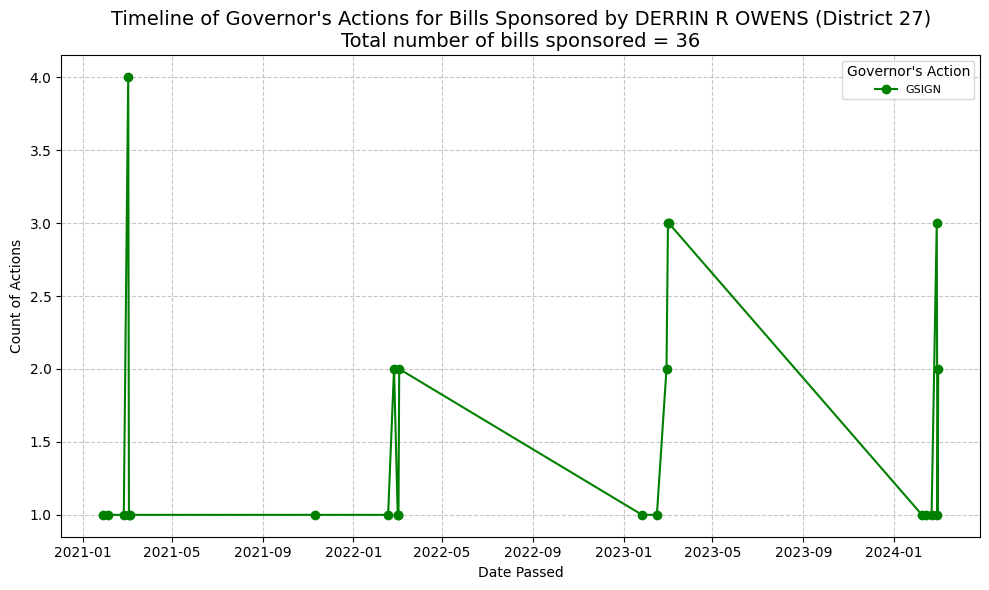

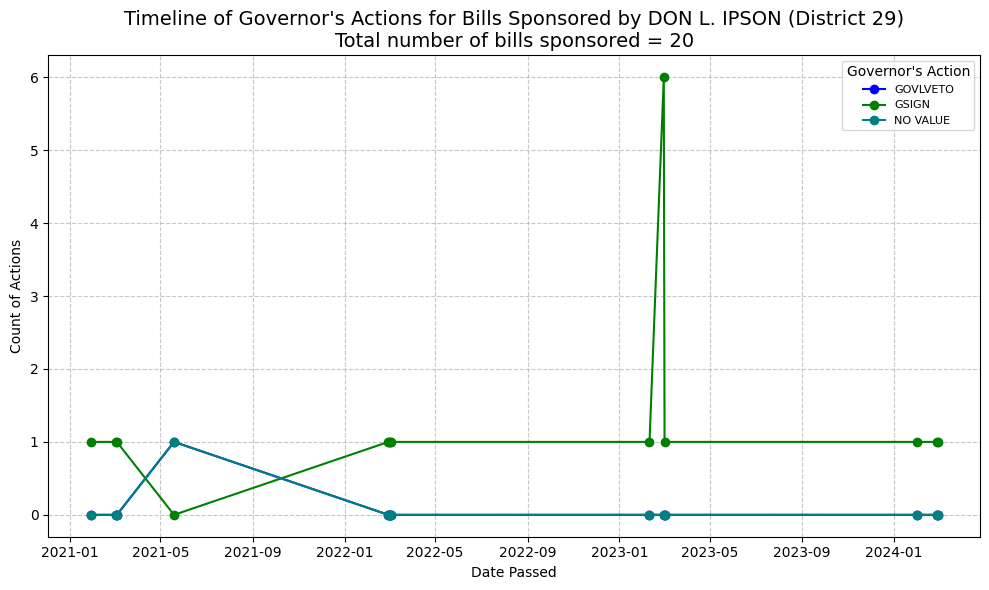

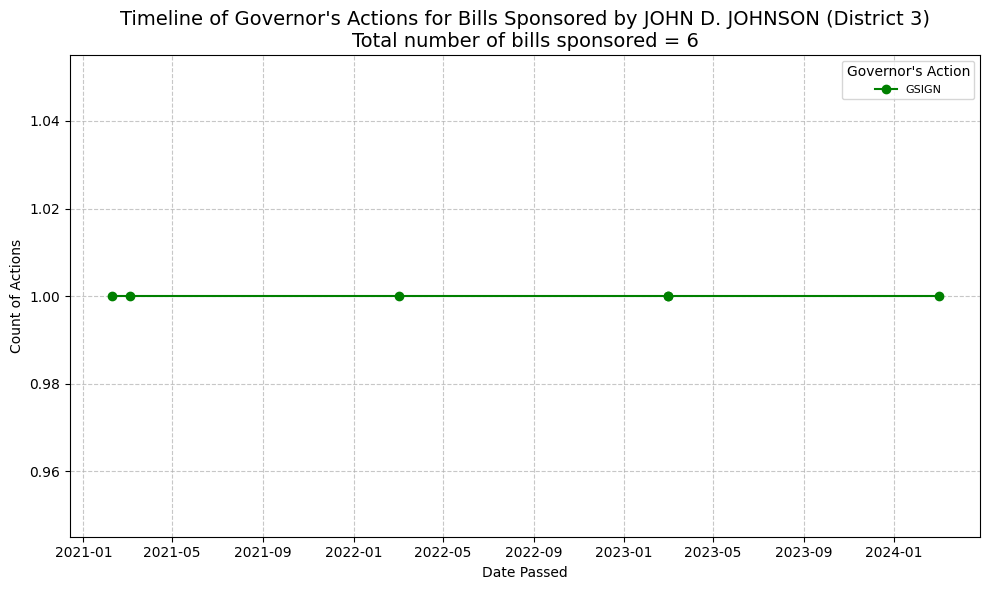

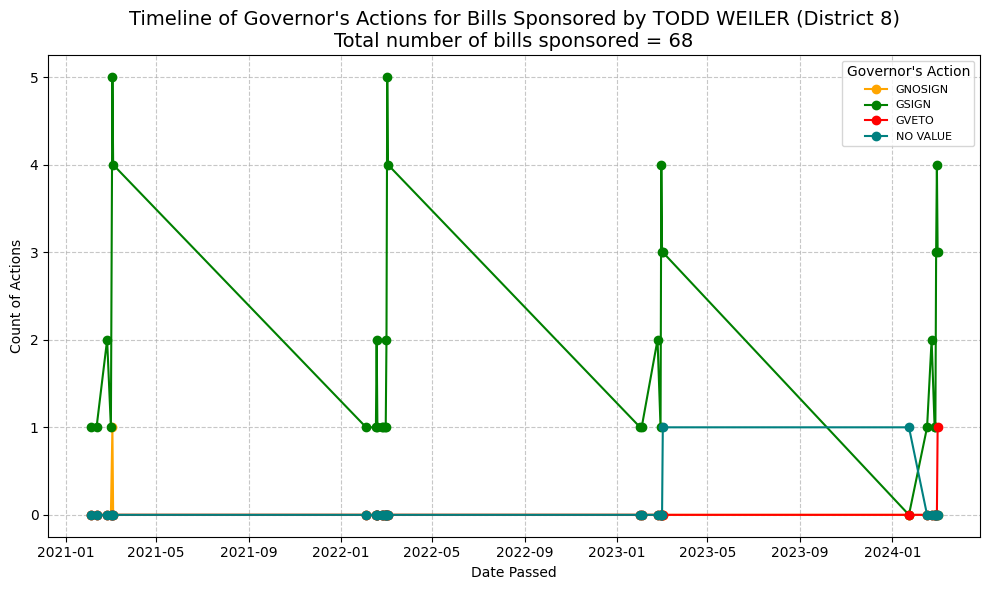

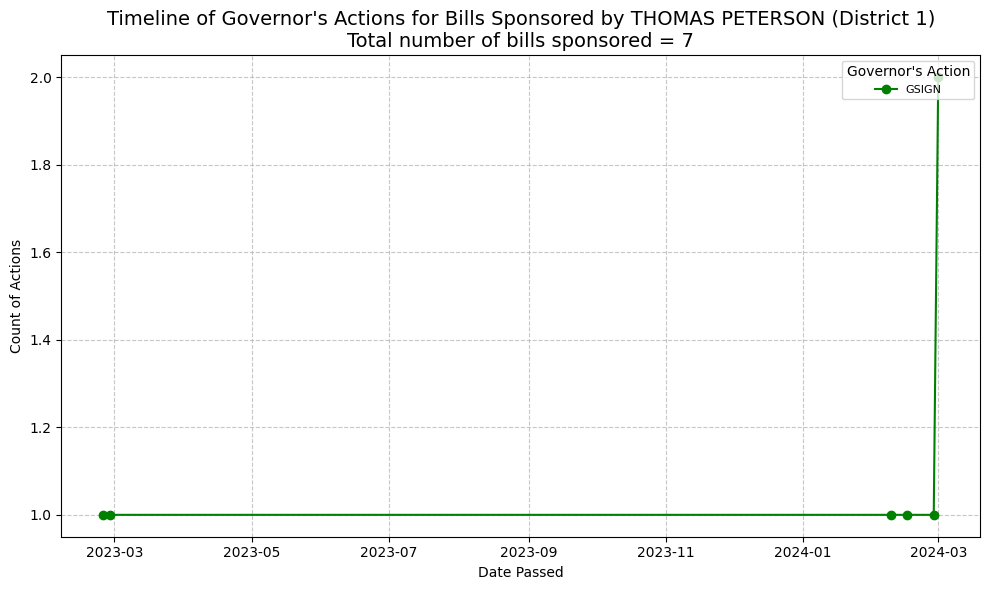

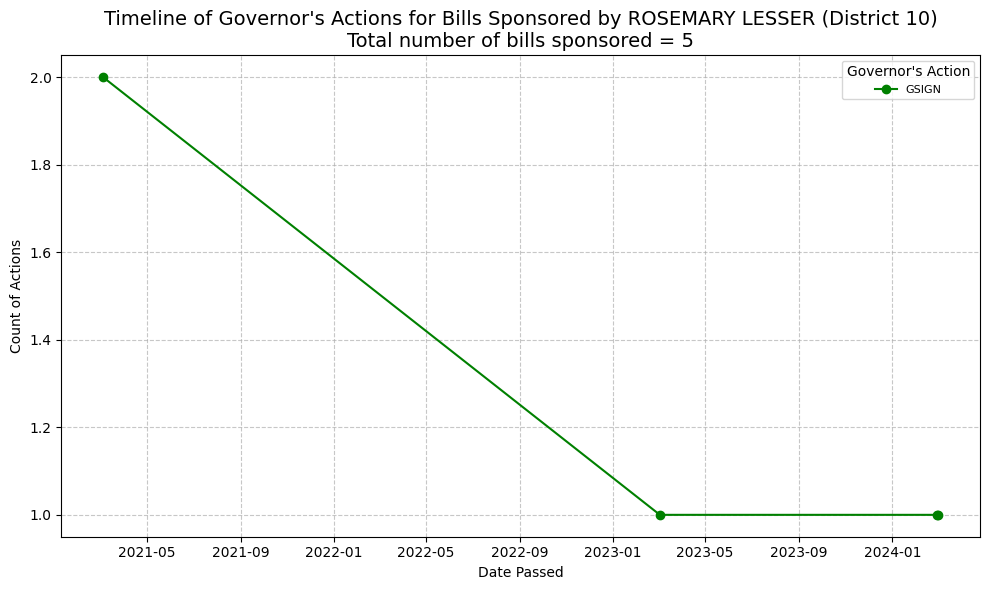

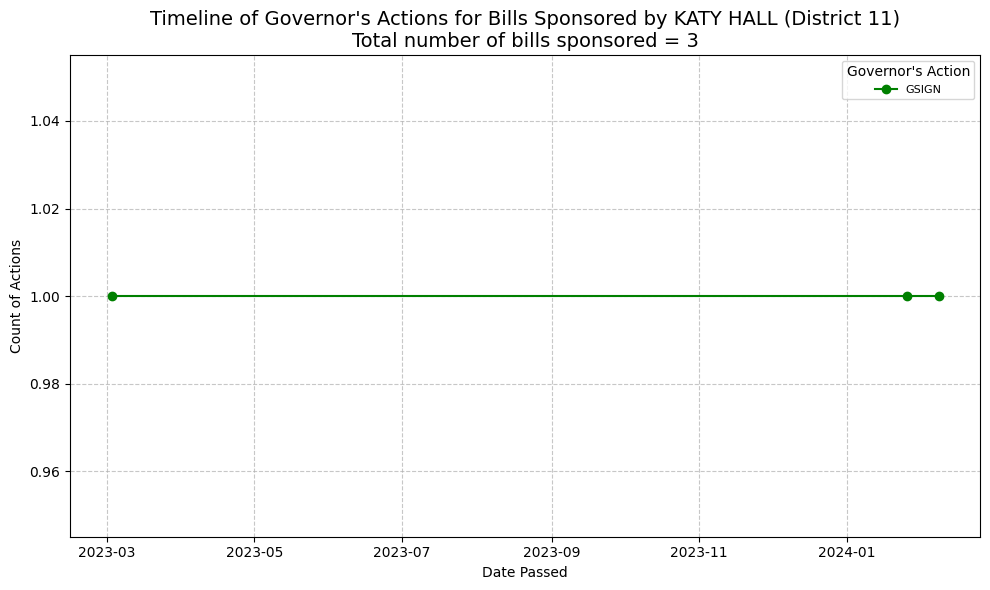

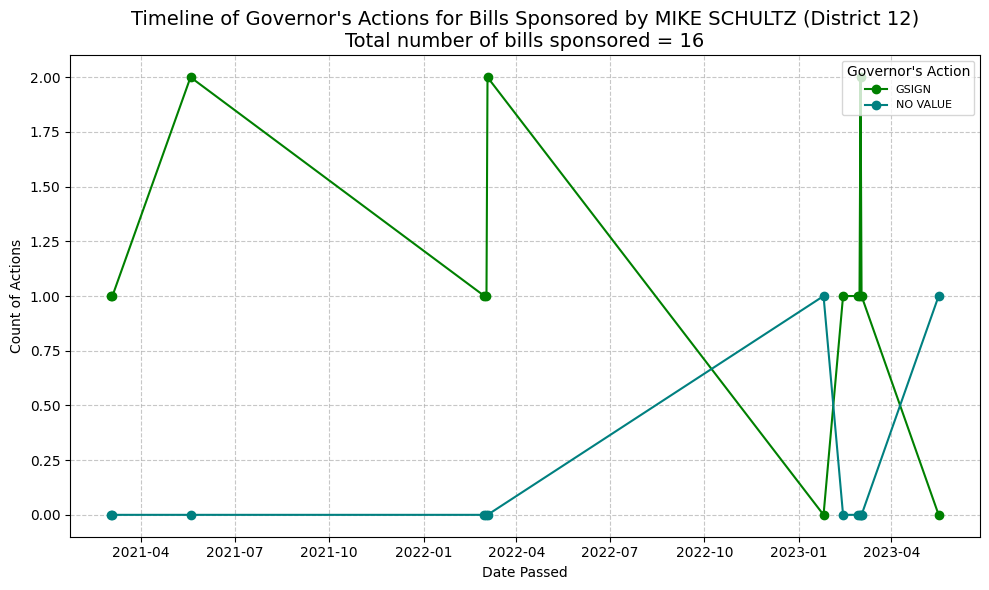

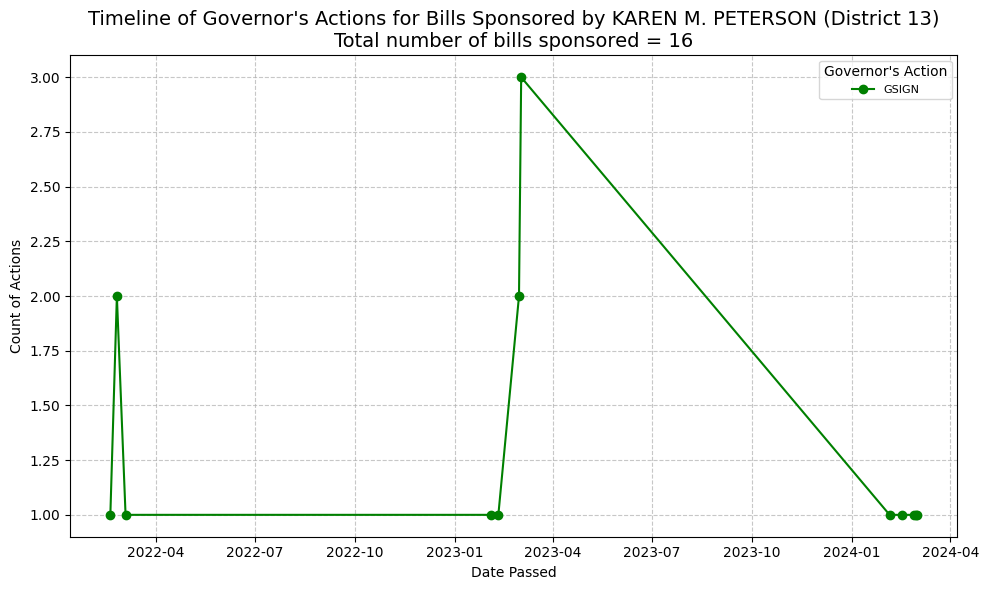

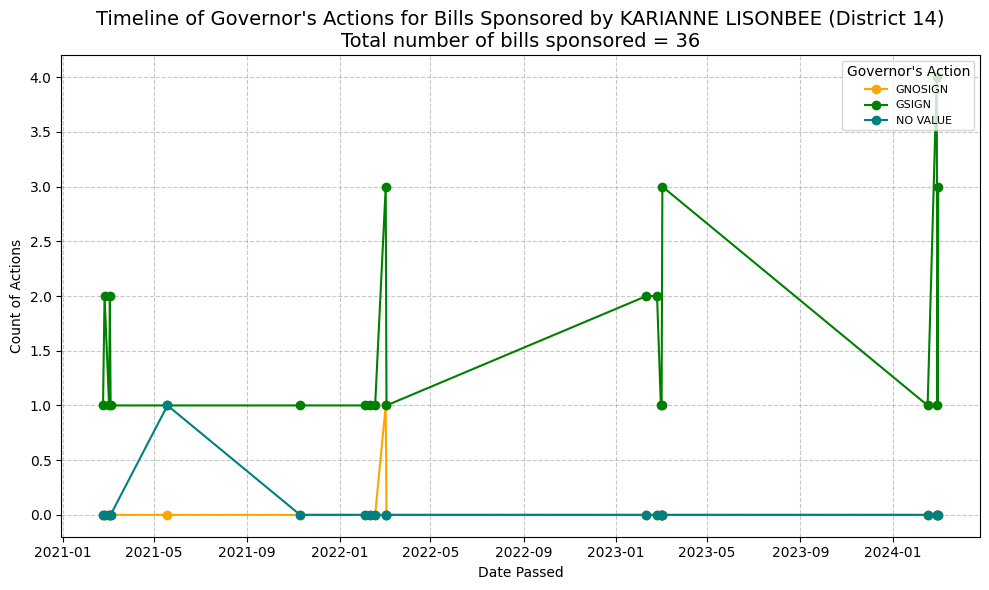

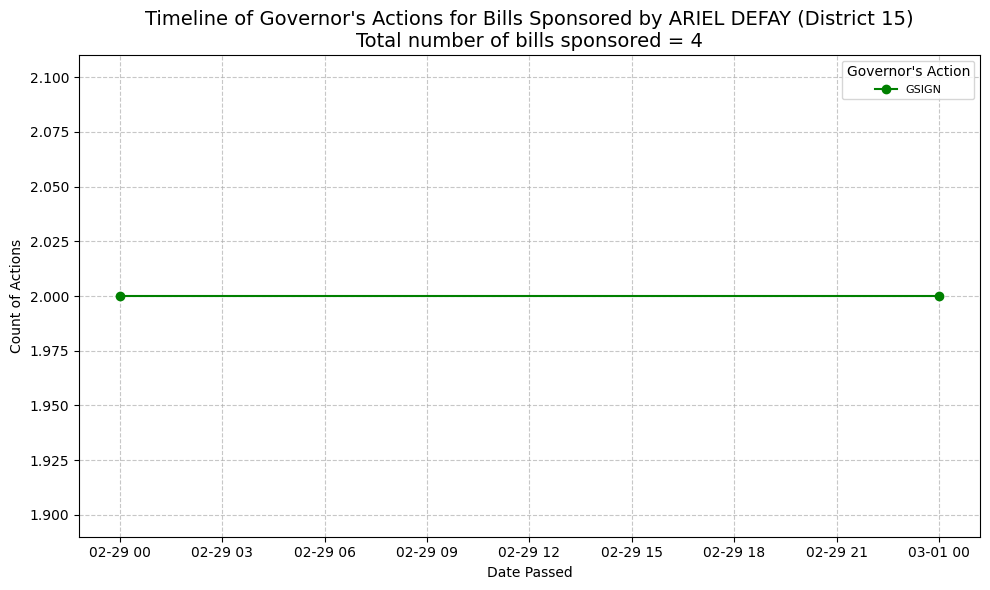

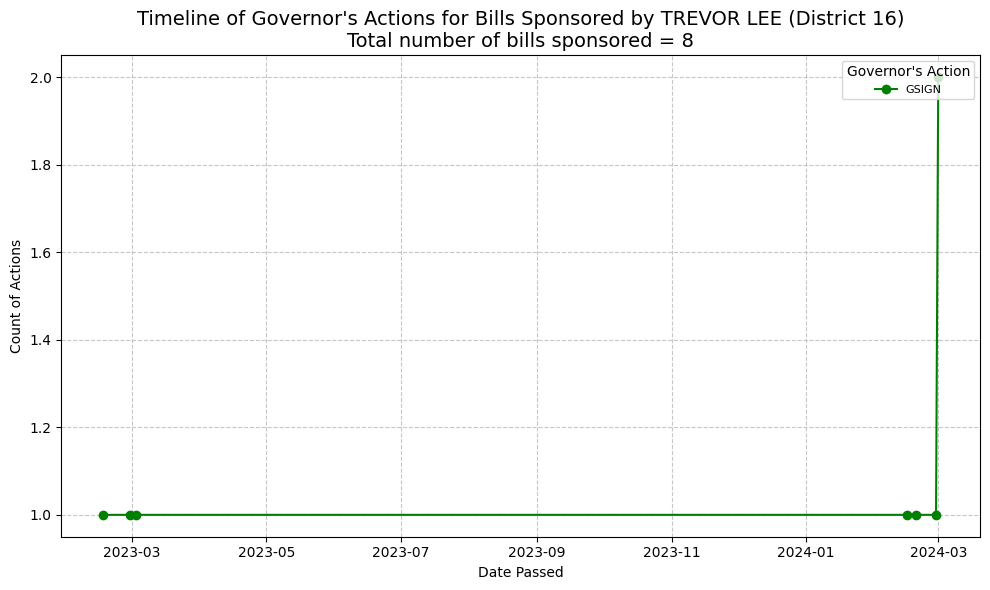

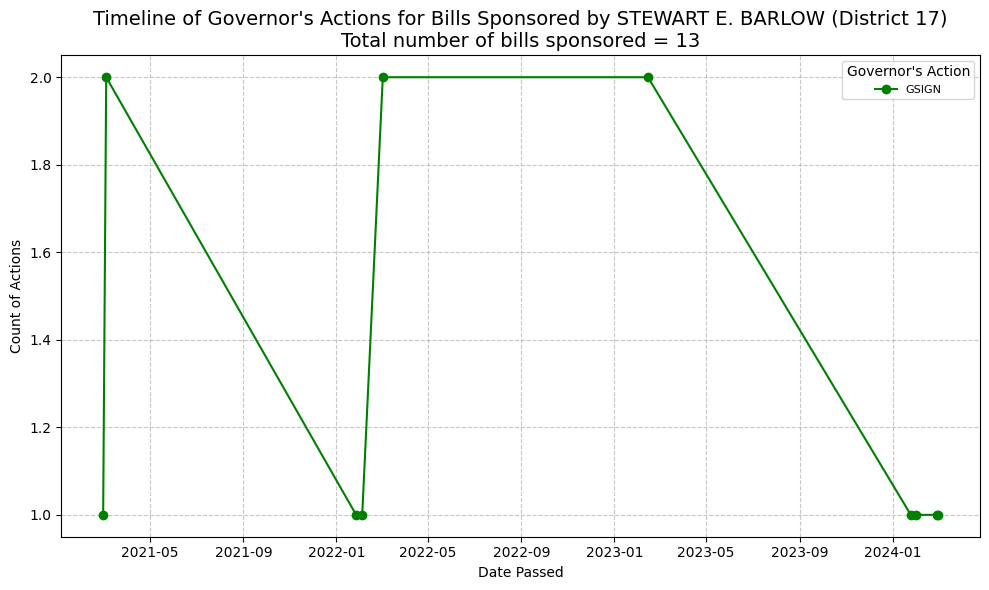

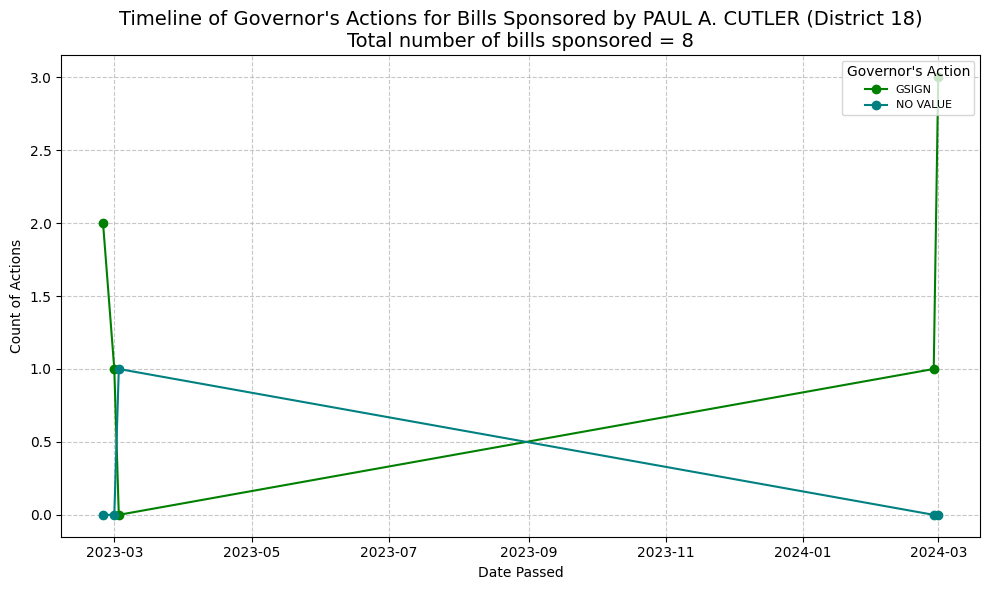

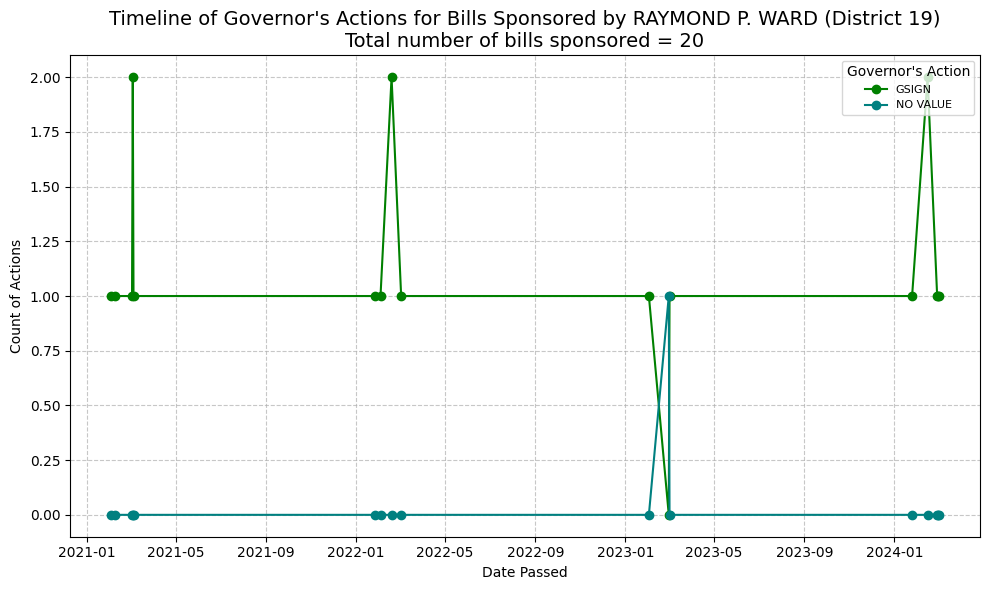

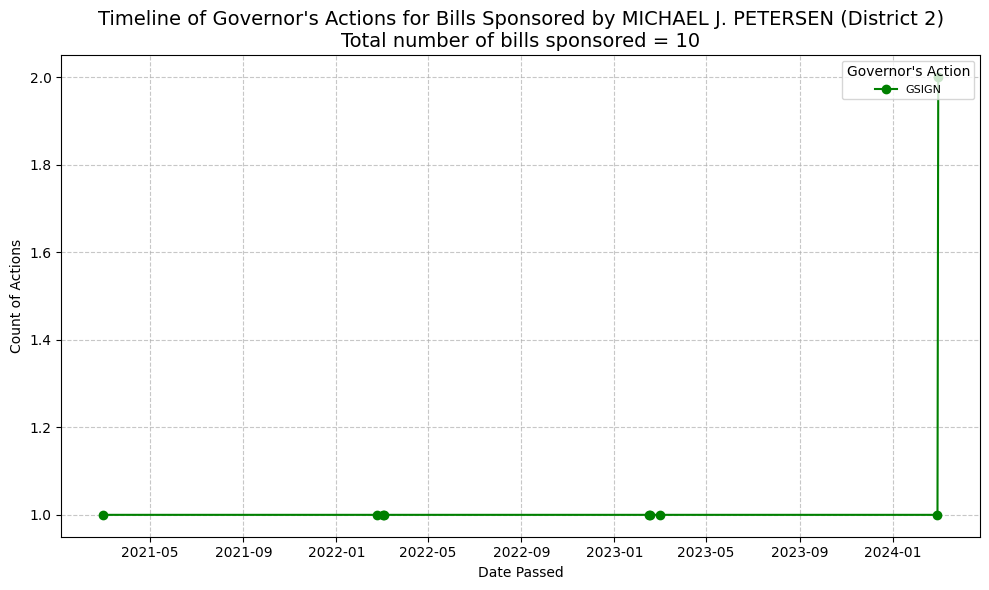

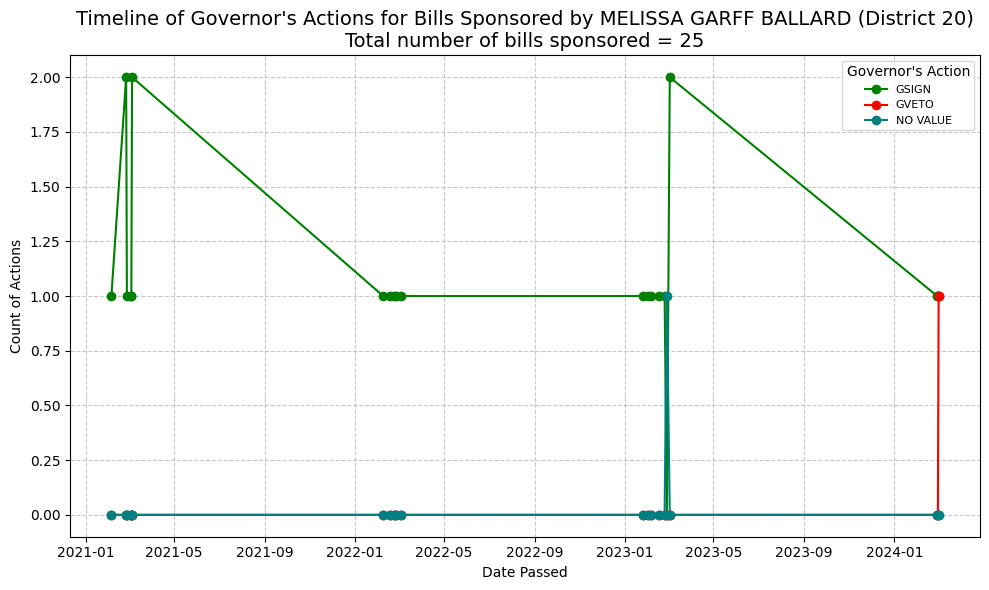

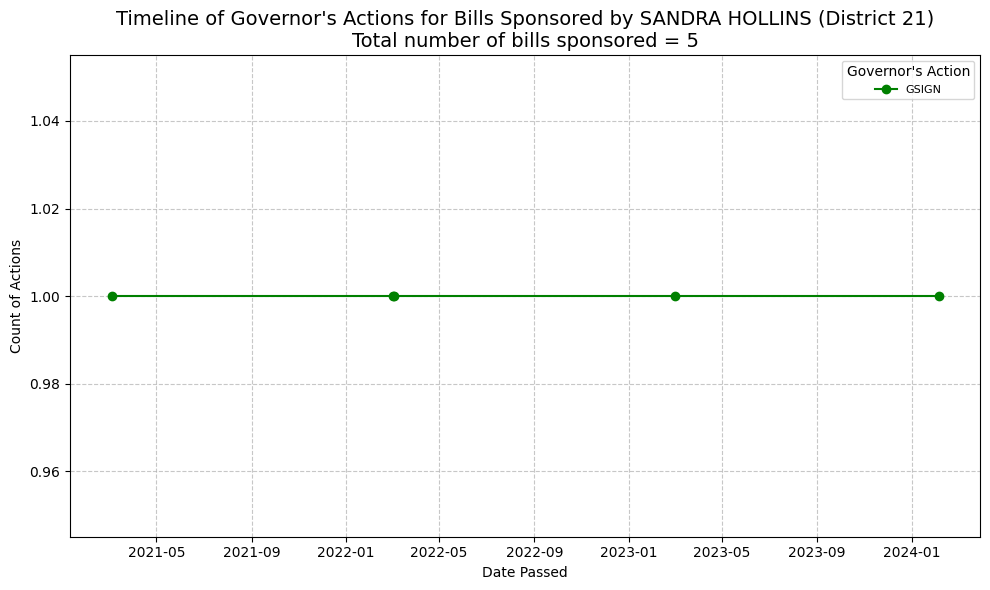

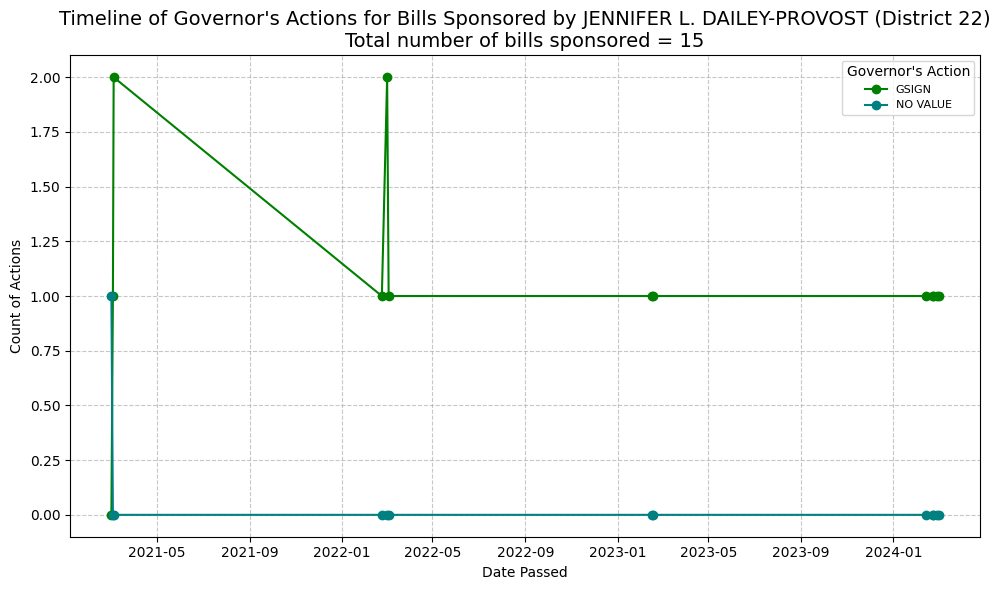

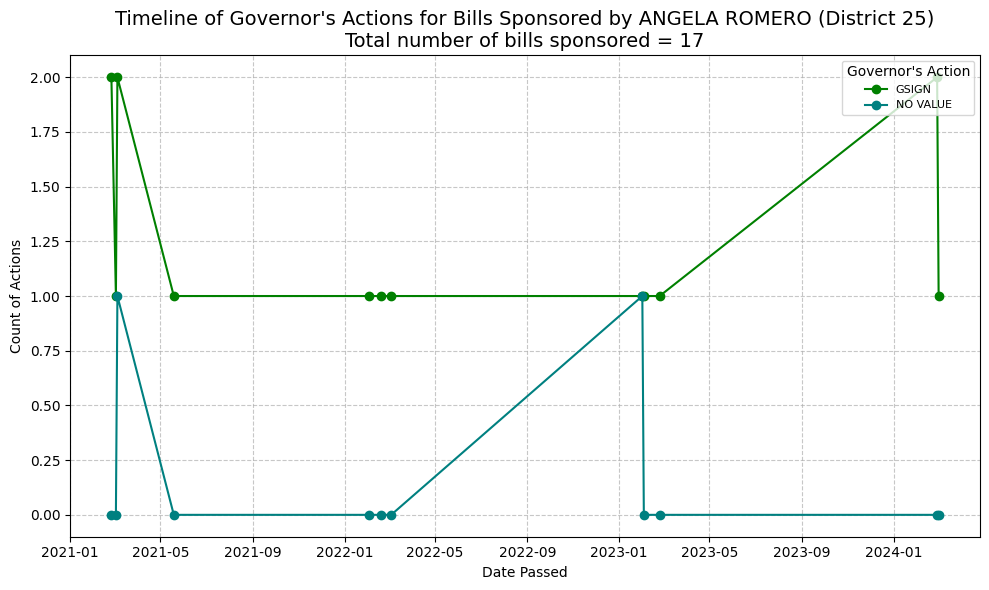

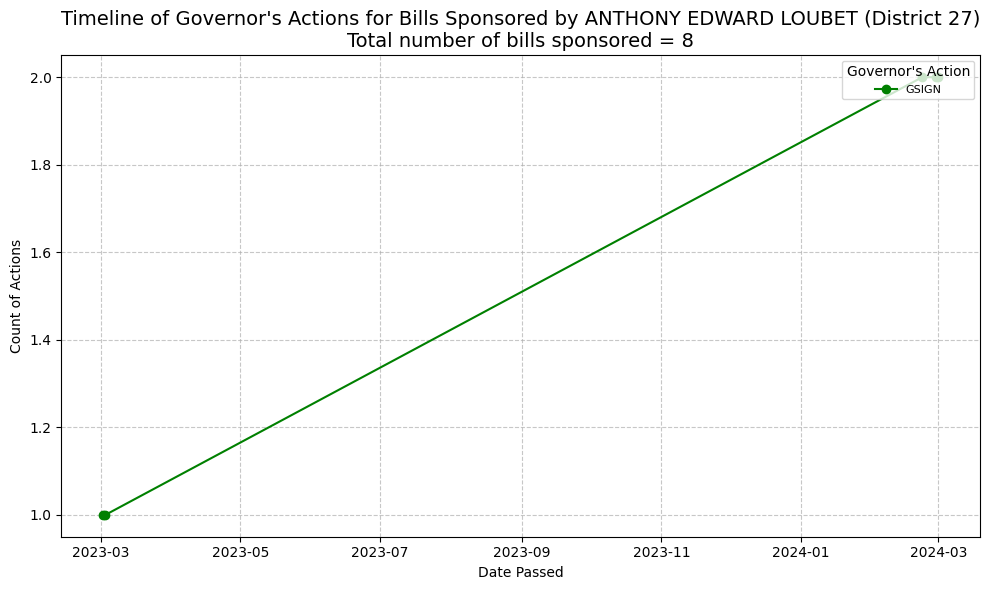

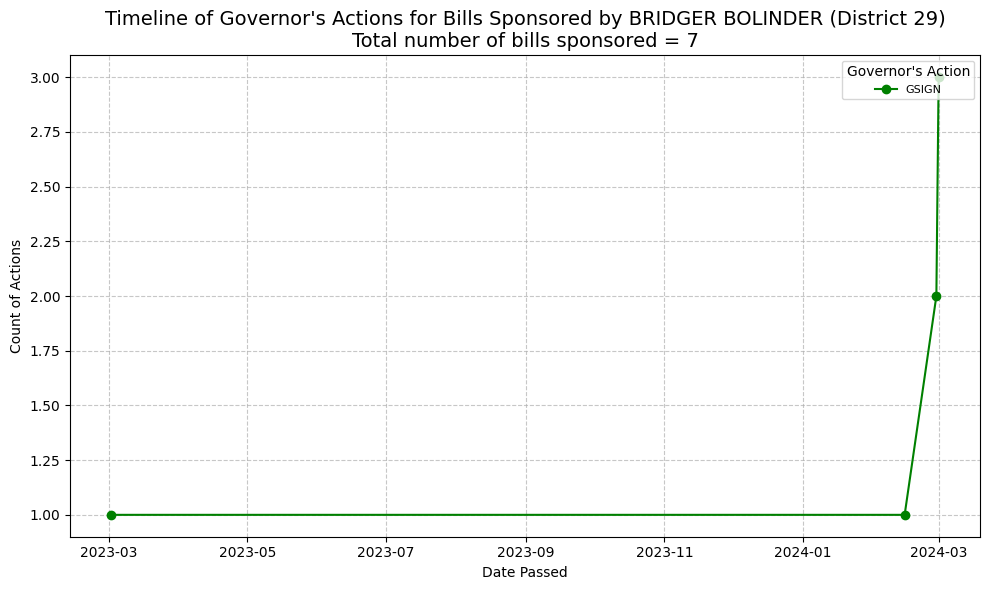

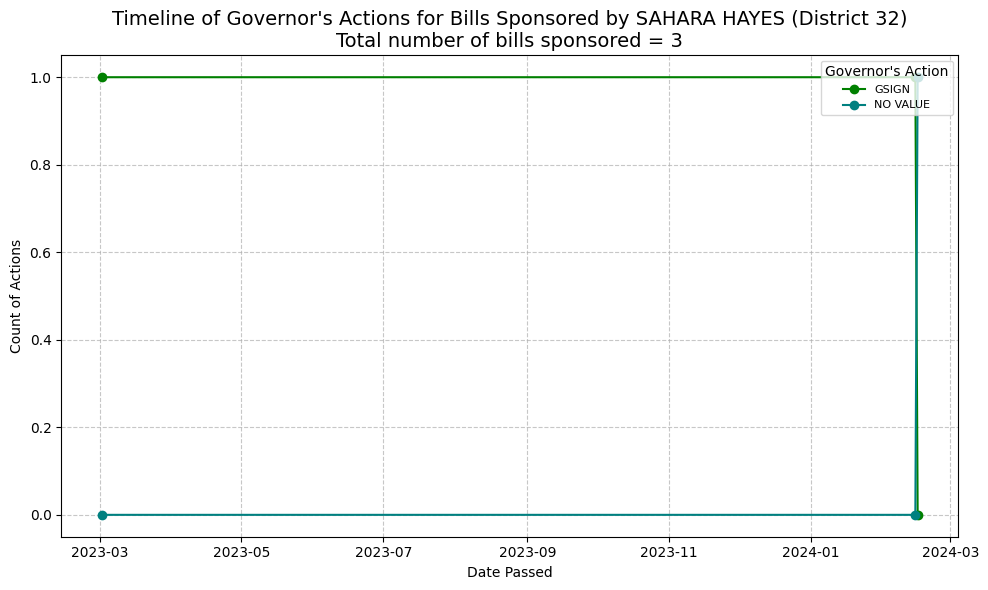

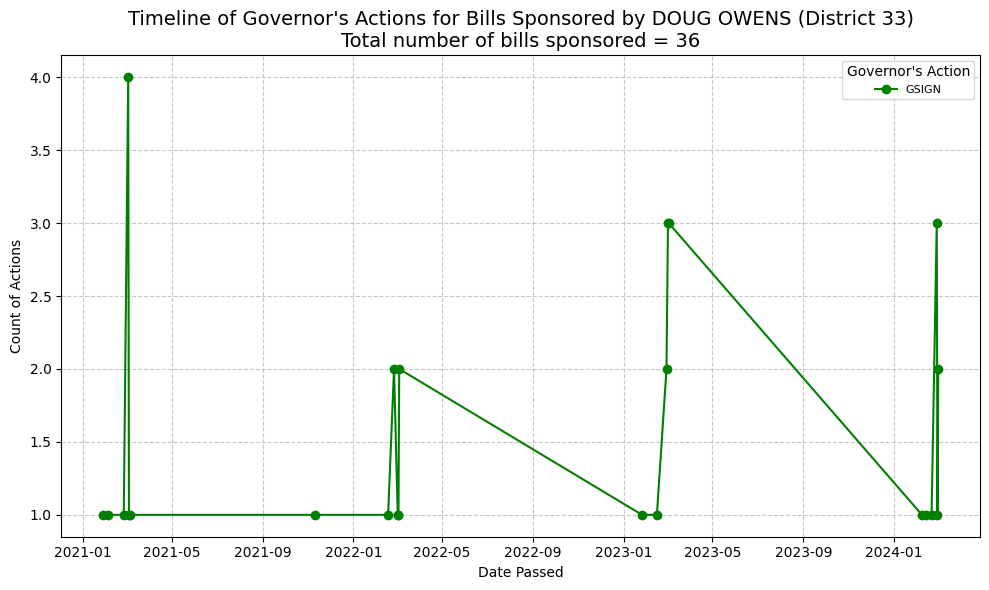

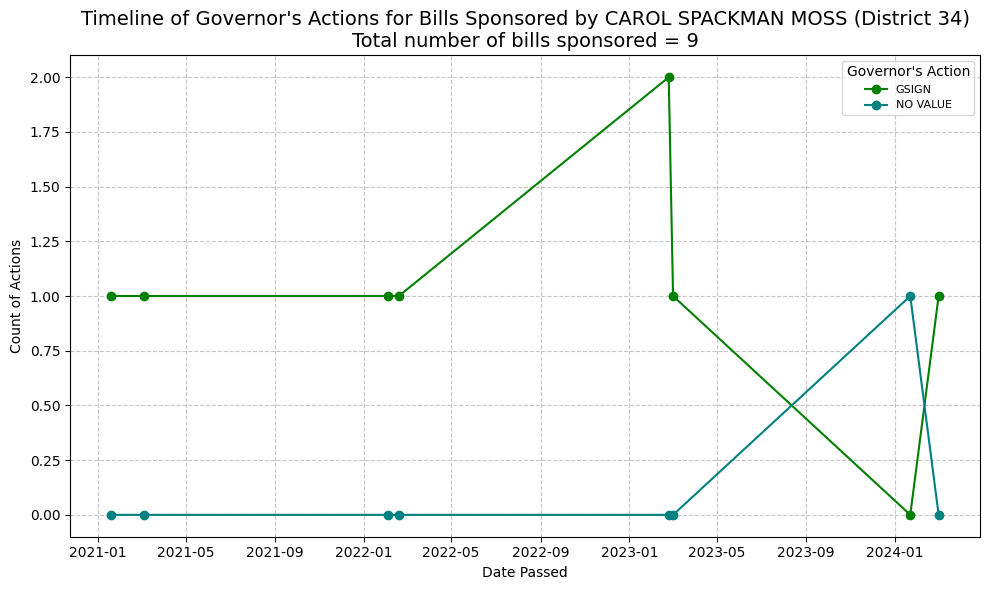

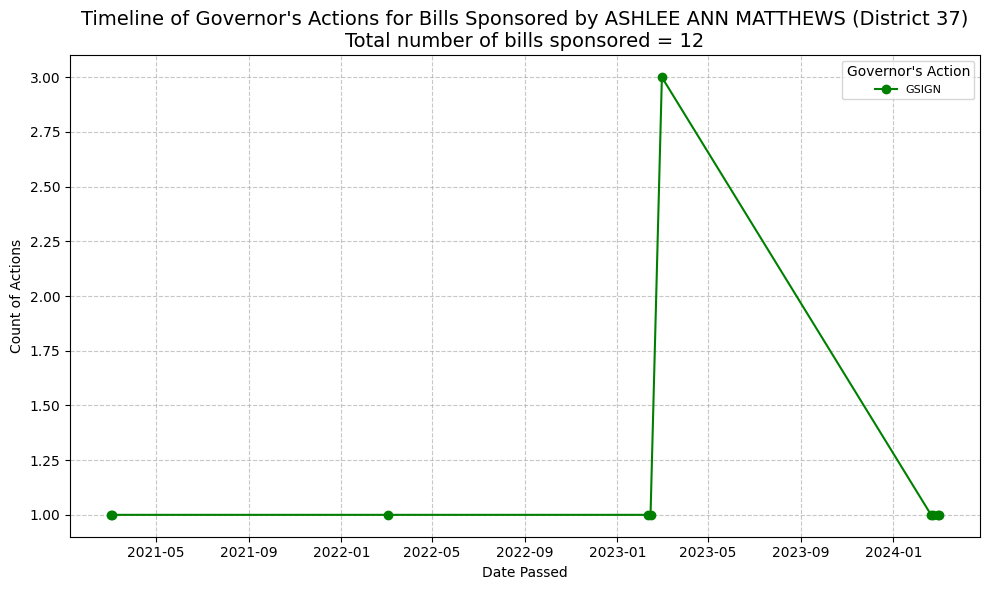

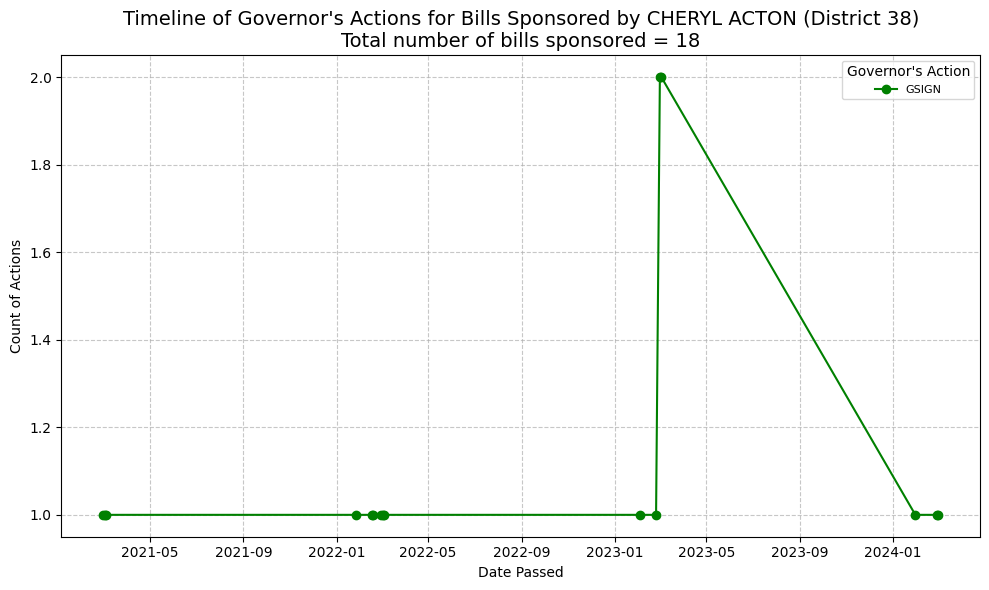

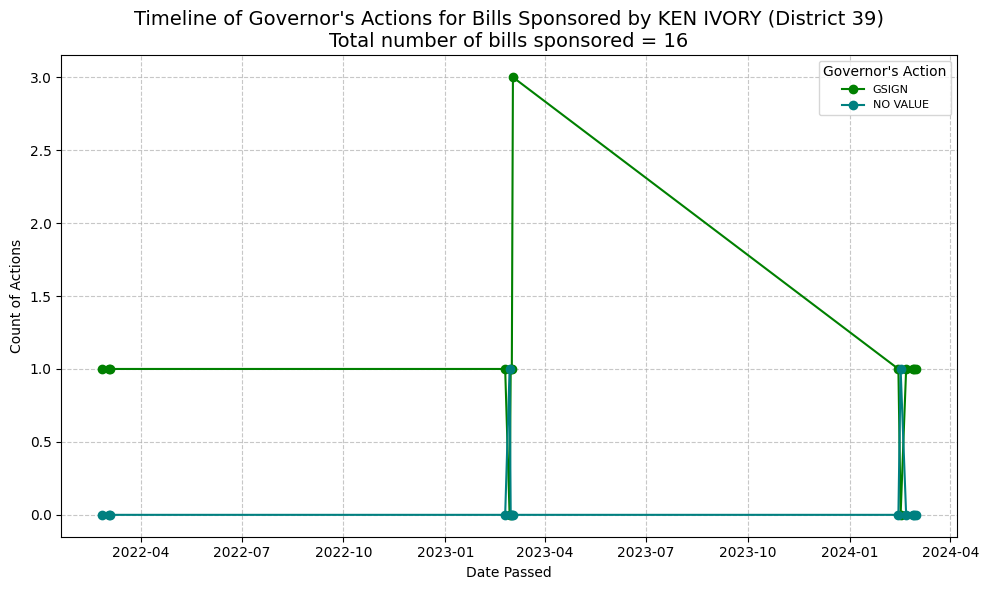

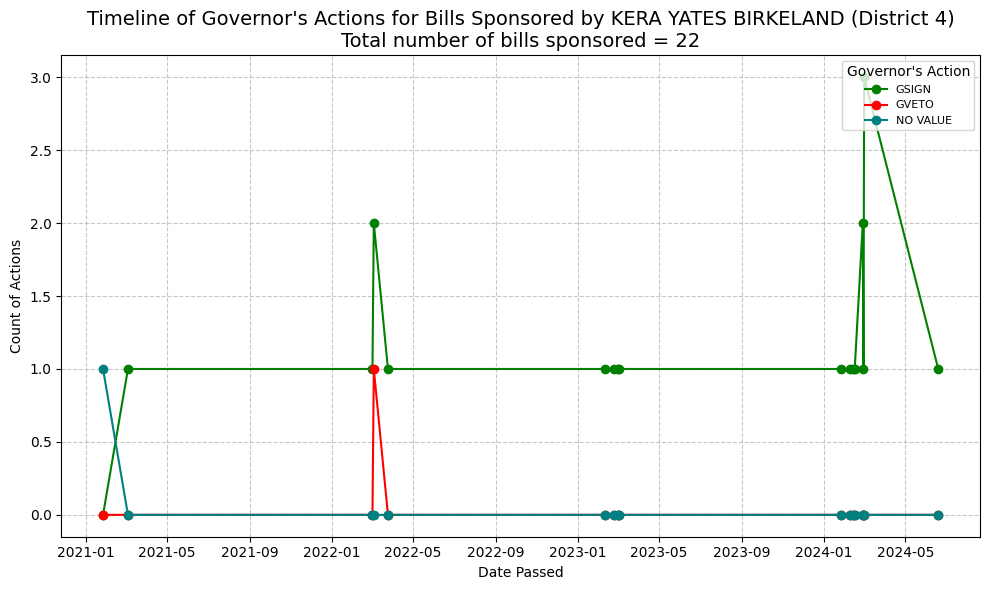

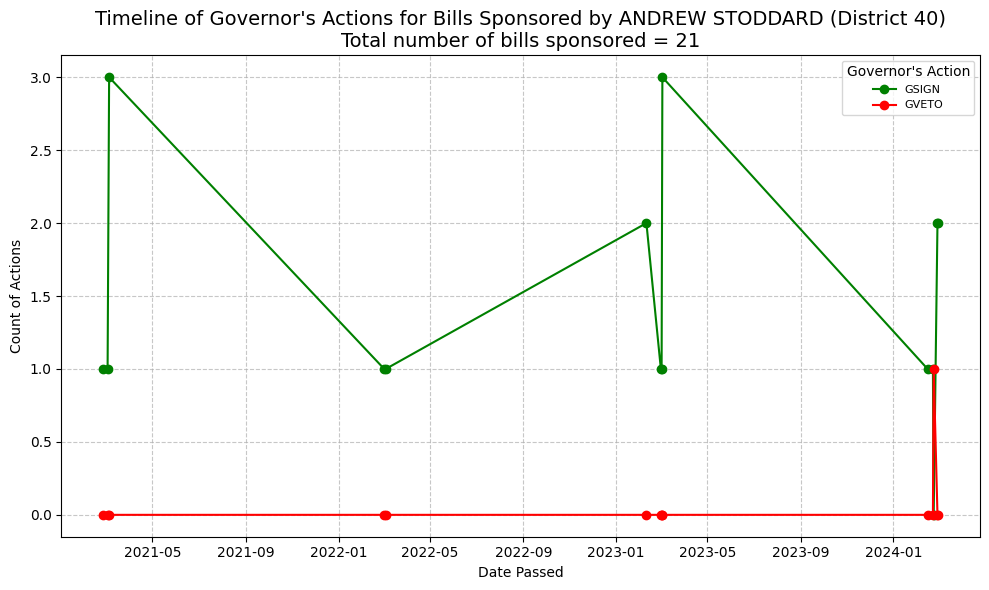

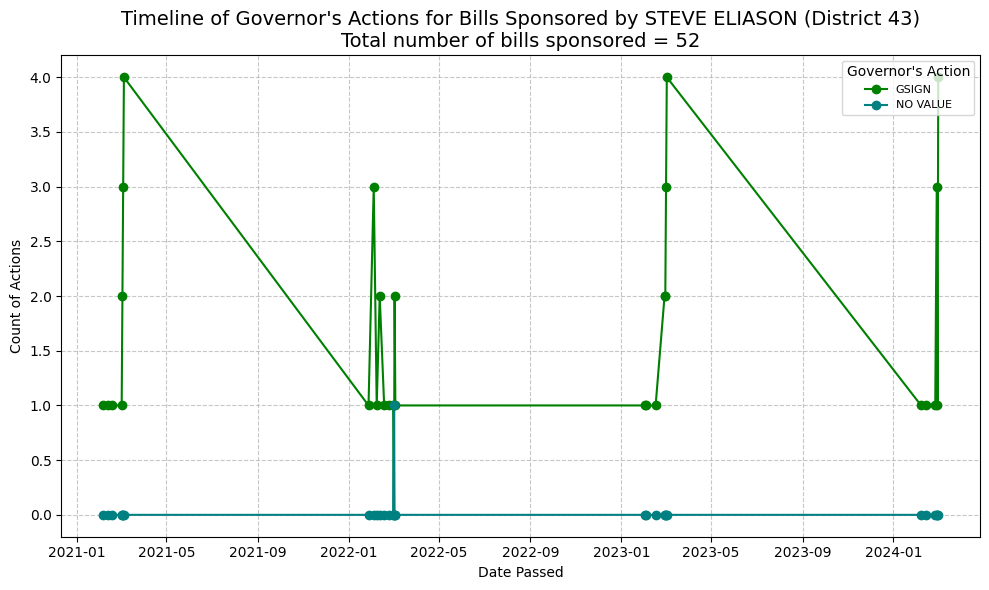

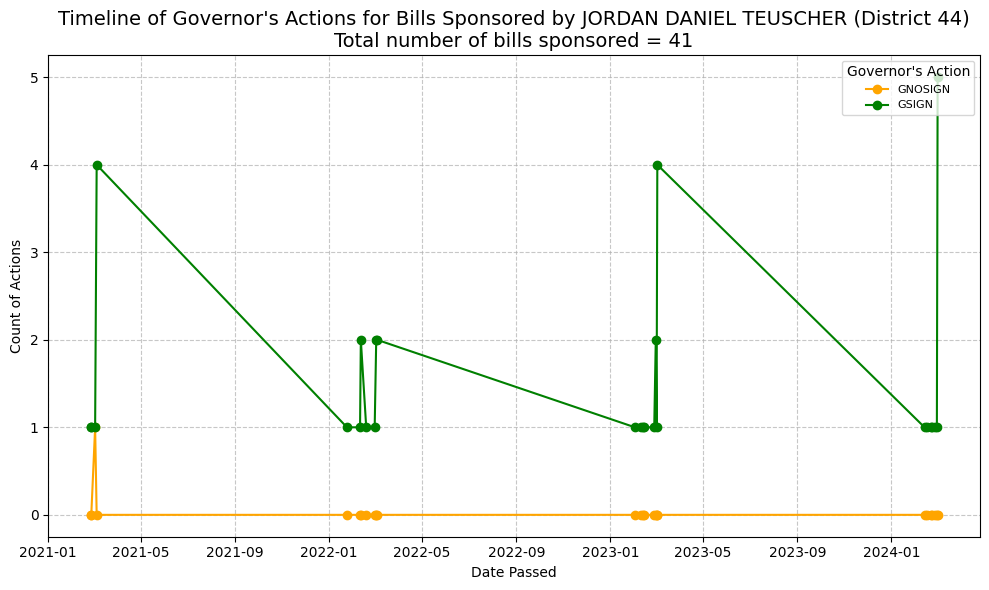

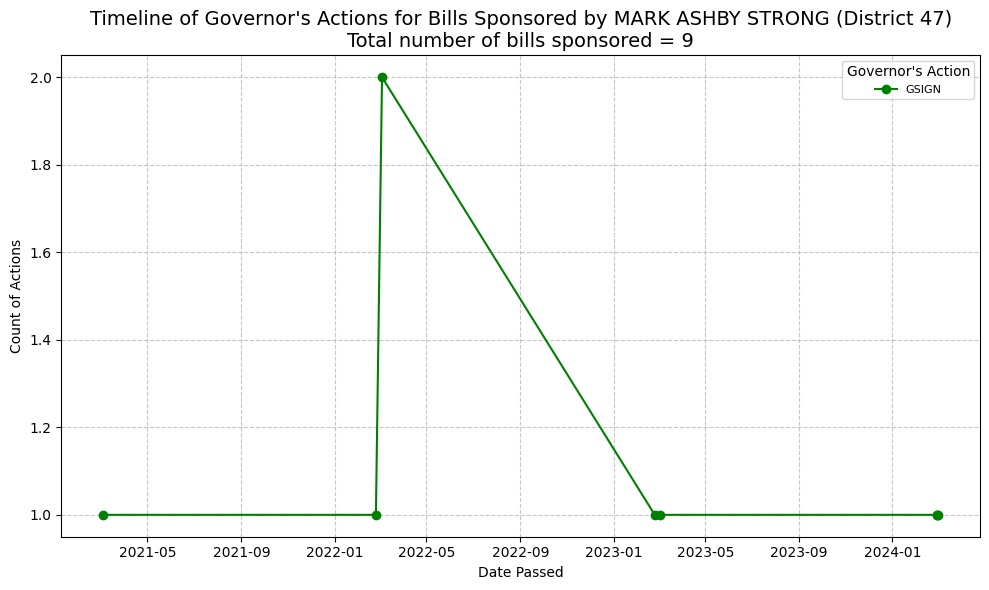

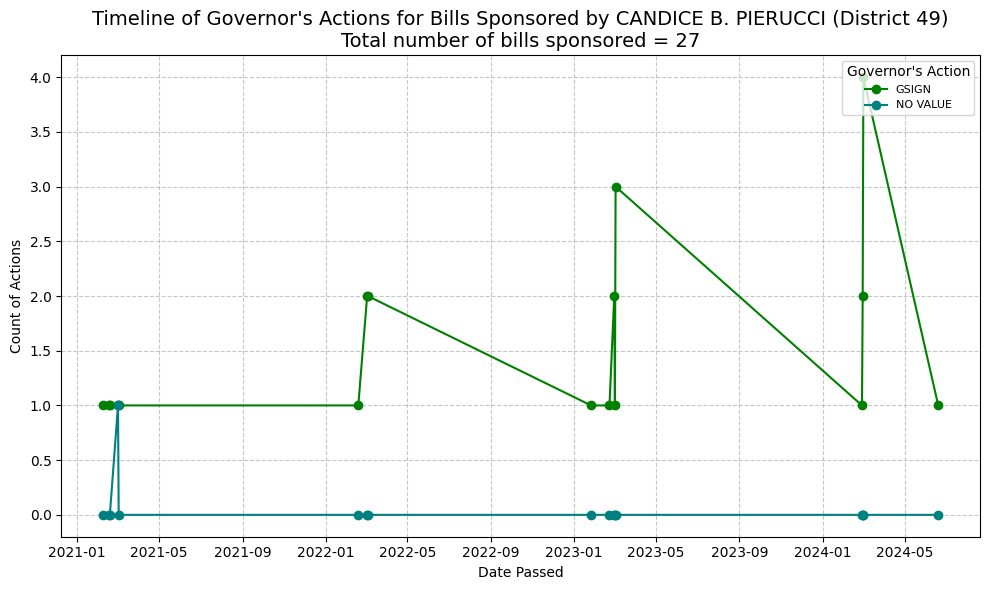

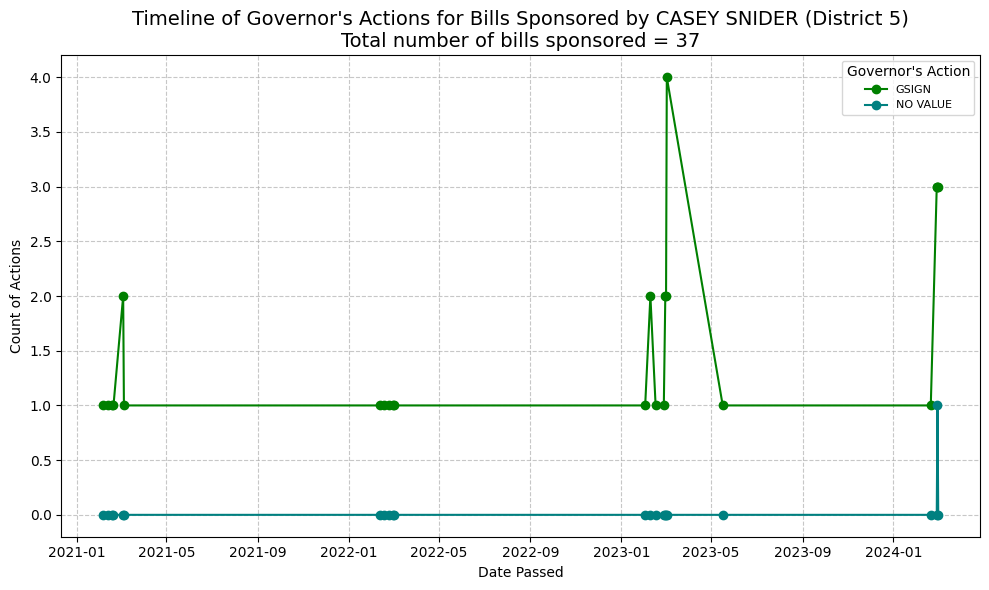

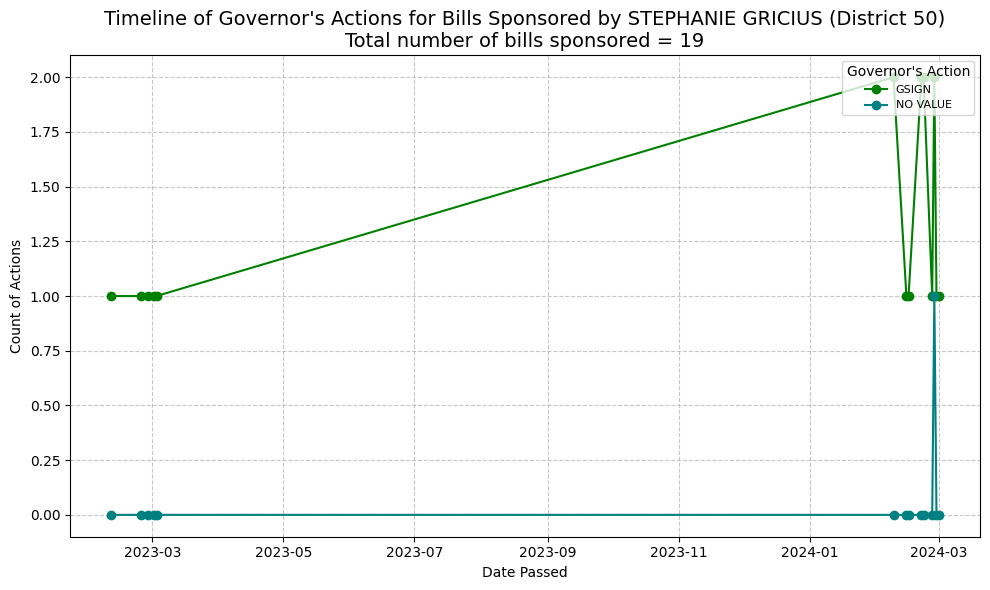

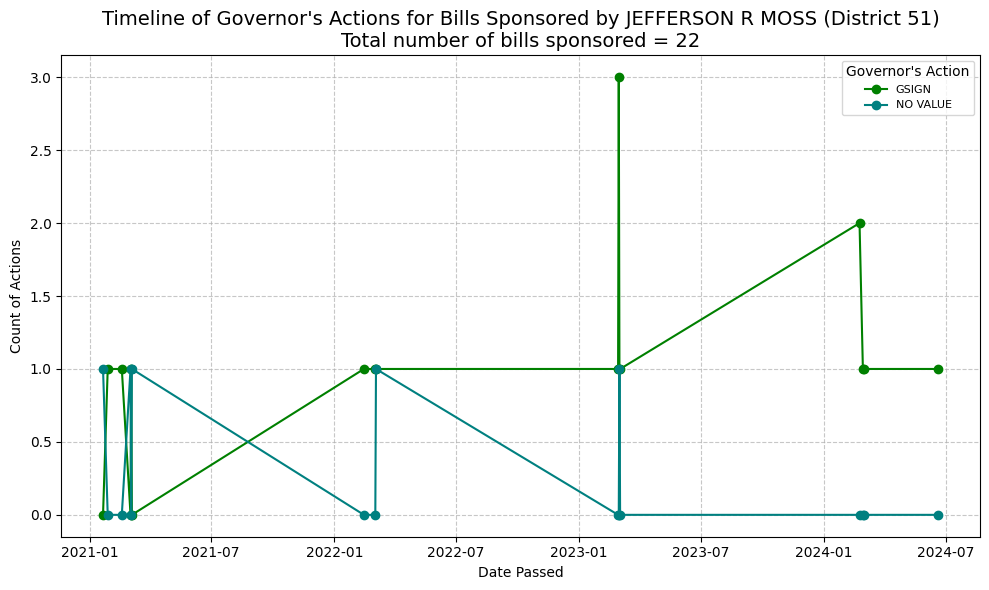

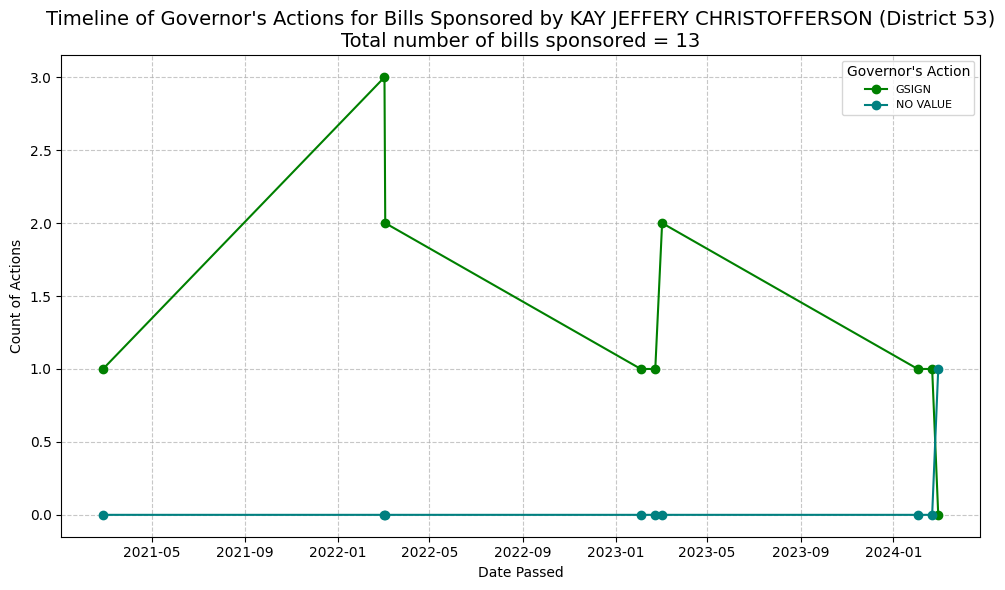

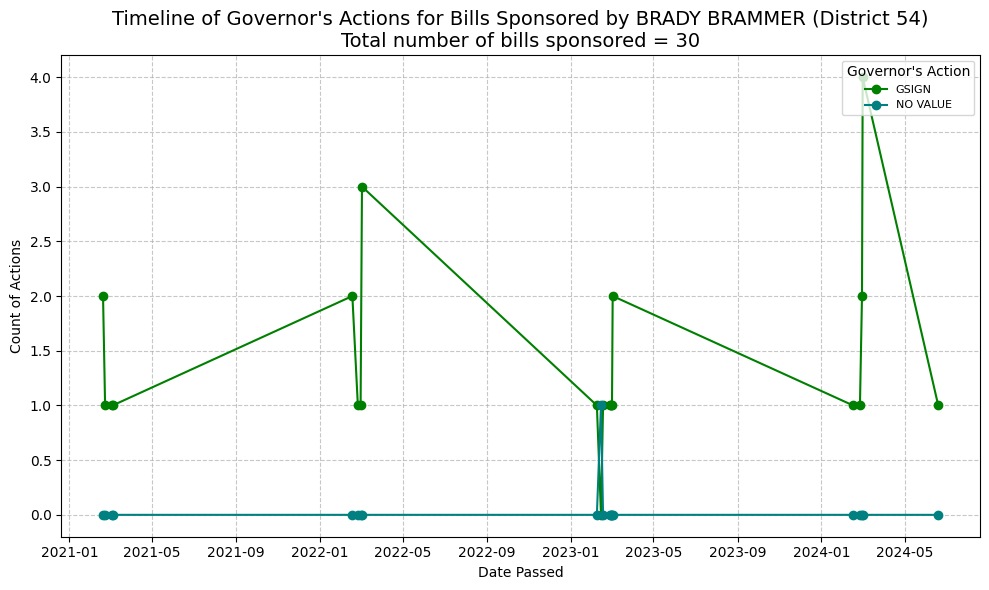

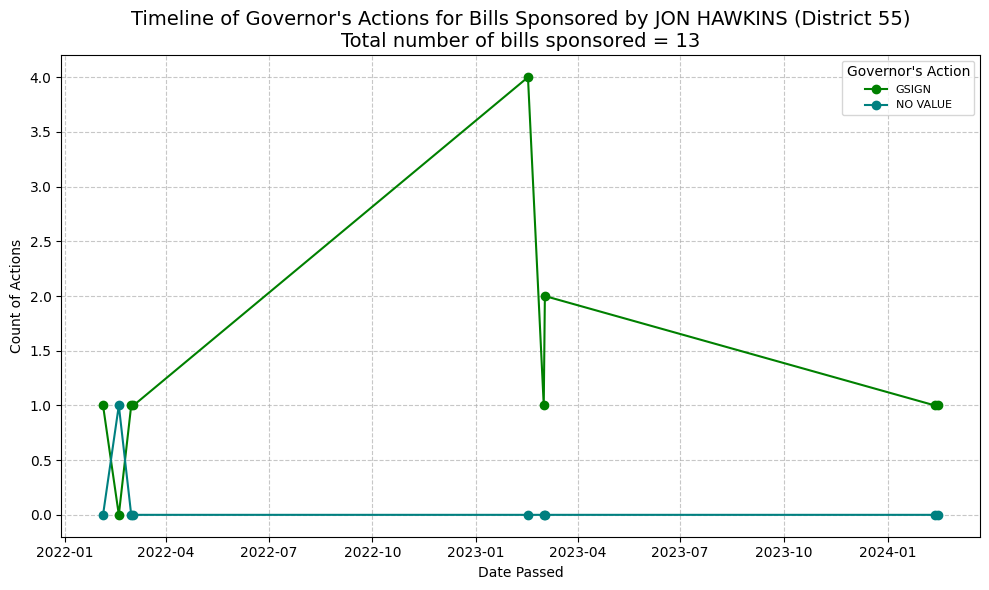

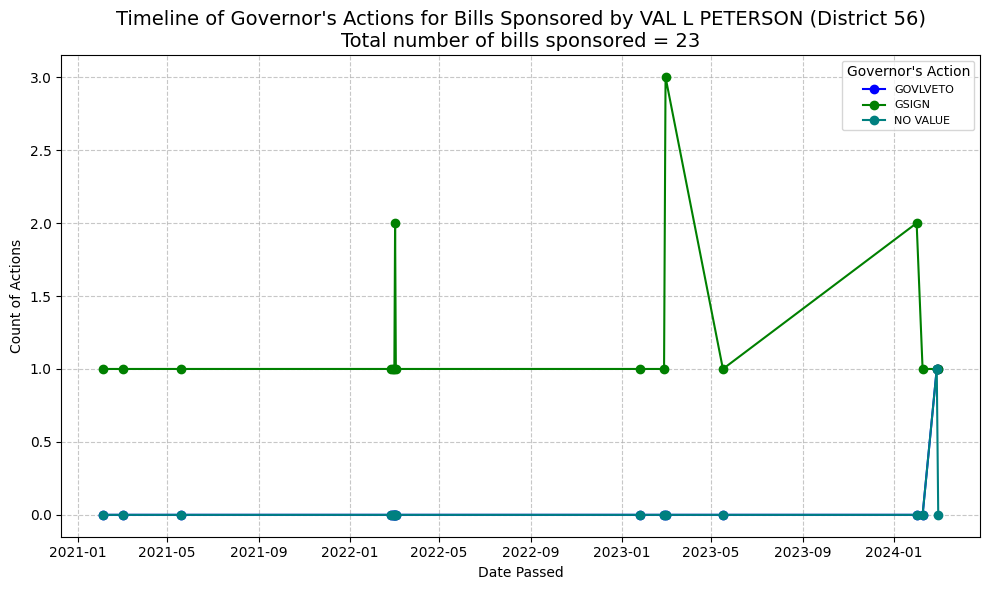

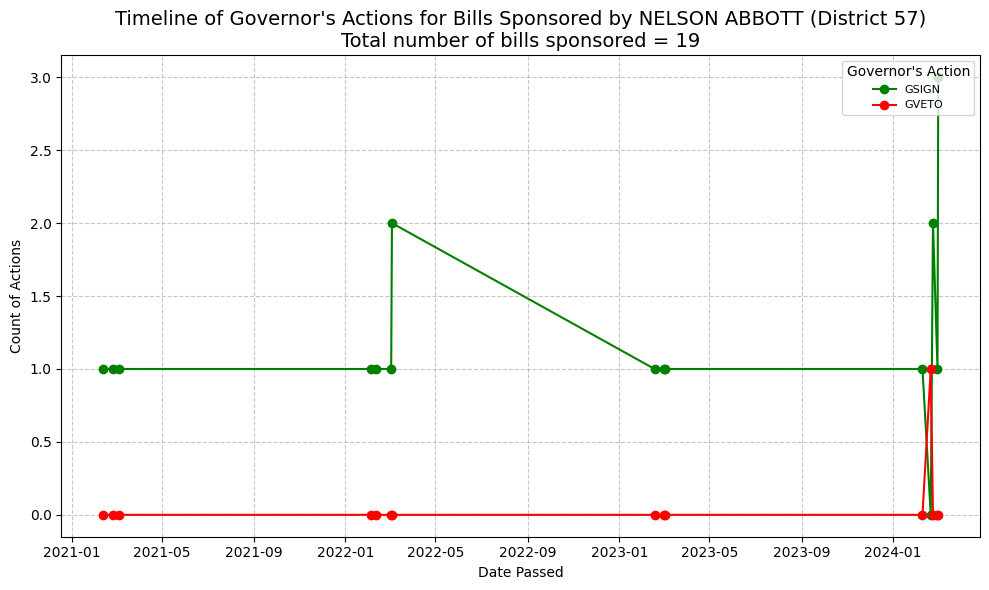

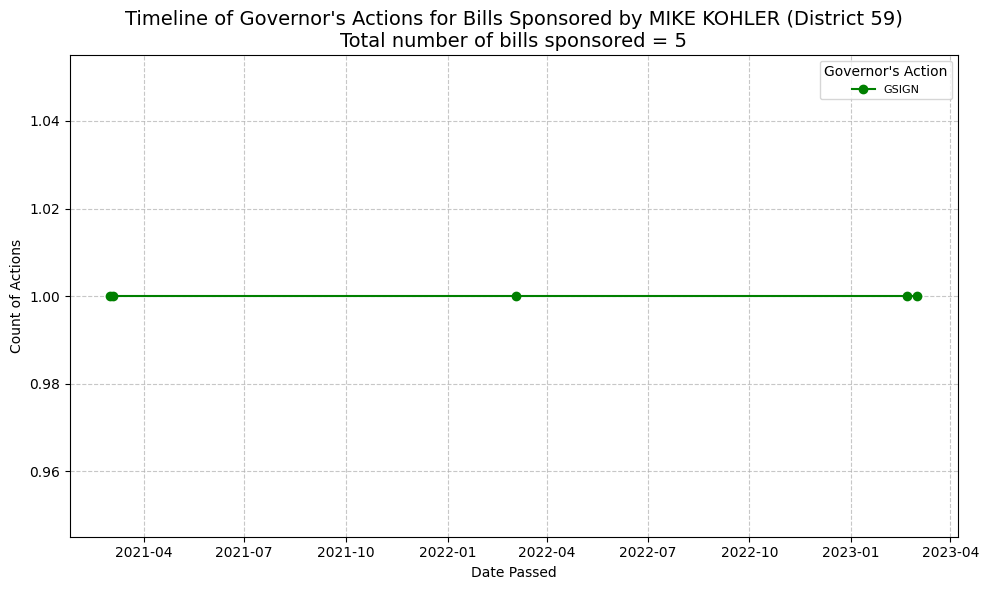

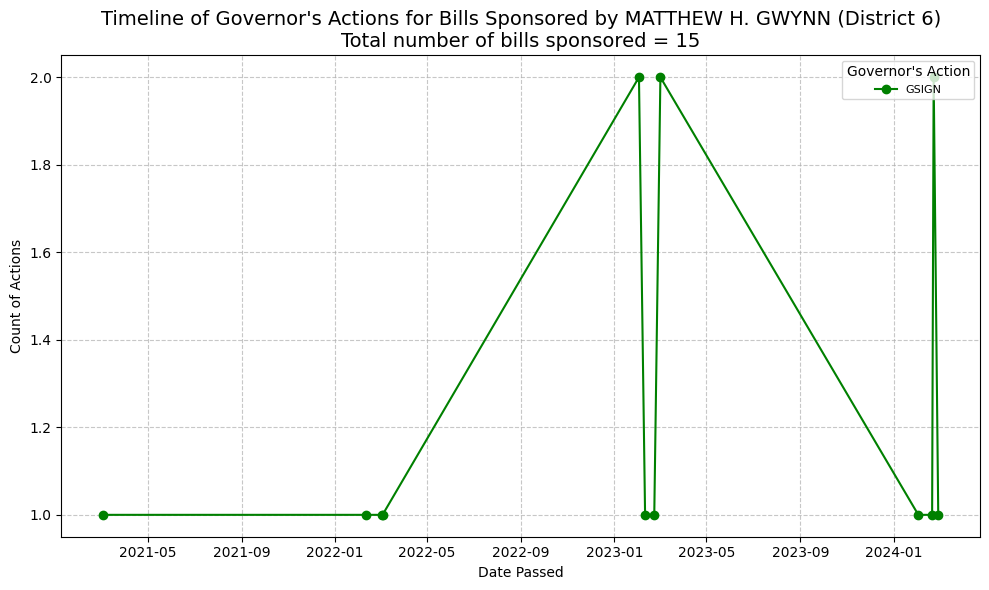

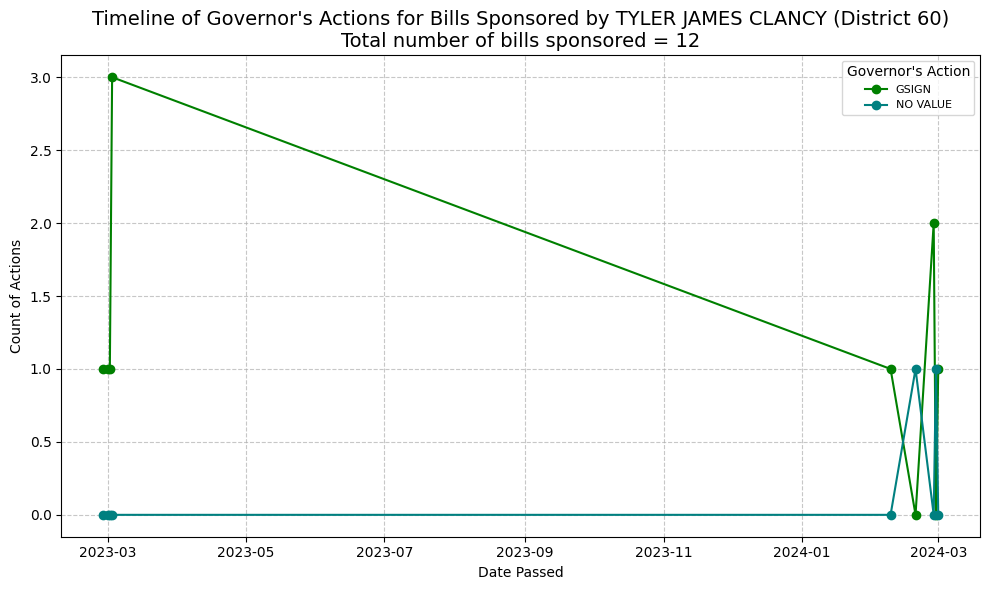

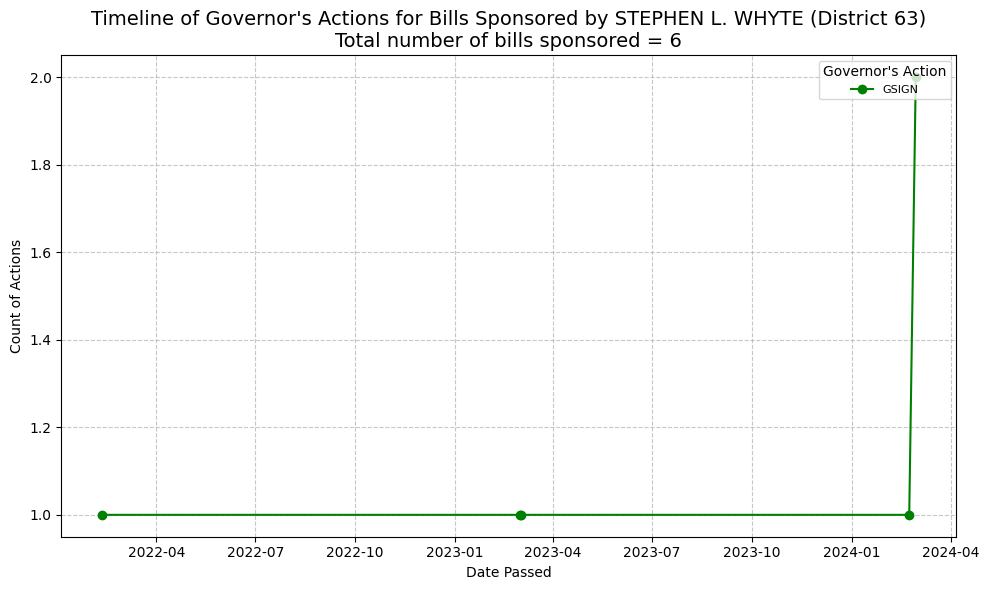

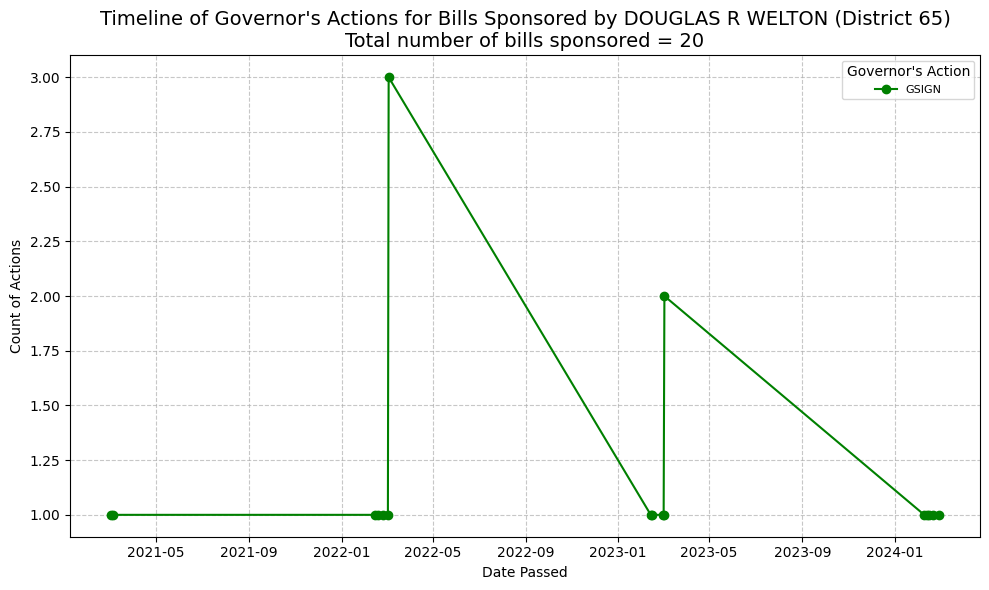

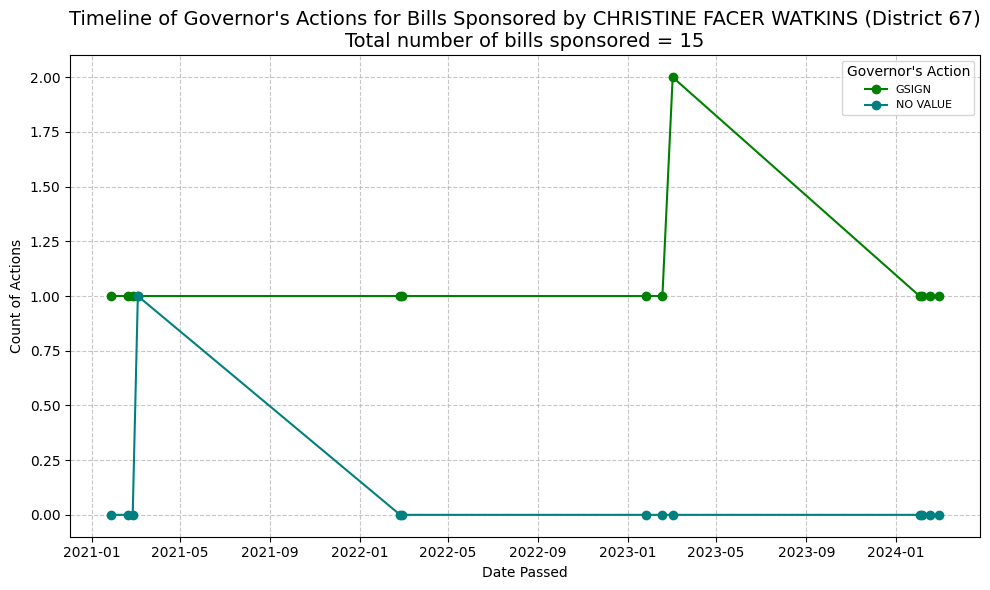

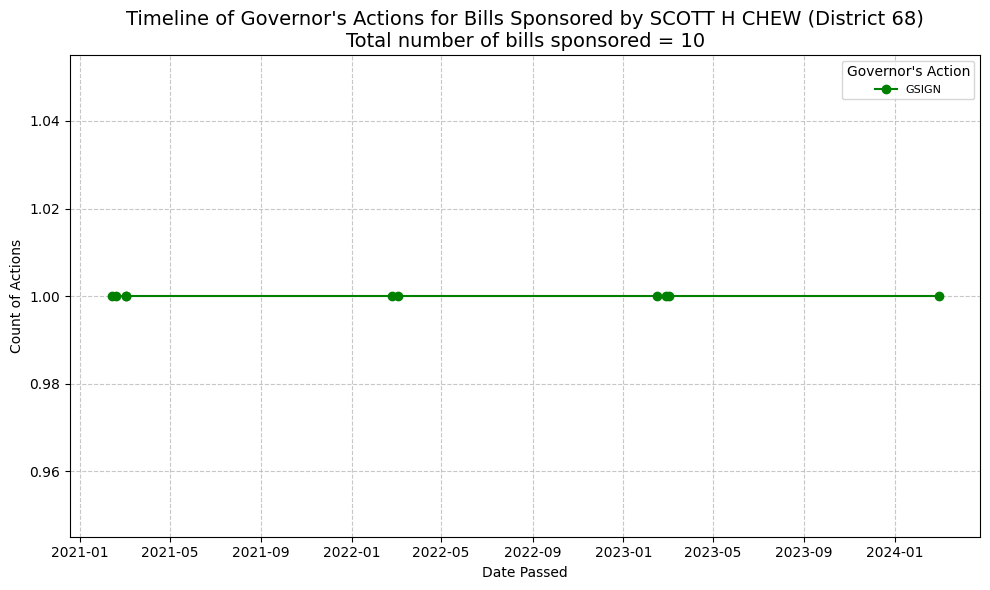

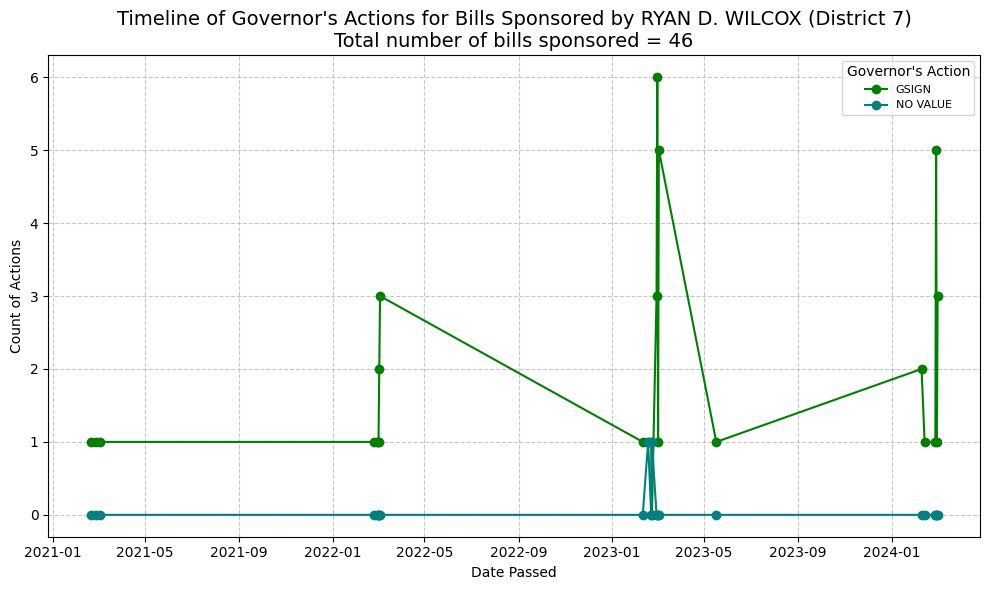

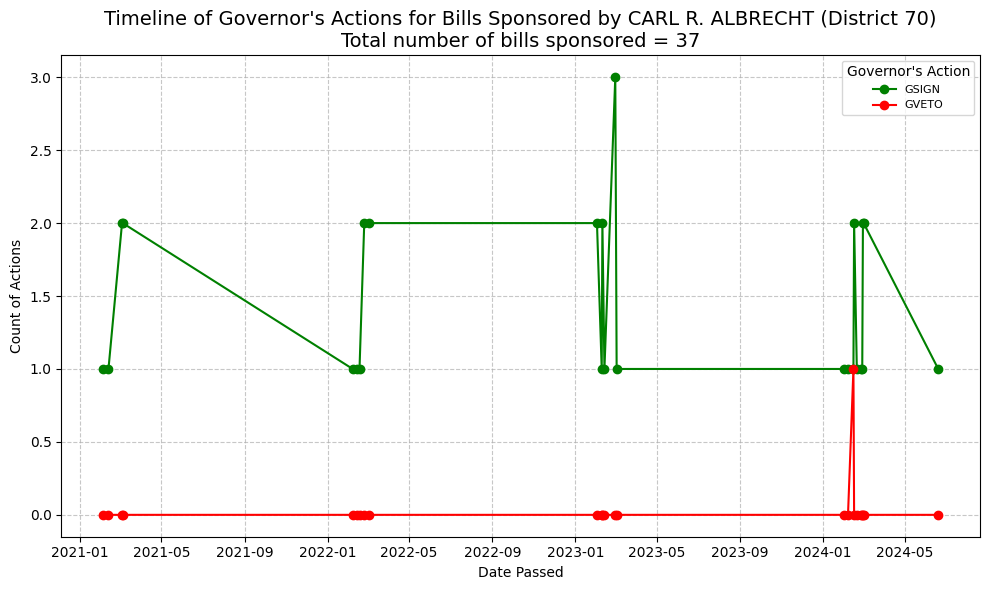

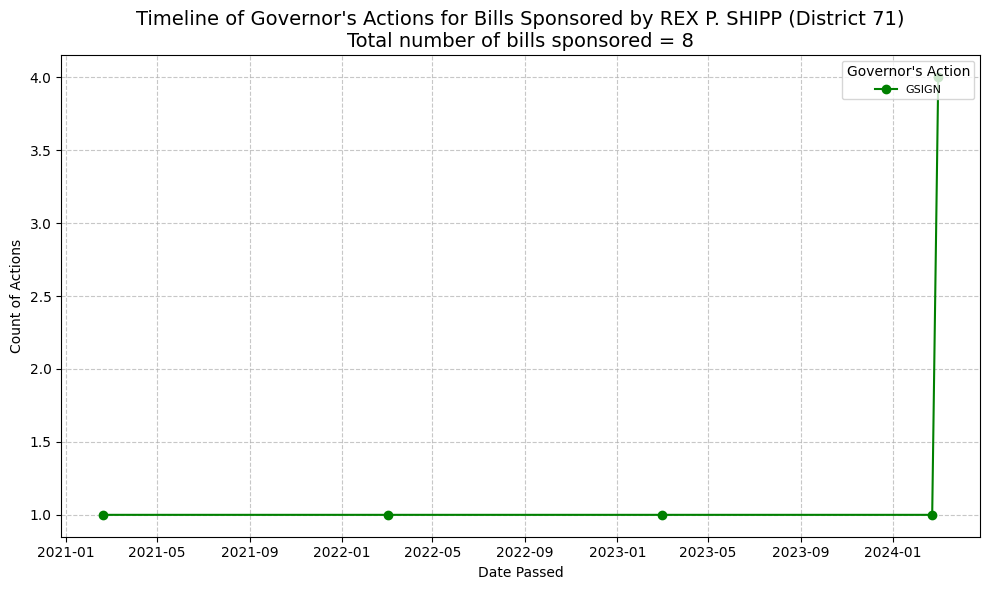

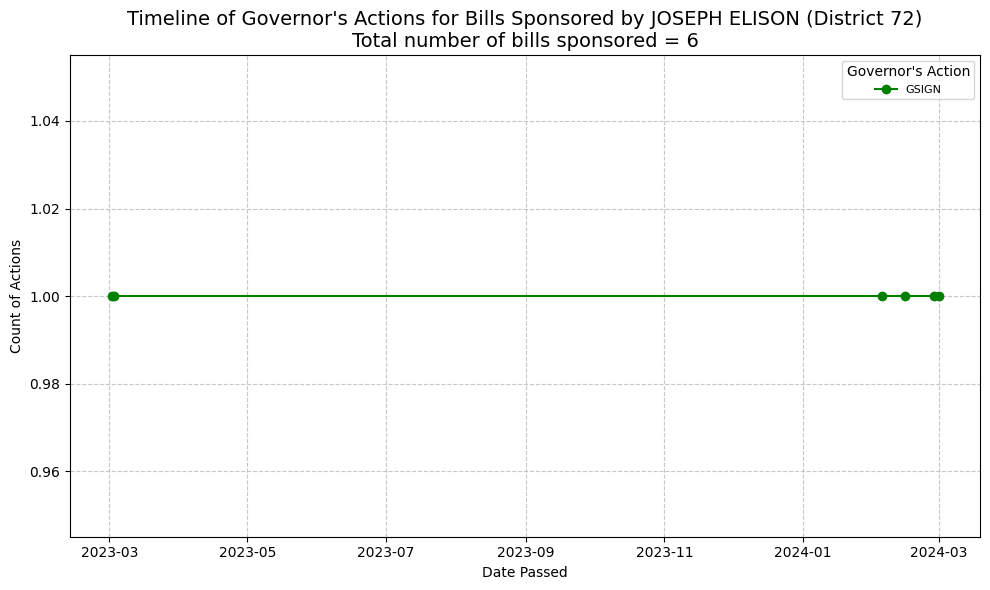

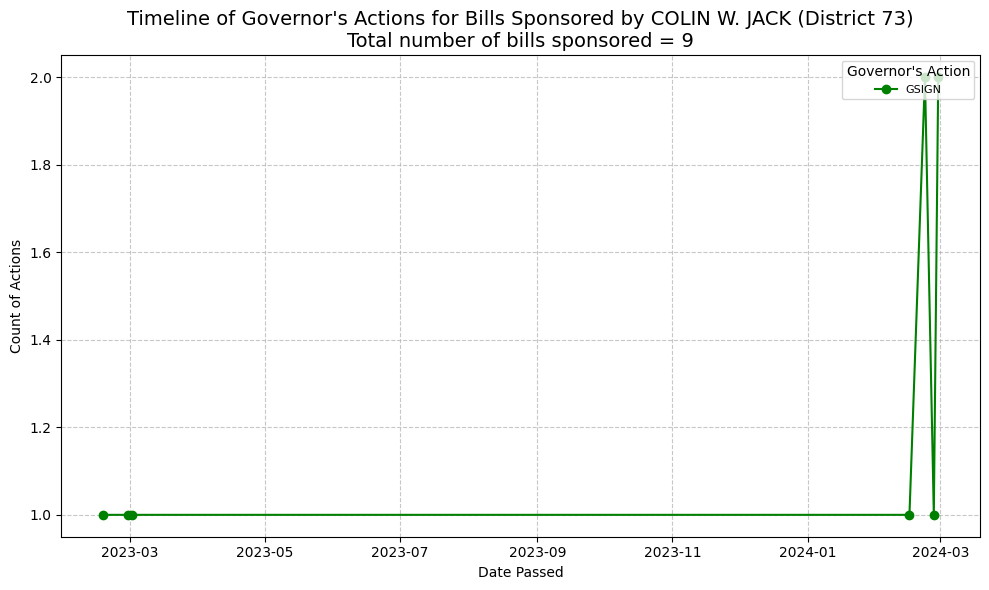

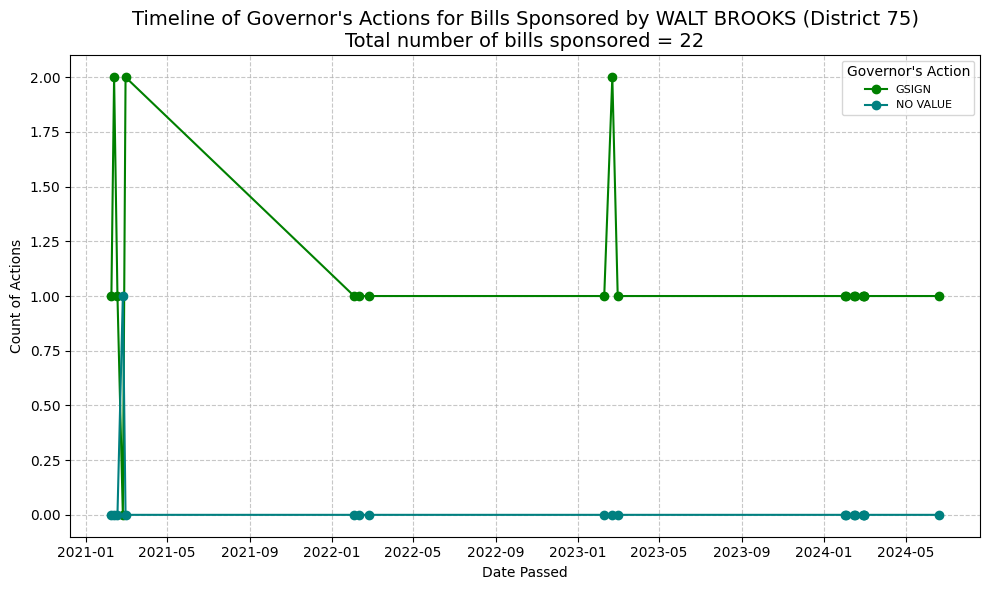

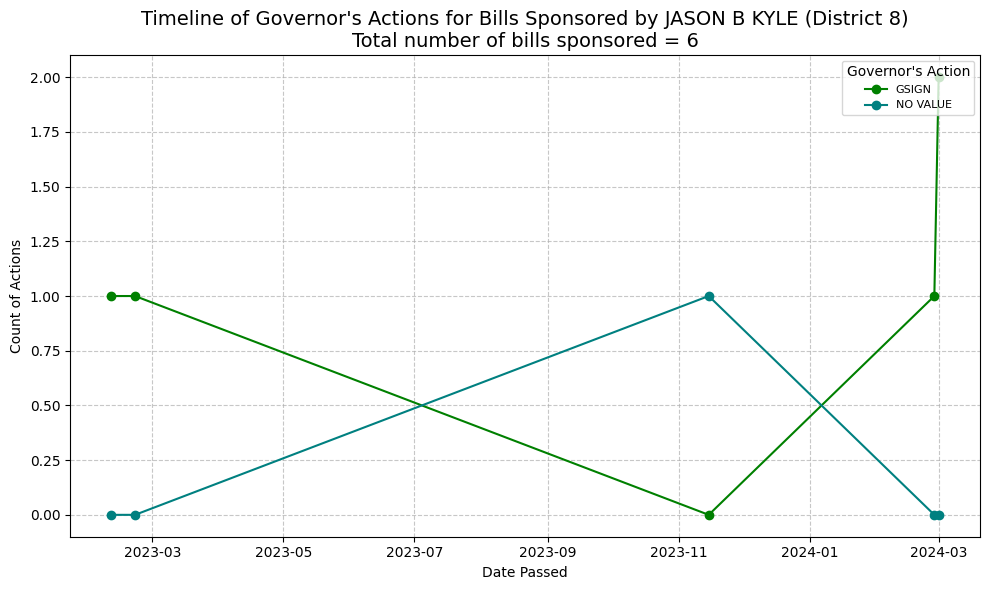

In [8]:
color_map = {
    'GSIGN': 'green',
    'GVETO': 'red',
    'NO VALUE': 'teal',
    'GOVLVETO': 'blue',
    'GNOSIGN': 'orange',
    None: 'purple'  # Using None for NaN values
}

for candidate in candidates_with_bills['Name on Ballot'].unique():
    candidate_bills = candidates_with_bills[candidates_with_bills['Name on Ballot'] == candidate]
    candidate_bills['Date Passed'] = pd.to_datetime(candidate_bills['Date Passed'])
    total_bills = len(candidate_bills)

    display_district = candidate_bills['Display District'].iloc[0] if not candidate_bills.empty else "N/A"

    timeline_data = candidate_bills.groupby(['Date Passed', 'Governor\'s Action']).size().unstack(fill_value=0)
    fig, ax = plt.subplots(figsize=(10, 6))

    for action in timeline_data.columns:
        ax.plot(timeline_data.index, timeline_data[action],
                label=action,
                marker='o',
                color=color_map.get(action, 'black'))  # Default to black if action not in map

    ax.set_title(f"Timeline of Governor's Actions for Bills Sponsored by {candidate} ({display_district})\n"
                 f"Total number of bills sponsored = {total_bills}", fontsize=14)
    ax.set_ylabel("Count of Actions")
    ax.set_xlabel("Date Passed")
    ax.legend(title='Governor\'s Action', loc='upper right', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()